# **Project Title: What makes great music, great?**



**Team Name:**<br>
Not a Modelling Agency<br><br>
**Team Members:**<br>
- Mansi
- Chaitanya
- Aditya
- Vrish


**Problem Statement/Goal:**<br>

We want to analyse the top 100 songs of every year from 1970 till 2021 and see how music preferences have evolved, have any choices remained same over the years, etc. We will also make a model to predict which songs make it to the top of the charts every year based on aspects like danceability, loudness, tempo, etc. Finally, we will also analyse music lyrics and see what words occur frequently in the top hits. We are also building a recommendation system and a streamlit website as frontend to make it interactive for everyone!

**Data Resources:**

We will collect all music related data from Spotify API and all lyrics data from Genius API

**Unique Selling Point:**

It would be amazing if we can introduce modelling and make a hard science out of what is considered a very creative field and basic models such as regression models used to model the song performance in top charts will be extremely interpretable and give us a good sense of what aspects of music production are crucial to its success.


**References:**

Spotify API documentation:<br>
https://developer.spotify.com/documentation/

Genius API documentation:<br>
https://docs.genius.com/#/getting-started-h1

Streamlit Website Link: https://meraxes-99-spotify-music-recommendati-streamlit-frontend-ceca43.streamlitapp.com/<br>
GitHub Repository Link: https://github.com/meraxes-99/Spotify_Music_Recommendations

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import requests
import wikipedia # Package to acces the Wikipedia API
import spotipy # Package to acces the Spotify API
from bs4 import BeautifulSoup
from tqdm import tqdm
from spotipy.oauth2 import SpotifyClientCredentials # Module to authenticate a Spotify User
import time
from ast import literal_eval
import re
from copy import deepcopy
from fuzzywuzzy import fuzz # Module to get Fuzzy Matches of Strings
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
from mplsoccer import PyPizza, FontManager # Modules to plot Pizza Charts and download fonts 
from highlight_text import fig_text, ax_text # Modules to highlight text in visualizations
import matplotlib.patheffects as path_effects
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LinearSegmentedColormap

from time import sleep
from lyricsgenius import Genius
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from my_secrets import client_id, client_access_token, client_secret # API keys for Genius API

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

import keras
from keras import layers
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity

from google.colab import files
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeClassifier

import lime
import lime.lime_tabular
import sklearn
import xgboost as xgb 
import sklearn.ensemble
from sklearn.model_selection import train_test_split 
import lime.lime_tabular 
import shap 
import time 
import os 

import warnings
warnings.filterwarnings("ignore")

# Data Collection and Preprocessing

Initialising spotipy object to call the Spotify API functions using the `client_id` and `client_secret`

In [ ]:
clientID = '60f1e0a91b764b9eac6b5d652f8bb384'
clientSecret = '5f34cf94b74c43ec853706b274e7675b'

In [ ]:
client_credentials_manager = SpotifyClientCredentials(client_id=clientID, client_secret=clientSecret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

## Data Collection - Billboard Hot-100 Year-End Charts

__Function to scrape the Billboard chart of an year available in Wikipedia__

In [ ]:
def getBillboard(year):
    
    mainURL = 'https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_' # Root URL path
    req = requests.get(mainURL+str(year)) # Getting the response object from the URL
    text = req.text # Getting the text in the response object

    soup = BeautifulSoup(markup=text,features = 'html.parser')   # Initialising a Beautiful Soup object to parse the HTML text

    # Creating empty lists to store the Rank, Song Name and Artist Name in the Billboard chart
    rank = []
    song = []
    artist = []
    # Parsing through the text and storing the required information
    for row in soup.find_all('table',attrs={'class':'wikitable'})[0].find_all('tr'):
        if row.find('th'):
            continue
        if row.find('td'):
            rank.append(row.contents[1].text)
            song.append(row.contents[3].text)
            artist.append(row.contents[5].text)        

    # Converting the stored information into a DataFrame
    df = pd.DataFrame()
    df['Rank'] = rank
    df['Song'] = song
    df['Artist'] = artist
    df['Year'] = year
    
    return df

Iterating from the year 1960-2021 and appending the Billboard DataFrame of each year


In [ ]:
dfBillboards = pd.DataFrame()
for year in tqdm(range(1960,2022)):
    dfBillboards = dfBillboards.append(getBillboard(year))

Formatting the text in the dataframe by removing the unneccessary characters  

In [ ]:
dfBillboards['Rank'] = dfBillboards['Rank'].str.replace('\n','')
dfBillboards['Artist'] = dfBillboards['Artist'].str.replace('\n','')
dfBillboards['Song'] = dfBillboards['Song'].str.replace('"','')

In [ ]:
dfBillboards.reset_index(inplace=True,drop=True)

Storing the Billboards dataframe

In [ ]:
dfBillboards.to_csv(r'D:\Analytics\Univ\Data\Billboards.csv',index=False)

Reading the Billboards dataframe

In [ ]:
dfBillboards = pd.read_csv(r'D:\Analytics\Univ\Data\Billboards.csv')

## Data Collection - Spotify Features of the Billboard Hits

__Creating a loop to iterate over each song in the Billboard DataFrame and to store the Spotify URI (Unique Reference Identifier) of that song.__

In [ ]:
songURIList = [] # List to store the URIs 
for idx,_ in tqdm(dfBillboards.iterrows()): # Iterating through each song in the dataframe
    
    # Storing the song name and song release year
    track = dfBillboards['Song'][idx] 
    year = dfBillboards['Year'][idx]

    # Using Spotify API's search function to search for the track with multiple try and except blocks for error handling  
    try:
        artist = dfBillboards['Artist'][idx]
        searchResults = sp.search(q=f"track: {track}, artist: {artist}",type='track')
        songURI = searchResults['tracks']['items'][0]['uri']
    except:
        try:
            artist = dfBillboards['Artist'][idx]
            searchResults = sp.search(q=f"track: {track}, artist: {artist}, year: {year}",type='track')
            songURI = searchResults['tracks']['items'][0]['uri']
        except:
            try:
                artist = dfBillboards['Artist'][idx]
                searchResults = sp.search(q=f"artist: {artist},track: {track},year: {year}",type='track')
                songURI = searchResults['tracks']['items'][0]['uri']
            except:
                try:
                    artist = dfBillboards['Artist'][idx]
                    artistResults = sp.search(q=f"artist: {artist}", limit=50)
                    songName = re.sub('[^A-Za-z0-9\s]+', '', track)
                    songName = songName.lower()
                    for i in range(len(artistResults['tracks']['items'])):
                        artistSongName = re.sub('[^A-Za-z0-9\s]+', '', artistResults['tracks']['items'][i]['name'].lower())
                        if songName in artistSongName or artistSongName in songName:
                            songURI = artistResults['tracks']['items'][i]['uri']
                            break
                except:
                    try:
                        artist = dfBillboards['Artist'][idx].split('featuring')[0]
                        searchResults = sp.search(q=f"{track}, {artist}, {year}",type='track')
                        songURI = searchResults['tracks']['items'][0]['uri']
                    except:
                        try:
                            artist = dfBillboards['Artist'][idx].split('and')[0]
                            searchResults = sp.search(q=f"{track}, {artist}, {year}",type='track')
                            songURI = searchResults['tracks']['items'][0]['uri']
                        except:
                            try:
                                artist = dfBillboards['Artist'][idx].split('and')[0]
                                searchResults = sp.search(q=f"{track}, {artist}, {year}",type='track')
                                songURI = searchResults['tracks']['items'][0]['uri']
                            except:
                                songURI = 'Unavailable'
    songURIList.append(songURI)

In [ ]:
# Storing the song URIs in the DataFrame
dfBillboards['URI'] = songURIList

Storing the dataframe of Billboard Charts with the Spotify URIs 

In [ ]:
dfBillboards.to_csv(r'D:\Analytics\Univ\Data\Billboards w URIs.csv',index=False)

Reading the dataframe of Billboard Charts with the Spotify URIs 

In [ ]:
dfBillboards = pd.read_csv(r'D:\Analytics\Univ\Data\Billboards w URIs.csv')

In [ ]:
dfBillboards.head()

Rank                       Song               Artist  Year  \
0    1  Theme from A Summer Place          Percy Faith  1960   
1    2           He'll Have to Go           Jim Reeves  1960   
2    3              Cathy's Clown  The Everly Brothers  1960   
3    4               Running Bear       Johnny Preston  1960   
4    5                 Teen Angel         Mark Dinning  1960   

                                    URI  
0  spotify:track:6zwvB879PJSpTyFcg2wwnL  
1  spotify:track:7DH5dXVuQaqcKf9oTy9oUN  
2  spotify:track:27bw4i8LnECzVlbMZ4kFHw  
3  spotify:track:1mE8QtaSFxEQnr3SgxmIRf  
4  spotify:track:6kWR0zt2wWQL3Sjg5ojy9M

__Iterating through URI of each song and getting the song information and audio features of the song from SPotify API__

In [ ]:
# Creating empty lists to store the song information
songName = []
artistURI = []
artistNames = []
albumName = []
acousticness = []
danceability = []
energy = []
instrumentalness = []
liveness = []
loudness = []
speechiness = []
tempo = []
valence = []
popularity = []
artistGenres = []
releaseDate = []

# Looping over URI of all the Billboard songs
for songURI in tqdm(dfBillboards['URI']):
    
    song = sp.track(songURI)
    
    songName.append(song['name']) # Storing the spotify song name
    albumName.append(song['album']['name']) # Storing the album name of song in spotify
    album = sp.album(song["album"]["external_urls"]["spotify"]) # Storing the album URI
    releaseDate.append(album['release_date']) # Storing the album release date in spotify

    artistNames.append([artist['name'] for artist in song['artists']]) # Storing the names of artists on the song in spotify
    genres = [sp.artist(artist['external_urls']['spotify'])['genres'] for artist in song['artists']] # Storing the genres of artists on the song in spotify
    artistGenres.append(list(set(np.concatenate(genres))))

    popularity.append(song['popularity']) # Storing the song popularity in spotify
    
    # Storing the audio features of song provided by spotify
    try:
        audioFeatures = sp.audio_features(song['uri'])[0]
        acousticness.append(audioFeatures['acousticness'])
        danceability.append(audioFeatures['danceability'])
        energy.append(audioFeatures['energy'])
        instrumentalness.append(audioFeatures['instrumentalness'])
        liveness.append(audioFeatures['liveness'])
        loudness.append(audioFeatures['loudness'])
        speechiness.append(audioFeatures['speechiness'])
        tempo.append(audioFeatures['tempo'])
        valence.append(audioFeatures['valence'])
    # Storing the audio features of song as unavailable if they are not available in spotify
    except:
        acousticness.append('Unavailable')
        danceability.append('Unavailable')
        energy.append('Unavailable')
        instrumentalness.append('Unavailable')
        liveness.append('Unavailable')
        loudness.append('Unavailable')
        speechiness.append('Unavailable')
        tempo.append('Unavailable')
        valence.append('Unavailable')

100%|██████████| 6201/6201 [57:17<00:00,  1.80it/s]  


Adding the song information and audio features into the DataFrame 

In [ ]:
dfBillboards['Song Name'] = songName
dfBillboards['Album Name'] = albumName
dfBillboards['Album Release Date'] = releaseDate

dfBillboards['Artist Names'] = artistNames
dfBillboards['Artist(s) Genres'] = artistGenres

dfBillboards['Popularity'] = popularity

dfBillboards['Acousticness'] = acousticness
dfBillboards['Danceability'] = danceability
dfBillboards['Energy'] = energy
dfBillboards['Instrumentalness'] = instrumentalness
dfBillboards['Liveness'] = liveness
dfBillboards['Loudness'] = loudness
dfBillboards['Speechiness'] = speechiness
dfBillboards['Tempo'] = tempo
dfBillboards['Valence'] = valence

Storing the dataframe of Billboard Charts with the Spotify Information

In [ ]:
dfBillboards.to_csv(r'D:\Analytics\Univ\Data\Billboards with Spotify Info',index=False)

Reading the dataframe of Billboard Charts with the Spotify Information

In [ ]:
dfBillboards = pd.read_csv(r'D:\Analytics\Univ\Data\Billboards with Spotify Info')

## Data Preprocessing

There can be a few incorrect retrievals of the songs when collecting data from spotify. <br>
We are filtering out songs where the artist name provided by the Billboard charts and artist name provided by Spotify matches less than 50%. <br>
To calculate the percentage of match we are using the `fuzz` module from the `fuzzywuzzy` package.

In [ ]:
# Creating lists to store fuzzy ratios of names and artists of songs
artistFuzzRatio = []
nameFuzzRatio = []

for idx,_ in dfBillboards.iterrows():
    nameFuzzRatio.append(fuzz.ratio(dfBillboards['Song'][idx], dfBillboards['Song Name'][idx]))
    artistFuzzRatio.append(fuzz.ratio(dfBillboards['Artist'][idx], dfBillboards['Artist Names'][idx]))

Storing the fuzz ratios of the names and artists

In [ ]:
dfBillboards['Name Fuzz Ratio'] = nameFuzzRatio
dfBillboards['Artist Fuzz Ratio'] = artistFuzzRatio

Dropping rows with Artist Fuzz Ratio less than 50

In [ ]:
dfBillboards = dfBillboards[(dfBillboards['Artist Fuzz Ratio']>50)]

Dropping rows with Audio Features as `unavailable`

In [ ]:
dfBillboards = dfBillboards[dfBillboards['Danceability']!='Unavailable']

There is a single song which is tied in rank with the song above it. <br>
Using forward fill option to replace songs whose rank is 'Tie' to fill it with the rank above.

In [ ]:
dfBillboards[dfBillboards['Rank'] == 'Tie']

Rank    Song                     Artist  Year  \
1000  Tie  Let Me  Paul Revere & the Raiders  1969   

                                       URI                     Song Name  \
1000  spotify:track:5n2nKBJ0SuEgf1aWDEH4tn  Let Me! (feat. Mark Lindsay)   

           Album Name Album Release Date  \
1000  Alias Pink Puzz         1969-07-23   

                                       Artist Names  \
1000  ['Paul Revere & The Raiders', 'Mark Lindsay']   

                                       Artist(s) Genres  Popularity  \
1000  ['classic rock', 'bubblegum pop', 'protopunk',...          20   

     Acousticness Danceability Energy Instrumentalness Liveness Loudness  \
1000      0.00385         0.65  0.871         5.58e-05    0.113   -10.58   

     Speechiness    Tempo Valence  Name Fuzz Ratio  Artist Fuzz Ratio  
1000      0.0574  144.051    0.53               35                 69

In [ ]:
dfBillboards['Rank'] = dfBillboards['Rank'].replace('Tie',np.nan).ffill()

Applying `literal_eval` for the lists in form of strings to convert them to 
`list` datatype

In [ ]:
dfBillboards['Artist Names'] = dfBillboards['Artist Names'].apply(literal_eval)
dfBillboards['Artist(s) Genres'] = dfBillboards['Artist(s) Genres'].apply(literal_eval)

For songs with multiple artists,<br>
the function above returns a list of artists when gathering the artist names. <br>
Joining the names of the artists with a `|`.

In [ ]:
dfBillboards['Artist Names (Str)'] = dfBillboards['Artist Names'].apply(lambda x:"|".join(x))

Using `MultiLabelBinarizer` to One Hot encode Artist Names and Genre Names and creating DataFrames resepctively. 

In [ ]:
mlb1 = MultiLabelBinarizer()
genresOHE = pd.DataFrame(mlb1.fit_transform(dfBillboards['Artist(s) Genres']),columns = ['Genre: '+column for column in mlb1.classes_])

In [ ]:
mlb2 = MultiLabelBinarizer()
artistsOHE = pd.DataFrame(mlb2.fit_transform(dfBillboards['Artist Names']),columns = ['Artist: '+column for column in mlb2.classes_])

Concatenating the original dataframe (Billboard Hits with Spotify Information) and one-hot encoded Artists and Genres dataframes

In [ ]:
dfBillboards.reset_index(inplace=True,drop=True) # Resetting the index

In [ ]:
dfBillboards = pd.concat([dfBillboards, genresOHE, artistsOHE], axis=1)

Converting numerical columns to floats

In [ ]:
numColumns = ['Rank','Popularity','Acousticness','Danceability','Energy','Instrumentalness','Liveness','Loudness','Speechiness','Tempo','Valence']

In [ ]:
for column in numColumns:
    dfBillboards[column] = dfBillboards[column].astype('float32')

Storing the Dataframe of Billboard Songs, Spotify Information and One-Hot Encoded Artists and Genres

In [ ]:
dfBillboards.to_csv(r'D:\Analytics\Univ\Data\Billboards with Audio Features + Genres,Artists OHE.csv',index=False)

Reading the Dataframe of Billboard Songs, Spotify Information and One-Hot Encoded Artists and Genres

In [ ]:
dfBillboards = pd.read_csv(r'D:\Analytics\Univ\Data\Billboards with Audio Features + Genres,Artists OHE.csv',low_memory=False)

## Data Collection - Song Lyrics

### Genius API

In [ ]:
# Making a song lyrics column
dfBillboards['song_lyrics'] = None

__Iterating over all the songs and getting the lyrics of the song using the Song Name by using the `search_song` provided by the Genius API__

In [ ]:
# Querying all songs in the dataframe for lyrics
for index, song_name in enumerate(dfBillboards['Song Name']):
    try:
        genius = Genius(client_access_token) # Initialising the Genius API
        last_idx = index
        song = genius.search_song(dfBillboards['Song Name'].iloc[index], dfBillboards['Artist'].iloc[index])
        if song != None:
            dfBillboards.iloc[index, -1] = song.lyrics
    except:
        # If the API produces a connection timeout error, waiting for 2 mins and trying again
        print("CONNECTION TIMEOUT")
        connect_timeout_idx = index
        time.sleep(120)
        genius = Genius(client_access_token)
        last_idx = index
        song = genius.search_song(dfBillboards['Song Name'].iloc[index], dfBillboards['Artist'].iloc[index])
        if song != None:
            dfBillboards.iloc[index, -1] = song.lyrics

Searching for "The Theme from "A Summer Place"" by Percy Faith...
Done.
Searching for "He'll Have to Go" by Jim Reeves...
Done.
Searching for "Cathy's Clown - 2007 Remaster" by The Everly Brothers...
Done.
Searching for "Running Bear" by Johnny Preston...
Done.
Searching for "Teen Angel" by Mark Dinning...
Done.
Searching for "I'm Sorry" by Brenda Lee...
Done.
Searching for "It's Now or Never" by Elvis Presley...
Done.
Searching for "Handy Man" by Jimmy Jones...
Done.
Searching for "Stuck on You" by Elvis Presley...
Done.
Searching for "The Twist" by Chubby Checker...
CONNECTION TIMEOUT
Searching for "The Twist" by Chubby Checker...
Done.
Searching for "Everybody's Somebody's Fool" by Connie Francis...
Done.
Searching for "Wild One" by Bobby Rydell...
Done.
Searching for "Greenfields" by The Brothers Four...
Done.
Searching for "What in the World's Come Over You - Remastered 1990" by Jack Scott...
Done.
Searching for "El Paso" by Marty Robbins...
Done.
Searching for "Alley Oop" by The 

Timeout: Request timed out:
HTTPSConnectionPool(host='genius.com', port=443): Read timed out. (read timeout=5)

Even though we were successful in getting the lyrics using the Genius API, the estimated time of completion was more than 20 hours for all the songs because of the rate limiter.<br><br>
Hence, **we have chosen to discared our approach to collect the song lyrics using the Genius API and decided to collect lyrics of the songs with other methods**.

### Musixmatch

Musixmatch is another popular website which provides lyrics for songs. <br>
We have scraped lyrics from this website using Selenium.

__Setting up Selenium__

In [ ]:
# Setting up the options
options = webdriver.ChromeOptions()

options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# NOTE :  If you download the notebook on your local machine,comment out this option. You will be able to see the browser GUI in action.
options.add_argument('--headless')  

Constructing a dataframe to store lyrics

In [ ]:
lyrics_df = pd.DataFrame()
lyrics_df['Song'] = dfBillboards['Song']
lyrics_df['Artist'] = dfBillboards['Artist']
lyrics_df['Lyrics'] = ''

Creating a function to retrieve lyrics from Musixmatch using the Song Name and Artist Name

In [ ]:
def scrape_lyrics_selenium(song_name, artist_name):
  song_name = str(song_name.replace(' ','-')) if ' ' in song_name else str(song_name)
  artist_name = str(artist_name.replace(' ','-')) if ' ' in artist_name else str(artist_name)

  # Open browser 
  driver = webdriver.Chrome(options=options)
  # Open the website 
  driver.get(url = 'https://www.musixmatch.com/lyrics/' + artist_name + '/' + song_name)
  # Wait for the webpage to load
  sleep(1)
  # Get the lyrics
  try:
    lyrics_box = driver.find_element(By.XPATH, "/html/body/div[2]/div/div/div/main/div/div/div[3]/div[1]/div/div/div/div[2]/div[1]/span")
    lyrics = lyrics_box.text
  except:
    lyrics = 'Unavailable'
  # Close the browser
  driver.quit()

  return lyrics

In [ ]:
# Looping through the whole dataframe and assigning the lyrics
for i in range(len(lyrics_df)):
    
    song_name = lyrics_df.iloc[i]['Song']
    artist_name = lyrics_df.iloc[i]['Artist']
    
    lyrics = scrape_lyrics_selenium(song_name, artist_name)
    
    lyrics_df.loc[i]['Lyrics'] = lyrics

After examining the Lyrics Dataframe (`lyrics_df`), we observed that lyrics for more than 60% of the songs in dataset were unavailable in Musixmatch.<br><br>
Hence, we had to discard this approach as well.


### Google Knowledge Panels

Our final approach, was to collect lyrics from the knowledge panel/information box provided by google in Search Results after searching for lyrics with `Song Name + Artist Name + ' Lyrics'` as the search keywords.

Creating a function to retrieve lyrics from Information Box from Google Search Results using `Song Name + Artist Name + ' Lyrics'` as the keywords.

In [ ]:
def scrape_lyrics_selenium_google(song_name, artist_name):
  # Open browser 
  driver = webdriver.Chrome(options=options)
  # Open the website 
  driver.get(url = 'https://www.google.co.in/')
  # Wait for the webpage to load
  sleep(2)
  # Get the search box element
  search_box = driver.find_element(By.XPATH, "/html/body/div[1]/div[3]/form/div[1]/div[1]/div[1]/div/div[2]/input")
  # Search
  search_box.send_keys(song_name + ' ' + artist_name + ' lyrics' + Keys.ENTER)
  # Wait for the webpage to load
  sleep(2)
  # Get lyrics
  try:
    lyrics_box = driver.find_element(By.XPATH, "//*[@id='kp-wp-tab-default_tab:kc:/music/recording_cluster:lyrics']/div[1]/div/div/div[2]/div/div/div/div/div/div/div[1]/div[2]")
    lyrics = lyrics_box.text
  except:
    lyrics = 'Unavailable'
  # Close the browser
  driver.quit()

  return lyrics

In [ ]:
for i in range(len(lyrics_df)):
  song_name = lyrics_df.iloc[i]['Song']
  artist_name = lyrics_df.iloc[i]['Artist']
  
  lyrics = scrape_lyrics_selenium_google(song_name, artist_name)
  lyrics_df.loc[i]['Lyrics'] = lyrics

Storing the lyrics dataframe

In [ ]:
lyrics_df.to_csv(r'D:\Analytics\Univ\Data\Lyrics.csv',index=False)

Reading the Lyrics dataframe

In [ ]:
dfLyrics = pd.read_csv(r'D:\Analytics\Univ\Data\Lyrics.csv')

In [ ]:
dfLyrics.head()

Song               Artist  \
0  Theme from A Summer Place          Percy Faith   
1           He'll Have to Go           Jim Reeves   
2              Cathy's Clown  The Everly Brothers   
3               Running Bear       Johnny Preston   
4                 Teen Angel         Mark Dinning   

                                              Lyrics  
0  There's a summer place\nWhere it may rain or s...  
1  Put your sweet lips a little closer to the pho...  
2  Don't want your love anymore\nDon't want your ...  
3  On the bank of the river stood Running Bear, y...  
4  Teen angel, teen angel, teen angel, ooh\nThat ...

In [ ]:
print('Percentage of Lyrics available: {:.2f}%'.format(dfLyrics[dfLyrics['Lyrics']!='Unavailable'].__len__()/len(dfLyrics)*100))
print('Percentage of Lyrics unavailable: {:.2f}%'.format(dfLyrics[dfLyrics['Lyrics']=='Unavailable'].__len__()/len(dfLyrics)*100))

Percentage of Lyrics available: 82.14%
Percentage of Lyrics unavailable: 17.86%


Adding Lyrics to the main Billboards dataframe

In [ ]:
dfBillboards['Lyrics'] = dfLyrics['Lyrics']

Storing the final dataframe of Billboard Hot 100 songs, Spotify song information, one-hot encoded Artists and Genres along with the Lyrics as the Main Dataframe

In [ ]:
dfBillboards.to_csv(r'D:\Analytics\Univ\Data\Billboards with Audio Features + Genres,Artists OHE + Lyrics.csv',index=False)

# Exploratory Data Analysis (EDA)

###**<center>Definitions of Audio Features provided by Spotify</center>**

**Acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.<br><br>
**Danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.<br><br>
**Energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.<br><br>
**Instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.<br><br>
**Liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides a strong likelihood that the track is live.<br><br>
**Loudness**: the overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing the relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.<br><br>
**Speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audiobook, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.<br><br>
**Valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).<br><br>
**Tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, the tempo is the speed or pace of a given piece and derives directly from the average beat duration.

[Source](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features)

Downloading the Spotify fonts for visualizations


Downloading Spotify Font for visualizations


In [ ]:
gothamBold = FontManager(('https://github.com/Chaitanya98/Football-Analytics/blob/main/Barcalytix/Fonts/GothamBold.ttf?raw=true'))
gothamMed = FontManager(('https://github.com/Chaitanya98/Football-Analytics/blob/main/Barcalytix/Fonts/GothamMedium.ttf?raw=true'))
gothamLight = FontManager(('https://github.com/Chaitanya98/Football-Analytics/blob/main/Barcalytix/Fonts/GothamLight.ttf?raw=true'))

In [ ]:
spotifyGreen = '#1dda63' # Setting the defaukt spotify green

In [ ]:
pd.set_option('display.max_columns',100) # Setting pandas option to display 100 columns
plt.rcParams['axes.unicode_minus'] = False # Using the default ASCII hyphen as minus to display in visualizations

In [ ]:
# Creating a function to draw an outline/stroke in the visualizations 
def path_effect_stroke(**kwargs):
    return [path_effects.Stroke(**kwargs), path_effects.Normal()]

Reading the main DataFrame

In [ ]:
df = pd.read_csv(r'D:\Analytics\Univ\Data\Billboards with Audio Features + Genres,Artists OHE + Lyrics.csv',low_memory=False)

In [ ]:
df.head()

Rank                       Song               Artist  Year  \
0   1.0  Theme from A Summer Place          Percy Faith  1960   
1   2.0           He'll Have to Go           Jim Reeves  1960   
2   3.0              Cathy's Clown  The Everly Brothers  1960   
3   4.0               Running Bear       Johnny Preston  1960   
4   5.0                 Teen Angel         Mark Dinning  1960   

                                    URI                        Song Name  \
0  spotify:track:6zwvB879PJSpTyFcg2wwnL  The Theme from "A Summer Place"   
1  spotify:track:7DH5dXVuQaqcKf9oTy9oUN                 He'll Have to Go   
2  spotify:track:27bw4i8LnECzVlbMZ4kFHw    Cathy's Clown - 2007 Remaster   
3  spotify:track:1mE8QtaSFxEQnr3SgxmIRf                     Running Bear   
4  spotify:track:6kWR0zt2wWQL3Sjg5ojy9M                       Teen Angel   

                          Album Name Album Release Date  \
0            16 Most Requested Songs         1989-06-13   
1           The Essential Jim Reeves         1997-02-14   
2    A Date with The Everly Brothers            1960-10   
3                               ROCK         1960-12-03   
4  Pop Megahits Of The 1950's Vol. 1               2005   

                      Artist Names  \
0  ['Percy Faith & His Orchestra']   
1                   ['Jim Reeves']   
2          ['The Everly Brothers']   
3               ['Johnny Preston']   
4                 ['Mark Dinning']   

                                    Artist(s) Genres  Popularity  \
0  ['lounge', 'adult standards', "man's orchestra...        55.0   
1             ['adult standards', 'nashville sound']        51.0   
2  ['bubblegum pop', 'adult standards', 'sunshine...        52.0   
3  ['rhythm and blues', 'rockabilly', 'brill buil...        44.0   
4                    ['rhythm and blues', 'doo-wop']        34.0   

   Acousticness  Danceability  Energy  Instrumentalness  Liveness  Loudness  \
0         0.591         0.326  0.3260          0.918000     0.494   -15.144   
1         0.909         0.554  0.1860          0.001440     0.110   -15.846   
2         0.548         0.507  0.5610          0.000000     0.590   -10.472   
3         0.775         0.760  0.4680          0.000024     0.184    -8.957   
4         0.936         0.569  0.0638          0.000000     0.122   -18.548   

   Speechiness    Tempo  Valence  Name Fuzz Ratio  Artist Fuzz Ratio  \
0       0.0297  186.232    0.870               89                 52   
1       0.0379   81.181    0.200              100                 83   
2       0.0353  120.042    0.890               62                 90   
3       0.0482  119.986    0.745              100                 88   
4       0.0458  101.521    0.282              100                 86   

            Artist Names (Str)  Genre: a cappella  Genre: acid house  \
0  Percy Faith & His Orchestra                  0                  0   
1                   Jim Reeves                  0                  0   
2          The Everly Brothers                  0                  0   
3               Johnny Preston                  0                  0   
4                 Mark Dinning                  0                  0   

   Genre: acid rock  Genre: acoustic blues  Genre: acoustic pop  \
0                 0                      0                    0   
1                 0                      0                    0   
2                 0                      0                    0   
3                 0                      0                    0   
4                 0                      0                    0   

   Genre: adult standards  Genre: afro dancehall  Genre: afro r&b  \
0                       1                      0                0   
1                       1                      0                0   
2                       1                      0                0   
3                       0                      0                0   
4                       0                      0                0   

   

## Distribution of Numerical Features

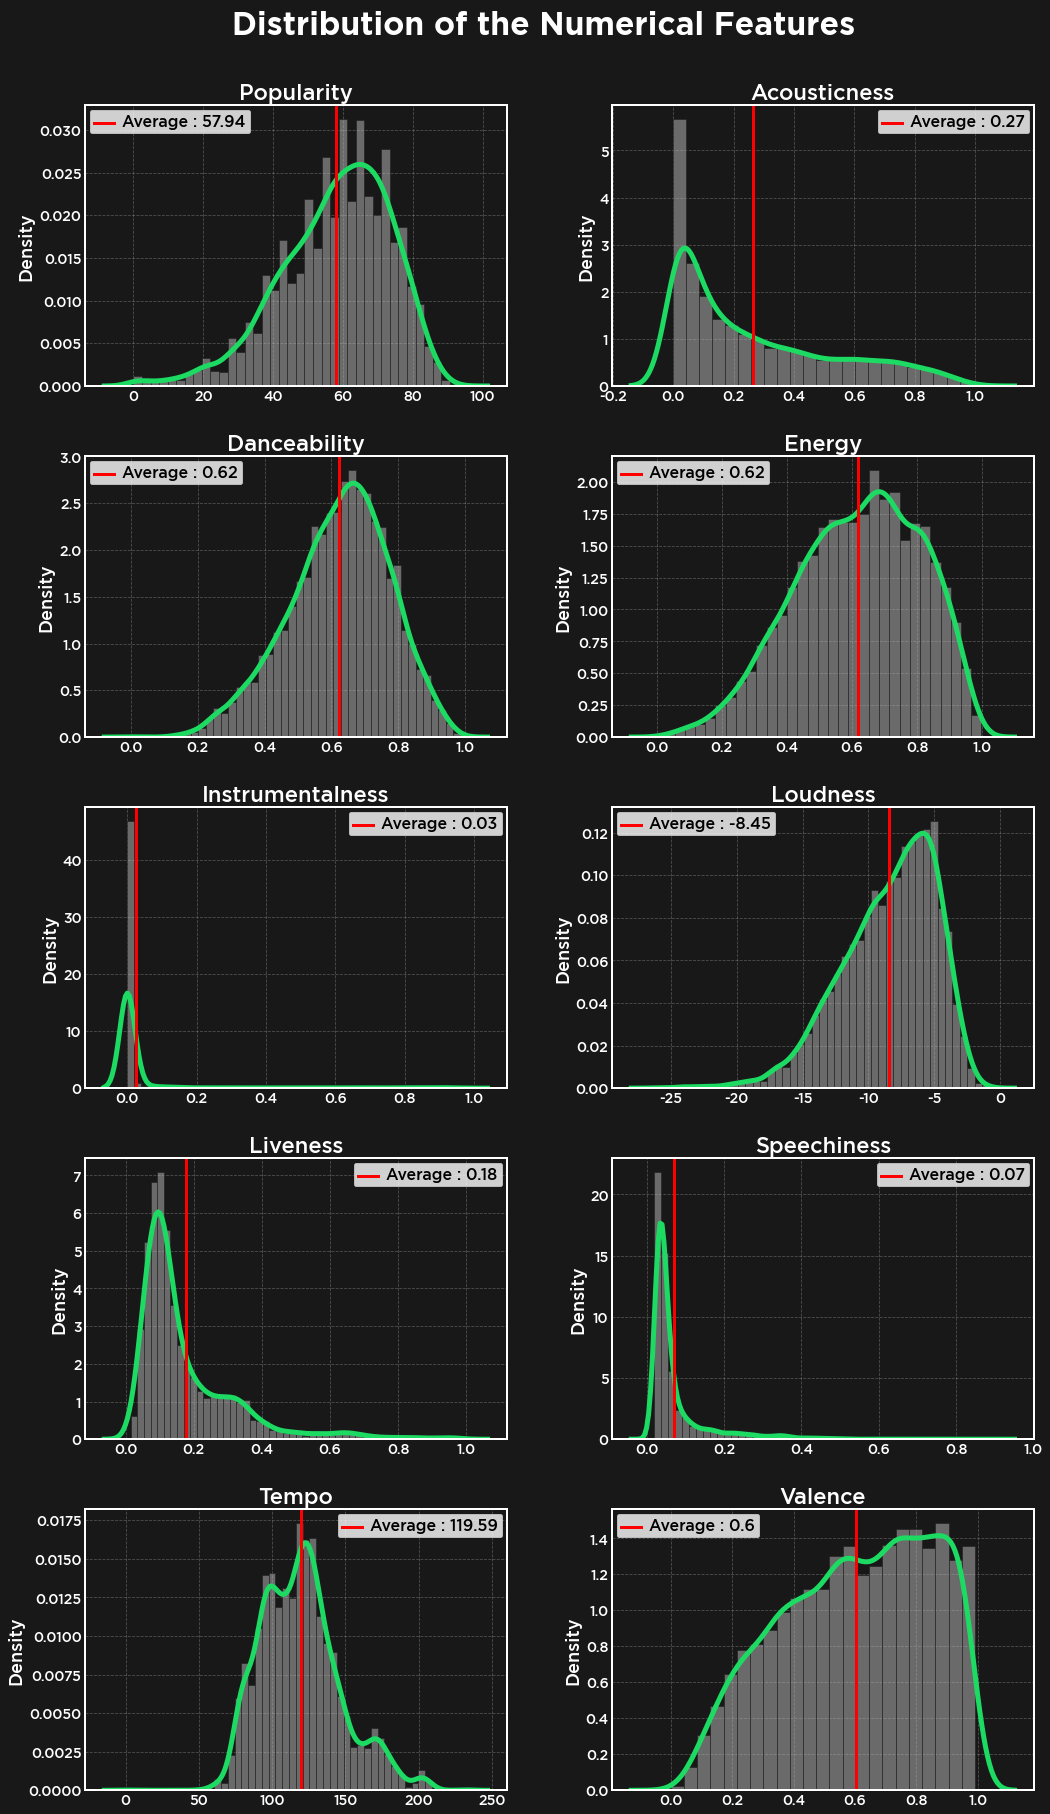

In [ ]:
# Creating a list of all the columns we want to see the distribtions for
featColumns = ['Popularity','Acousticness','Danceability','Energy','Instrumentalness','Loudness','Liveness','Speechiness','Tempo','Valence']

# Changing the linewidth and edgecolor of the spines
mpl.rc('axes',linewidth=2)
mpl.rc('axes',edgecolor='w')

# Creating subplots with axes 
fig,axs = plt.subplots(5,2,figsize=(17,31))
fig.set_facecolor('#181818')
plt.subplots_adjust(hspace=0.25,wspace=0.25) # Adjusting the subplots
axs = axs.ravel() # Raveling the axes

# Iterating over columns
for idx,column in enumerate(featColumns):
    # Setting up the grid for the axis
    axs[idx].set_facecolor('#181818')
    axs[idx].set_axisbelow(True)
    axs[idx].grid(color='#bdbdbd',which='major',linestyle='--',alpha=0.35)
    # Plotting distribtion for each numerical column
    sns.distplot(df[column],color='#bdbdbd',
                 hist_kws={'edgecolor':'#181818','alpha':0.5},
                 kde_kws={'color':spotifyGreen,'lw':'5','alpha':1},
                 ax=axs[idx])
    # Plotting average for each distribution
    axs[idx].axvline(df[column].mean(),color='r',ls='-',lw=3,label = 'Average : '+str(round(df[column].mean(),2)))
    
    # Formatting ticks and ticklabels
    [ticklabel.set_fontproperties(gothamMed.prop) for ticklabel in axs[idx].get_xticklabels()]
    [ticklabel.set_fontproperties(gothamMed.prop) for ticklabel in axs[idx].get_yticklabels()]
    axs[idx].tick_params(axis='both', which='major',labelcolor='w',labelsize=14,length=0)

    # Setting labels and title for each axes
    axs[idx].set_title(column, fontsize=22, fontproperties=gothamMed.prop, color='w')
    axs[idx].set_ylabel('Density', fontsize=18, fontproperties=gothamMed.prop, color='w')
    axs[idx].set_xlabel('', fontsize=0)
    
    # Setting and formatting legend
    legend = axs[idx].legend()
    for text in legend.get_texts():
        text.set_fontproperties(gothamMed.prop)
        text.set_fontsize(16)

# Setting title for the figure 
fig_text(s=  'Distribution of the Numerical Features\n',
         x=.5, y=0.915,
         ha='center',va='center',textalign='center',
         fontsize = 32, fontproperties = gothamBold.prop,
         color = 'w')

plt.show()

## Correlation between Numerical Features

In [ ]:
# Creating a custom color map
customcmap = LinearSegmentedColormap.from_list('custom cmap', ['#02bcfa','#ffffff','#ff0000'])

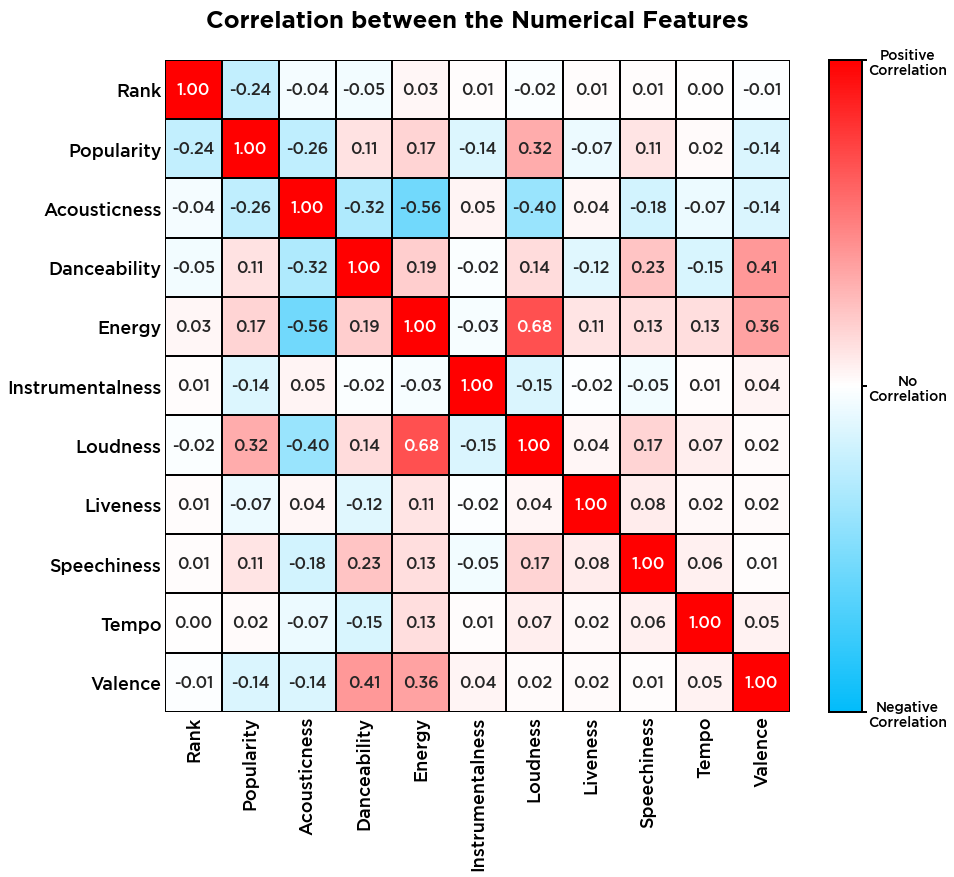

In [ ]:
# Creating subplot
fig,ax = plt.subplots(figsize=(14,12))
# Plotting a correlation heatmap using seaborn
sns.heatmap(df[['Rank']+featColumns].corr(), cmap=customcmap,
            linewidths=2,linecolor='k',
            vmin=-1, vmax=1,center=0,
            annot=True,fmt = '.2f',
            # Setting the arguments for annotations
            annot_kws={"size": 16,'fontweight':'bold','fontproperties':gothamMed.prop})
# Formatting ticks and ticklabels
[ticklabel.set_fontproperties(gothamMed.prop) for ticklabel in ax.get_xticklabels()]
[ticklabel.set_fontproperties(gothamMed.prop) for ticklabel in ax.get_yticklabels()]
ax.tick_params(axis='both', which='major',labelcolor='k',labelsize=18,length=0)
plt.xticks(rotation=90)
# Formatting the colorbar
cbarAx = ax.collections[0].colorbar
cbarAx.set_ticks([cbarAx.get_ticks()[0], 0, cbarAx.get_ticks()[-1]])
cbarAx.set_ticklabels(['Negative\nCorrelation', 'No\nCorrelation', 'Positive\nCorrelation'])
cbarAx.ax.yaxis.set_tick_params(color='k',length=5,width=2)
cbarAx.outline.set_edgecolor('k')
cbarAx.outline.set_linewidth(2)
for text in cbarAx.ax.get_yticklabels():
    text.set_fontproperties(gothamMed.prop)
    text.set_fontsize(14)
    text.set_ha('center')
    text.set_position((2.15,0))
# Setting the title    
fig_text(s=  'Correlation between the Numerical Features',
         x=.435, y=0.925,
         ha='center',va='center',textalign='center',
         fontsize = 24, fontproperties = gothamBold.prop,
         color = 'k')
    
plt.show()

__Inferences:__<br>
- Rank column has a small negative correlation with popularity i.e., higher the popularity, lower the rank value, which means popular songs tend to have upper ranks.
- There is a negative correlation between Acousticness and Energy, Loudness.
- The highest positve correlation can be observed between Energy and Loudness.
- We can also observe positive correlation between Danceability and Valence, which means that songs with more positive connotations are more danceable.

## Top Genres

### Based on Count

In [ ]:
# Calculating the most repeated genre in the Hot-100 charts
top15Genres = df[df.columns[df.columns.str.contains('Genre:')]].sum().sort_values(ascending=False).head(15).reset_index()
top15Genres.columns = ['Genre','Count']
top15Genres['Genre'] = top15Genres['Genre'].str.replace('Genre: ','')
top15Genres['Genre'] = top15Genres['Genre'].str.title()

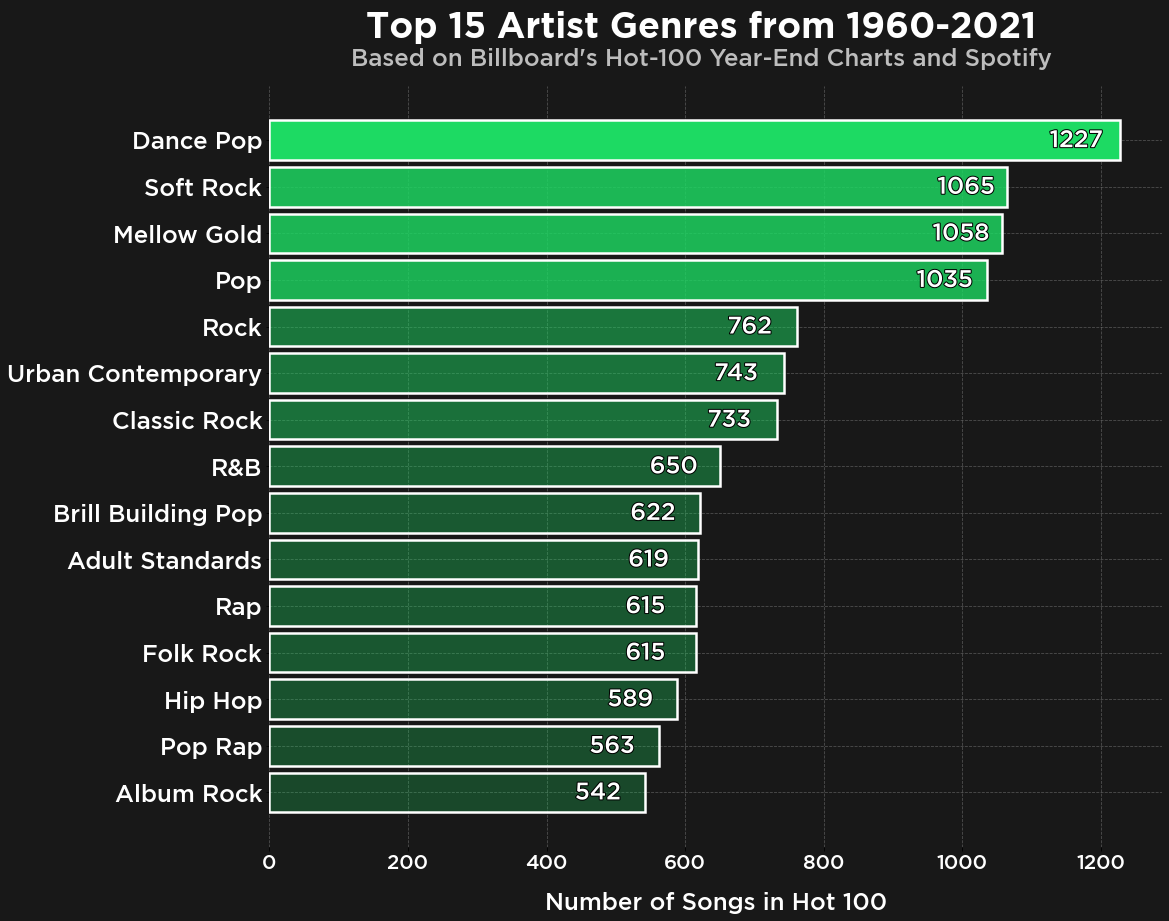

In [ ]:
## Setting the color and linewidth of the spines/borders
mpl.rc('axes',edgecolor='white')
mpl.rc('axes',linewidth='0')

# Adding background color and gridlines
fig,ax = plt.subplots(figsize=(16,14))
fig.set_facecolor('#181818')
ax.patch.set_facecolor('#181818')
ax.set_axisbelow(True)
ax.grid(color='#bdbdbd',which='major',linestyle='--',alpha=0.35)

scaler = MinMaxScaler(feature_range=(0.25,1))
# Using the normalized count values as alpha values
alphaList = scaler.fit_transform(top15Genres['Count'].values.reshape(-1,1)).flatten().tolist()

# Inverting the y-axis to show the Genre with most number of songs on the top
ax.invert_yaxis()
# Looping through each row and plotting a horizontal bar
for index,row in top15Genres.iterrows():
    ax.barh(top15Genres['Genre'][index],top15Genres['Count'][index],height=0.85,
            color=spotifyGreen,alpha=alphaList[index])
# Plotting the horizontal bars for each Genre as outlines
bars = ax.barh(top15Genres['Genre'],top15Genres['Count'],height=0.85,
               color='None',edgecolor='w',ls='-',linewidth=2.5)


# Creating a path-effect object to plot the outline for text
pe = path_effect_stroke(linewidth=2, foreground="k")


# Labeling each of the bars
ax.bar_label(bars,label_type='edge',padding=-70,fontsize=24,color='w',fontproperties=gothamMed.prop,
             path_effects=pe)

# Customizing the tick-labels for both the axes
plt.yticks(fontsize=24,color='white',fontproperties=gothamMed.prop)
plt.xticks(fontsize=20,color='white',fontproperties=gothamMed.prop)
plt.xlabel('Number of Songs in Hot 100',labelpad=20,fontsize=24,color='white',fontproperties=gothamMed.prop)

# Adding the title for the visualization using the fig_text method from highlight_text package
fig_text(s=  '<Top 15 Artist Genres from 1960-2021>\n'+
              '<Based on Billboard\'s Hot-100 Year-End Charts and Spotify>',
         x=.5, y=0.925,
         ha='center',va='center',textalign='center',
         fontsize = 24, fontproperties = gothamMed.prop,
         color = 'w',            
         highlight_textprops = [{'fontsize':36,'fontproperties':gothamBold.prop},
#                                  'path_effects':([patheffects.Stroke(linewidth=3, foreground='w'),patheffects.Normal()])},
                                {'color':'#bdbdbd'}])

plt.show()

### Based on Quality

Calculating Hit/Rank Quality for each Genre

In [ ]:
# Getting a list of all genres
genres = df.columns[df.columns.str.contains('Genre: ')].values.tolist()

In [ ]:
# Creating a dataframe of Genres and list of ranks for that genres
genreName = []
genreRanks = []
for genre in tqdm(genres):
    genreName.append(genre)
    genreRanks.append(df[df[genre]==1]['Rank'].values.tolist())
    
dfGenreRanks = pd.DataFrame()
dfGenreRanks['Genre'] = genreName
dfGenreRanks['Ranks'] = genreRanks

100%|██████████| 641/641 [00:01<00:00, 510.48it/s]


The metric we're using to assess the quality of a rank is the following,
<center><b>Hit Quality = ${maxRank}-{Rank}+1$ </b></center>
<br>
By using this metric,<br>
Genre A which has appeared once at a higher rank (like Rank 5 out of 50) and once at a lower ranking (like Rank 25 out of 50) will have higher quality than Genre B which has appeared twice at a lower ranking (like Rank 18 & Rank 19,out of 50).
<br><br>
Rank Quality of Genre A = (50-5+1)+(50-25+1) = 72<br>
Rank Quality of Genre B = (50-18+1)+(50-19+1) = 63<br>

In [ ]:
# Creating a function to calulcate the total quality of a genre by summing up the rank qualities of all songs in that genre
def quality(ranks):
    rankQuality = []
    for rank in ranks:
        rankQuality.append(100-rank+1)
    
    return sum(rankQuality)

In [ ]:
# Calculating the quality and formatting the strings
dfGenreRanks['Hit Quality'] = dfGenreRanks['Ranks'].apply(quality)
dfGenreRanks['Genre'] = dfGenreRanks['Genre'].str.replace('Genre: ','')
dfGenreRanks['Genre'] = dfGenreRanks['Genre'].str.title()

In [ ]:
# Top 15 Genres
top15GenresQual = dfGenreRanks.sort_values('Hit Quality',ascending=False).head(15)
top15GenresQual.reset_index(inplace=True,drop=True)

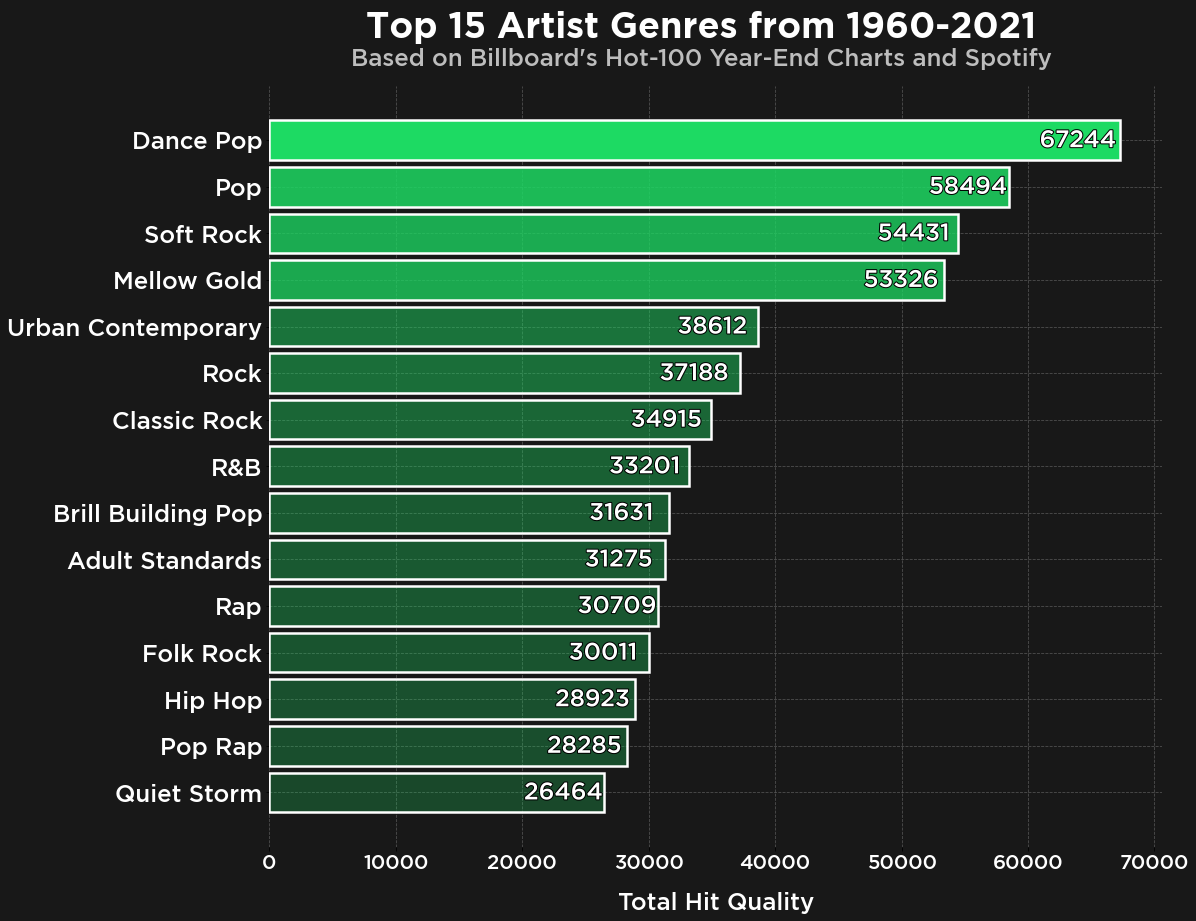

In [ ]:
## Setting the color and linewidth of the spines/borders
mpl.rc('axes',edgecolor='white')
mpl.rc('axes',linewidth='0')

# Adding background color and gridlines
fig,ax = plt.subplots(figsize=(16,14))
fig.set_facecolor('#181818')
ax.patch.set_facecolor('#181818')
ax.set_axisbelow(True)
ax.grid(color='#bdbdbd',which='major',linestyle='--',alpha=0.35)

scaler = MinMaxScaler(feature_range=(0.25,1))
# Using the normalized Hit Quality values as alpha values
alphaList = scaler.fit_transform(top15GenresQual['Hit Quality'].values.reshape(-1,1)).flatten().tolist()

# Inverting the y-axis to show the Genre with most number of top 50 films on the top
ax.invert_yaxis()
# Looping through each row and plotting a horizontal bar
for index,row in top15GenresQual.iterrows():
    ax.barh(top15GenresQual['Genre'][index],top15GenresQual['Hit Quality'][index],height=0.85,
            color=spotifyGreen,alpha=alphaList[index])
# Creating a path-effect object to plot the outline for text
pe = path_effect_stroke(linewidth=2, foreground="k")

# Plotting the horizontal bars for each Genre as outlines
bars = ax.barh(top15GenresQual['Genre'],top15GenresQual['Hit Quality'],height=0.85,
               color='None',
               edgecolor='w',ls='-',
               linewidth=2.5)

# Labeling each of the bars
ax.bar_label(bars,label_type='edge',padding=-80,fontsize=24,color='w',fontproperties=gothamMed.prop,
             path_effects=pe)

# Customizing the tick-labels for both the axes
plt.yticks(fontsize=24,color='white',fontproperties=gothamMed.prop)
plt.xticks(fontsize=20,color='white',fontproperties=gothamMed.prop)
plt.xlabel('Total Hit Quality',labelpad=20,fontsize=24,color='white',fontproperties=gothamMed.prop)

# Adding the title for the visualization using the fig_text method from highlight_text package
fig_text(s=  '<Top 15 Artist Genres from 1960-2021>\n'+
              '<Based on Billboard\'s Hot-100 Year-End Charts and Spotify>',
         x=.5, y=0.925,
         ha='center',va='center',textalign='center',
         fontsize = 24, fontproperties = gothamMed.prop,
         color = 'w',            
         highlight_textprops = [{'fontsize':36,'fontproperties':gothamBold.prop},
#                                  'path_effects':([patheffects.Stroke(linewidth=3, foreground='w'),patheffects.Normal()])},
                                {'color':'#bdbdbd'}])

plt.show()

__Inferenes:__<br>
- Dance Pop is the best genre based on both Hit Quality and Number of Songs.
- Soft Rock, Mellow Gold and Pop are the next 3 top genres, but based on the metic chosen their position is switched. 

## Top Artists

### Based on Count

In [ ]:
# Getting the artists with most appearances in the Billboard charts
top15Artists = df[df.columns[df.columns.str.contains('Artist:')]].sum().sort_values(ascending=False).head(15).reset_index()
top15Artists.columns = ['Artist','Count']
top15Artists['Artist'] = top15Artists['Artist'].str.replace('Artist: ','')

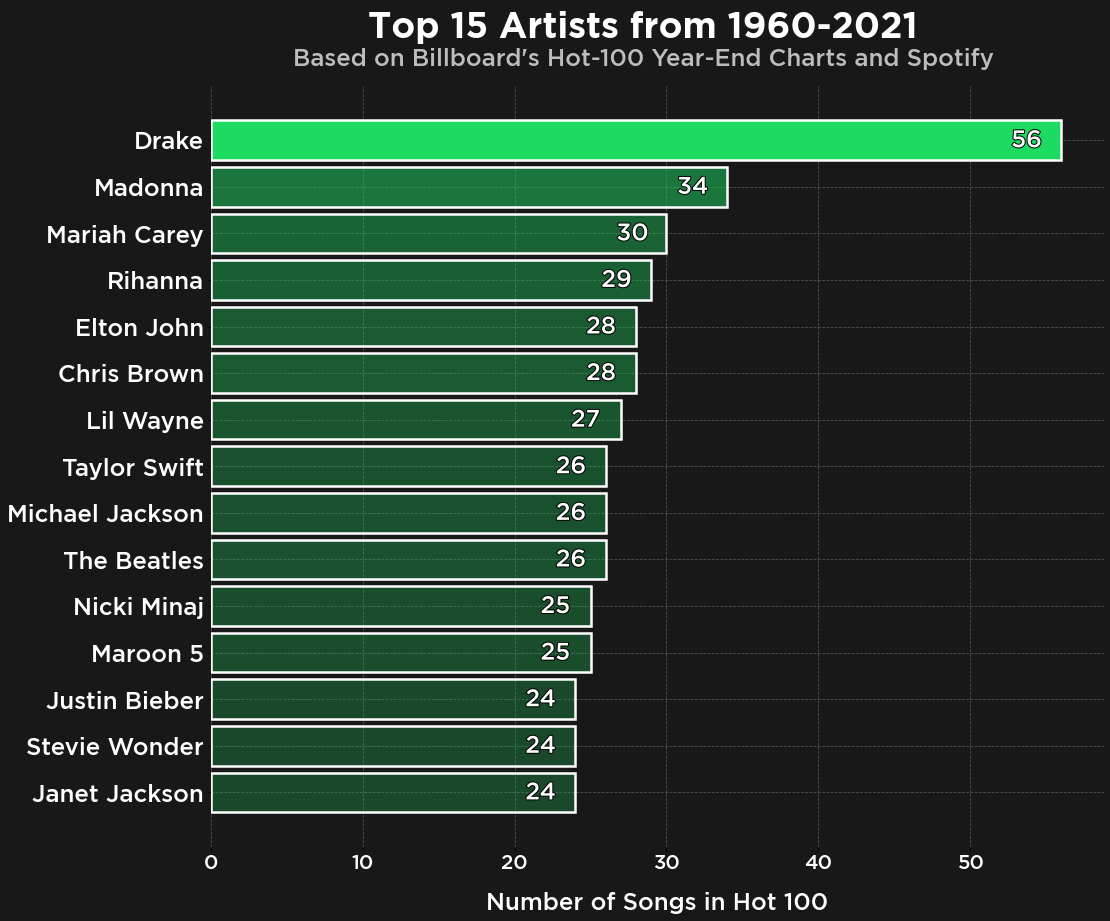

In [ ]:
## Setting the color and linewidth of the spines/borders
mpl.rc('axes',edgecolor='white')
mpl.rc('axes',linewidth='0')

# Adding background color and gridlines
fig,ax = plt.subplots(figsize=(16,14))
fig.set_facecolor('#181818')
ax.patch.set_facecolor('#181818')
ax.set_axisbelow(True)
ax.grid(color='#bdbdbd',which='major',linestyle='--',alpha=0.35)

scaler = MinMaxScaler(feature_range=(0.25,1))
# Using the normalized count values as alpha values
alphaList = scaler.fit_transform(top15Artists['Count'].values.reshape(-1,1)).flatten().tolist()

# Inverting the y-axis to show the Artist with most number of songs on the top
ax.invert_yaxis()

# Looping through each row and plotting a horizontal bar
for index,row in top15Artists.iterrows():
    ax.barh(top15Artists['Artist'][index],top15Artists['Count'][index],height=0.85,
            color=spotifyGreen,alpha=alphaList[index])

# Creating a path-effect object to plot the outline for text
pe = path_effect_stroke(linewidth=2, foreground="k")

# Plotting the horizontal bars for each Artist as outlines
bars = ax.barh(top15Artists['Artist'],top15Artists['Count'],height=0.85,
               color='None',
               edgecolor='w',ls='-',
               linewidth=2.5)

# Labeling each of the bars
ax.bar_label(bars,label_type='edge',padding=-50,fontsize=24,color='w',fontproperties=gothamMed.prop,
             path_effects=pe)

# Customizing the tick-labels for both the axes
plt.yticks(fontsize=24,color='white',fontproperties=gothamMed.prop)
plt.xticks(fontsize=20,color='white',fontproperties=gothamMed.prop)
plt.xlabel('Number of Songs in Hot 100',labelpad=20,fontsize=24,color='white',fontproperties=gothamMed.prop)

# Adding the title for the visualization using the fig_text method from highlight_text package
fig_text(s=  '<Top 15 Artists from 1960-2021>\n'+
              '<Based on Billboard\'s Hot-100 Year-End Charts and Spotify>',
         x=.5, y=0.925,
         ha='center',va='center',textalign='center',
         fontsize = 24, fontproperties = gothamMed.prop,
         color = 'w',            
         highlight_textprops = [{'fontsize':36,'fontproperties':gothamBold.prop},
#                                  'path_effects':([patheffects.Stroke(linewidth=3, foreground='w'),patheffects.Normal()])},
                                {'color':'#bdbdbd'}])

plt.show()

### Based on Quality

In [ ]:
# Getting the list of all artists
artists = df.columns[df.columns.str.contains('Artist: ')].values.tolist()

In [ ]:
# Creating a dataframe of Artists and list of ranks for that artist
artistName = []
artistRanks = []
for artist in tqdm(artists):
    artistName.append(artist)
    artistRanks.append(df[df[artist]==1]['Rank'].values.tolist())
    
dfArtistRanks = pd.DataFrame()
dfArtistRanks['Artist'] = artistName
dfArtistRanks['Ranks'] = artistRanks

100%|██████████| 2509/2509 [00:01<00:00, 1784.60it/s]


Applying Hit Quality metric used above, but for Artists instead of Genres

In [ ]:
# Creating a function to calulcate the total quality of an artist by summing up the rank qualities of all their songs
def quality(ranks):
    rankQuality = []
    for rank in ranks:
        rankQuality.append(100-rank+1)
    
    return sum(rankQuality)

In [ ]:
# Calculating Hit quality and formatting the strings
dfArtistRanks['Hit Quality'] = dfArtistRanks['Ranks'].apply(quality)
dfArtistRanks['Artist'] = dfArtistRanks['Artist'].str.replace('Artist: ','')

In [ ]:
# Getting the top 15 Artists
top15ArtistsQual = dfArtistRanks.sort_values('Hit Quality',ascending=False).head(15)
top15ArtistsQual.reset_index(inplace=True,drop=True)

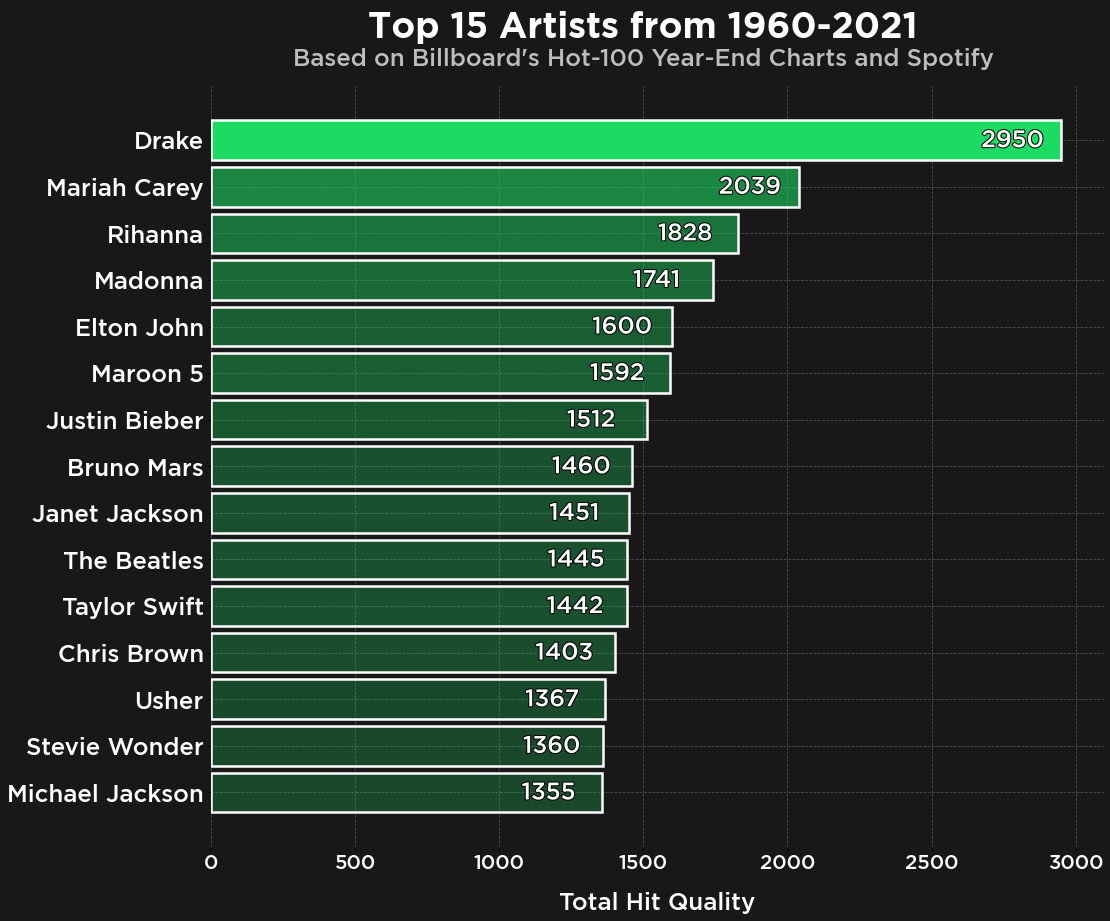

In [ ]:
## Setting the color and linewidth of the spines/borders
mpl.rc('axes',edgecolor='white')
mpl.rc('axes',linewidth='0')

# Adding background color and gridlines
fig,ax = plt.subplots(figsize=(16,14))
fig.set_facecolor('#181818')
ax.patch.set_facecolor('#181818')
ax.set_axisbelow(True)
ax.grid(color='#bdbdbd',which='major',linestyle='--',alpha=0.35)

scaler = MinMaxScaler(feature_range=(0.25,1))
# Using the normalized hit quality values as alpha values
alphaList = scaler.fit_transform(top15ArtistsQual['Hit Quality'].values.reshape(-1,1)).flatten().tolist()

# Inverting the y-axis to show the aritst with highest quality on the top
ax.invert_yaxis()

# Looping through each row and plotting a horizontal bar
for index,row in top15ArtistsQual.iterrows():
    ax.barh(top15ArtistsQual['Artist'][index],top15ArtistsQual['Hit Quality'][index],height=0.85,
            color=spotifyGreen,alpha=alphaList[index])
# Plotting the horizontal bars for each Artist as outline
bars = ax.barh(top15ArtistsQual['Artist'],top15ArtistsQual['Hit Quality'],height=0.85,
               color='None',edgecolor='w',ls='-',linewidth=2.5)

# Labeling each of the bars
ax.bar_label(bars,label_type='edge',padding=-80,fontsize=24,color='w',fontproperties=gothamMed.prop,
             path_effects=pe)

# Customizing the tick-labels for both the axes
plt.yticks(fontsize=24,color='white',fontproperties=gothamMed.prop)
plt.xticks(fontsize=20,color='white',fontproperties=gothamMed.prop)
plt.xlabel('Total Hit Quality',labelpad=20,fontsize=24,color='white',fontproperties=gothamMed.prop)

# Adding the title for the visualization using the fig_text method from highlight_text package
fig_text(s=  '<Top 15 Artists from 1960-2021>\n'+
              '<Based on Billboard\'s Hot-100 Year-End Charts and Spotify>',
         x=.5, y=0.925,
         ha='center',va='center',textalign='center',
         fontsize = 24, fontproperties = gothamMed.prop,
         color = 'w',            
         highlight_textprops = [{'fontsize':36,'fontproperties':gothamBold.prop},
                                {'color':'#bdbdbd'}])

plt.show()

### 20th Century

Finding the best Artists of ${20^{th}}$ century based on Hit quality

In [ ]:
df20 = df[df['Year']<2000]

In [ ]:
artists = df20.columns[df20.columns.str.contains('Artist: ')].values.tolist()

In [ ]:
artistName = []
artistRanks = []
for artist in tqdm(artists):
    artistName.append(artist)
    artistRanks.append(df20[df20[artist]==1]['Rank'].values.tolist())
    
df20ArtistRanks = pd.DataFrame()
df20ArtistRanks['Artist'] = artistName
df20ArtistRanks['Ranks'] = artistRanks

100%|██████████| 2509/2509 [00:01<00:00, 1928.03it/s]


In [ ]:
df20ArtistRanks['Hit Quality'] = df20ArtistRanks['Ranks'].apply(quality)
df20ArtistRanks['Artist'] = df20ArtistRanks['Artist'].str.replace('Artist: ','')

In [ ]:
top15ArtistsQual20 = df20ArtistRanks.sort_values('Hit Quality',ascending=False).head(15)
top15ArtistsQual20.reset_index(inplace=True,drop=True)

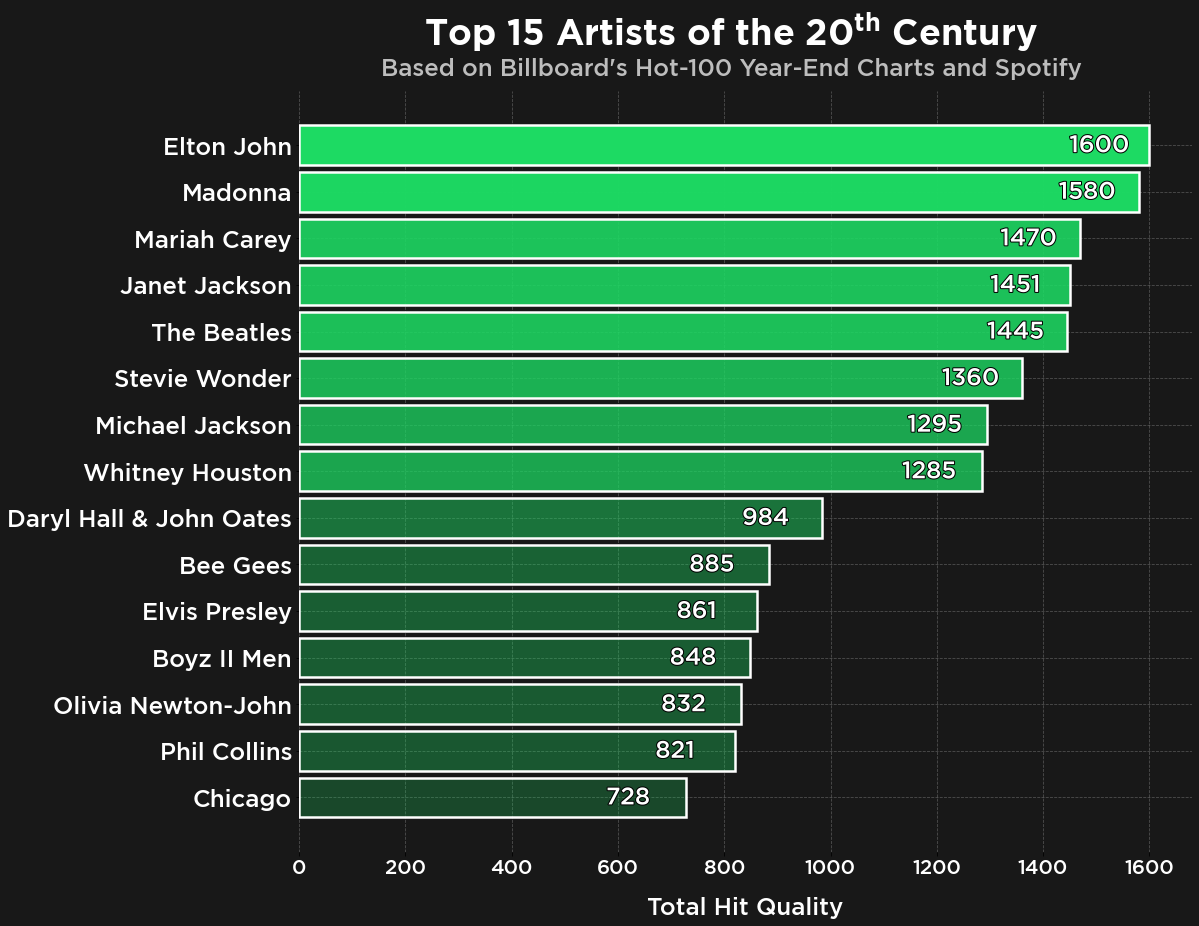

In [ ]:
## Setting the color and linewidth of the spines/borders
mpl.rc('axes',edgecolor='white')
mpl.rc('axes',linewidth='0')

# Adding background color and gridlines
fig,ax = plt.subplots(figsize=(16,14))
fig.set_facecolor('#181818')
ax.patch.set_facecolor('#181818')
ax.set_axisbelow(True)
ax.grid(color='#bdbdbd',which='major',linestyle='--',alpha=0.35)

# Using the normalized hit quality as alpha values
scaler = MinMaxScaler(feature_range=(0.25,1))
alphaList = scaler.fit_transform(top15ArtistsQual20['Hit Quality'].values.reshape(-1,1)).flatten().tolist()

# Inverting the y-axis to show the Artists with highest quality on the top
ax.invert_yaxis()

for index,row in top15ArtistsQual20.iterrows():
    ax.barh(top15ArtistsQual20['Artist'][index],top15ArtistsQual20['Hit Quality'][index],height=0.85,
            color=spotifyGreen,alpha=alphaList[index])
bars = ax.barh(top15ArtistsQual20['Artist'],top15ArtistsQual20['Hit Quality'],height=0.85,
               color='None',edgecolor='w',ls='-',linewidth=2.5)

# Labeling each of the bars
ax.bar_label(bars,label_type='edge',padding=-80,fontsize=24,color='w',fontproperties=gothamMed.prop,
             path_effects=pe)

# Customizing the tick-labels for both the axes
plt.yticks(fontsize=24,color='white',fontproperties=gothamMed.prop)
plt.xticks(fontsize=20,color='white',fontproperties=gothamMed.prop)
plt.xlabel('Total Hit Quality',labelpad=20,fontsize=24,color='white',fontproperties=gothamMed.prop)

# Adding the title for the visualization using the fig_text method from highlight_text package
fig_text(s=  '<Top 15 Artists of the $\mathregular{20^{th}}$ Century>\n'+
              '<Based on Billboard\'s Hot-100 Year-End Charts and Spotify>',
         x=.5, y=0.925,
         ha='center',va='center',textalign='center',
         fontsize = 24, fontproperties = gothamMed.prop,
         color = 'w',            
         highlight_textprops = [{'fontsize':36,'fontproperties':gothamBold.prop},
                                {'color':'#bdbdbd'}])

plt.show()

__Inference__:
- Elton John is the best artist of the $20^{th}$ century based on out Hit quality metric, with Madonna as the close $2^{nd}$.

### 21st Century

Finding the best artists of the $21^{st}$ century based on Hit quality

In [ ]:
df21 = df[df['Year']>=2000]

In [ ]:
artists = df21.columns[df21.columns.str.contains('Artist: ')].values.tolist()

In [ ]:
artistName = []
artistRanks = []
for artist in tqdm(artists):
    artistName.append(artist)
    artistRanks.append(df21[df21[artist]==1]['Rank'].values.tolist())
    
df21ArtistRanks = pd.DataFrame()
df21ArtistRanks['Artist'] = artistName
df21ArtistRanks['Ranks'] = artistRanks

100%|██████████| 2509/2509 [00:01<00:00, 2210.27it/s]


In [ ]:
df21ArtistRanks['Hit Quality'] = df21ArtistRanks['Ranks'].apply(quality)
df21ArtistRanks['Artist'] = df21ArtistRanks['Artist'].str.replace('Artist: ','')

In [ ]:
top15ArtistsQual21 = df21ArtistRanks.sort_values('Hit Quality',ascending=False).head(15)
top15ArtistsQual21.reset_index(inplace=True,drop=True)

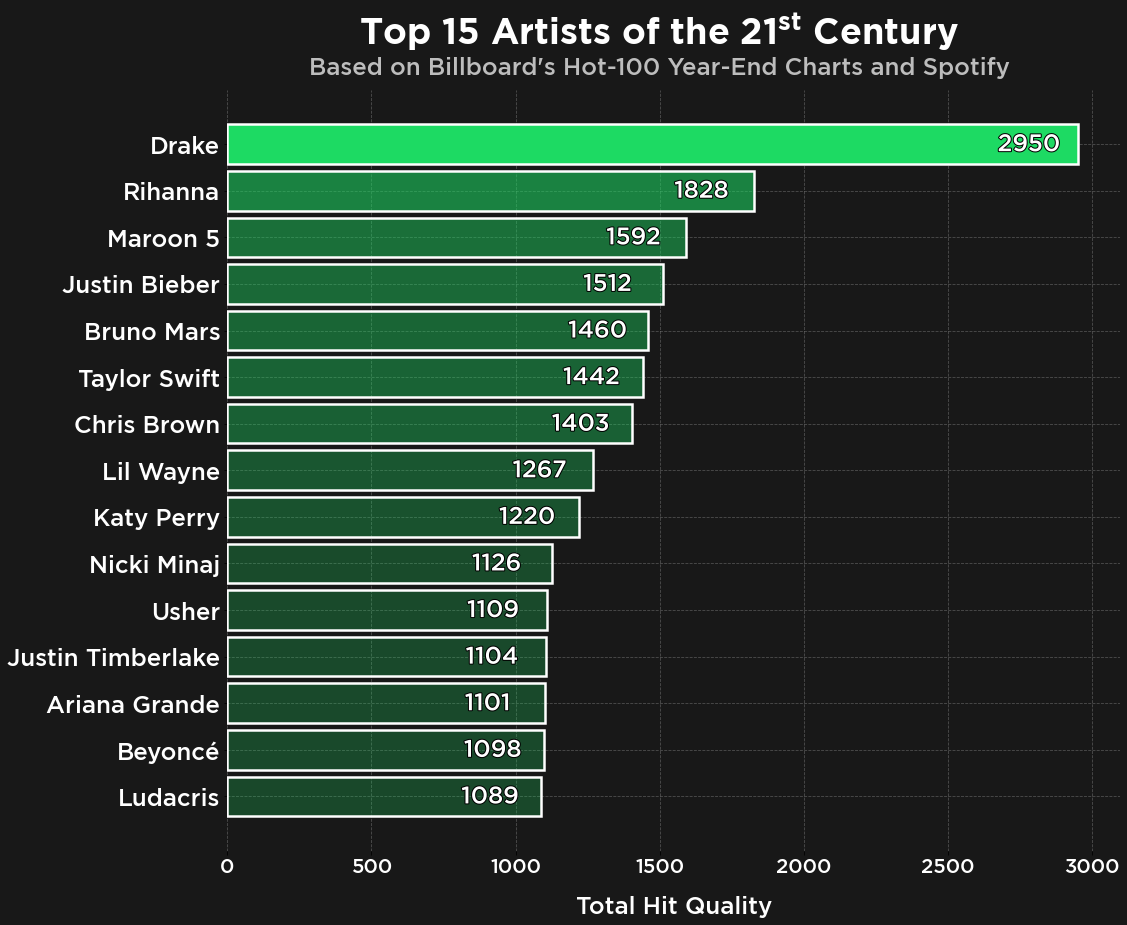

In [ ]:
## Setting the color and linewidth of the spines/borders
mpl.rc('axes',edgecolor='white')
mpl.rc('axes',linewidth='0')

# Adding background color and gridlines
fig,ax = plt.subplots(figsize=(16,14))
fig.set_facecolor('#181818')
ax.patch.set_facecolor('#181818')
ax.set_axisbelow(True)
ax.grid(color='#bdbdbd',which='major',linestyle='--',alpha=0.35)

# Using the normalized hit quality as alpha values
scaler = MinMaxScaler(feature_range=(0.25,1))
alphaList = scaler.fit_transform(top15ArtistsQual21['Hit Quality'].values.reshape(-1,1)).flatten().tolist()

# Inverting the y-axis to show the Artist with most number of top 50 films on the top
ax.invert_yaxis()

# Plotting the bars
for index,row in top15ArtistsQual21.iterrows():
    ax.barh(top15ArtistsQual21['Artist'][index],top15ArtistsQual21['Hit Quality'][index],height=0.85,
            color=spotifyGreen,alpha=alphaList[index])
bars = ax.barh(top15ArtistsQual21['Artist'],top15ArtistsQual21['Hit Quality'],height=0.85,
               color='None',
               edgecolor='w',ls='-',
               linewidth=2.5)

# Labeling each of the bars
ax.bar_label(bars,label_type='edge',padding=-80,fontsize=24,color='w',fontproperties=gothamMed.prop,
             path_effects=pe)

# Customizing the tick-labels for both the axes
plt.yticks(fontsize=24,color='white',fontproperties=gothamMed.prop)
plt.xticks(fontsize=20,color='white',fontproperties=gothamMed.prop)
plt.xlabel('Total Hit Quality',labelpad=20,fontsize=24,color='white',fontproperties=gothamMed.prop)

# Adding the title for the visualization using the fig_text method from highlight_text package
fig_text(s=  '<Top 15 Artists of the $\mathregular{21^{st}}$ Century>\n'+
              '<Based on Billboard\'s Hot-100 Year-End Charts and Spotify>',
         x=.5, y=0.925,
         ha='center',va='center',textalign='center',
         fontsize = 24, fontproperties = gothamMed.prop,
         color = 'w',            
         highlight_textprops = [{'fontsize':36,'fontproperties':gothamBold.prop},
                                {'color':'#bdbdbd'}])

plt.show()

__Inference__:
- Drake is the best artist of the $21^{st}$ century based on the Hit quality metric, by a big margin.

### Average Quality

Finding artists who have highest average hit quality

Calculating average hit quality i.e, total hit quality divided by number of songs and only considering artists who have at least 5 hit songs in the charts to avoid one-hit wonders

In [ ]:
dfArtistRanks['No. of Songs'] = dfArtistRanks['Ranks'].apply(len)
dfArtistRanks['Hit Quality per Song'] = dfArtistRanks['Hit Quality']/dfArtistRanks['No. of Songs']
top15ArtistsAvgQual = dfArtistRanks[dfArtistRanks['No. of Songs']>=5].sort_values('Hit Quality per Song', ascending=False).head(15)
top15ArtistsAvgQual.reset_index(inplace=True, drop=True)

In [ ]:
top15ArtistsAvgQual['Hit Quality per Song'] = top15ArtistsAvgQual['Hit Quality per Song'].round(1)

In [ ]:
top15ArtistsAvgQual['Labels'] = top15ArtistsAvgQual['Hit Quality per Song'].astype(str) + ' - ' + top15ArtistsAvgQual['No. of Songs'].astype(str)

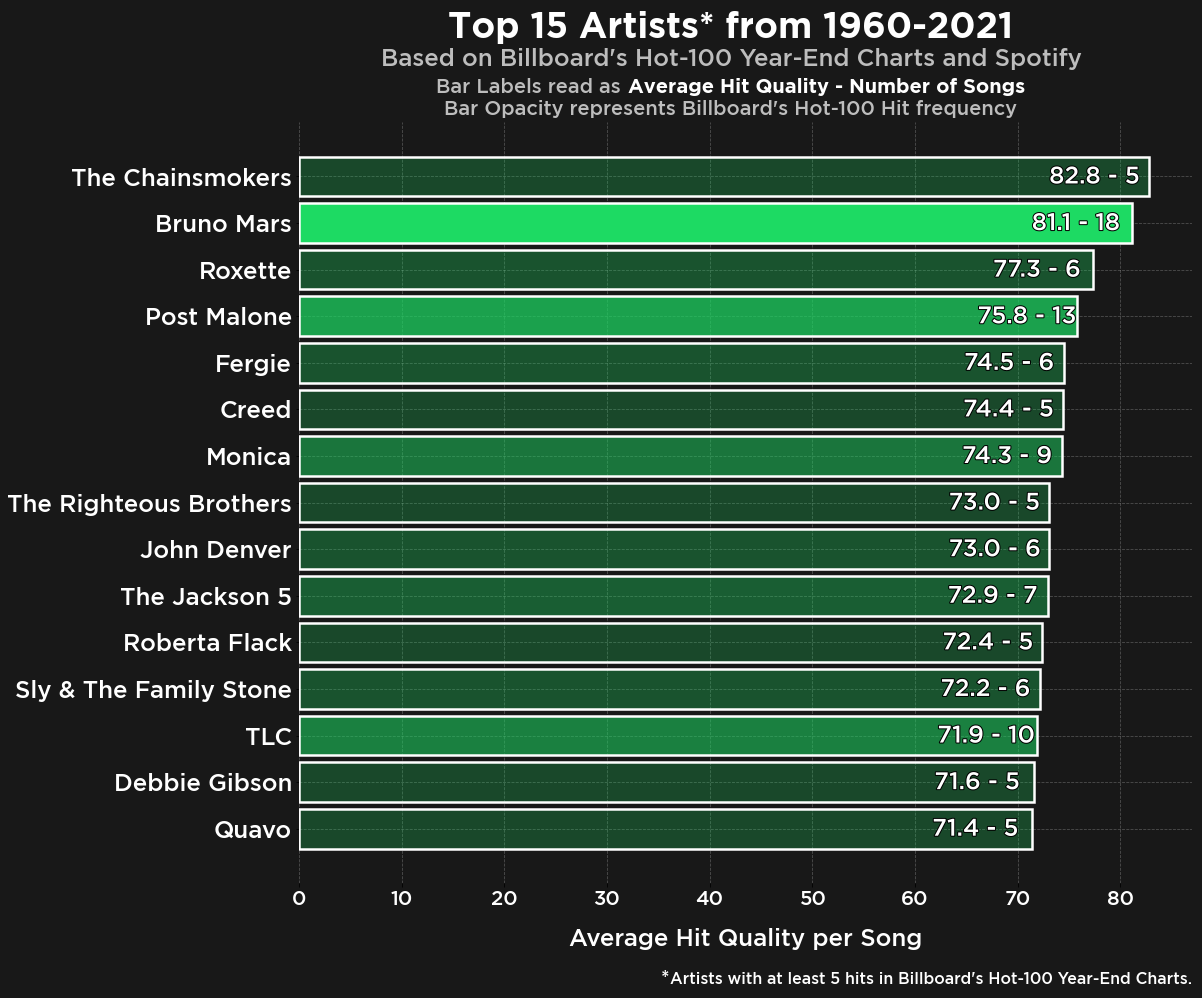

In [ ]:
## Setting the color and linewidth of the spines/borders
mpl.rc('axes',edgecolor='white')
mpl.rc('axes',linewidth='0')

# Adding background color and gridlines
fig,ax = plt.subplots(figsize=(16,14))
fig.set_facecolor('#181818')
ax.patch.set_facecolor('#181818')
ax.set_axisbelow(True)
ax.grid(color='#bdbdbd',which='major',linestyle='--',alpha=0.35)

# Using the normalized hit quality as alpha values
scaler = MinMaxScaler(feature_range=(0.25,1))
alphaList = scaler.fit_transform(top15ArtistsAvgQual['No. of Songs'].values.reshape(-1,1)).flatten().tolist()

# Inverting the y-axis to show the Artist with most number of top 50 films on the top
ax.invert_yaxis()

# Plotting the bars
for index,row in top15ArtistsAvgQual.iterrows():
    ax.barh(top15ArtistsAvgQual['Artist'][index],top15ArtistsAvgQual['Hit Quality per Song'][index],height=0.85,
            color=spotifyGreen,alpha=alphaList[index])
bars = ax.barh(top15ArtistsAvgQual['Artist'],top15ArtistsAvgQual['Hit Quality per Song'],height=0.85,
               color='None',
               edgecolor='w',ls='-',
               linewidth=2.5)

# Labeling each of the bars
ax.bar_label(bars,labels=top15ArtistsAvgQual['Labels'],label_type='edge',padding=-100,fontsize=24,color='w',fontproperties=gothamMed.prop,
             path_effects=pe)

# Customizing the tick-labels for both the axes
plt.yticks(fontsize=24,color='white',fontproperties=gothamMed.prop)
plt.xticks(fontsize=20,color='white',fontproperties=gothamMed.prop)
plt.xlabel('Average Hit Quality per Song',labelpad=20,fontsize=24,color='white',fontproperties=gothamMed.prop)

# Adding the title for the visualization using the fig_text method from highlight_text package
fig_text(s=  '<Top 15 Artists* from 1960-2021>\n'+
             '<Based on Billboard\'s Hot-100 Year-End Charts and Spotify>\n'+
             '<Bar Labels read as> <Average Hit Quality - Number of Songs>\n'
             '<Bar Opacity represents Billboard\'s Hot-100 Hit frequency>\n',
         x=.5, y=0.935,
         ha='center',va='center',textalign='center',
         fontsize = 24, fontproperties = gothamMed.prop,
         color = 'w',            
         highlight_textprops = [{'fontsize':36,'fontproperties':gothamBold.prop},
                                {'color':'#bdbdbd'},
                                {'fontsize':20,'color':'#bdbdbd'},
                                {'fontsize':20,'color':'w','fontproperties':gothamBold.prop},
                                {'fontsize':20,'color':'#bdbdbd'}])


fig_text(s=  '<*>Artists with at least 5 hits in Billboard\'s Hot-100 Year-End Charts.',
         x=.9, y=0.04,
         ha='right',textalign='right',
         fontsize = 16, fontproperties = gothamMed.prop,
         color = 'w',            
         highlight_textprops = [{'fontsize':20,'color':'w'}])


plt.show()

__Inferences:__<br>
- The Chainsmokers have the highest average hit quality, but they have produced only 5 songs in the Billboard charts.
- Bruno Mars, who is a close $2^{nd}$, has the highest quality with __18__ songs in the Hot 100 charts.

## Feature Trends

In [ ]:
featColumns = ['Popularity','Acousticness','Danceability','Energy','Instrumentalness','Loudness','Speechiness','Tempo','Valence']

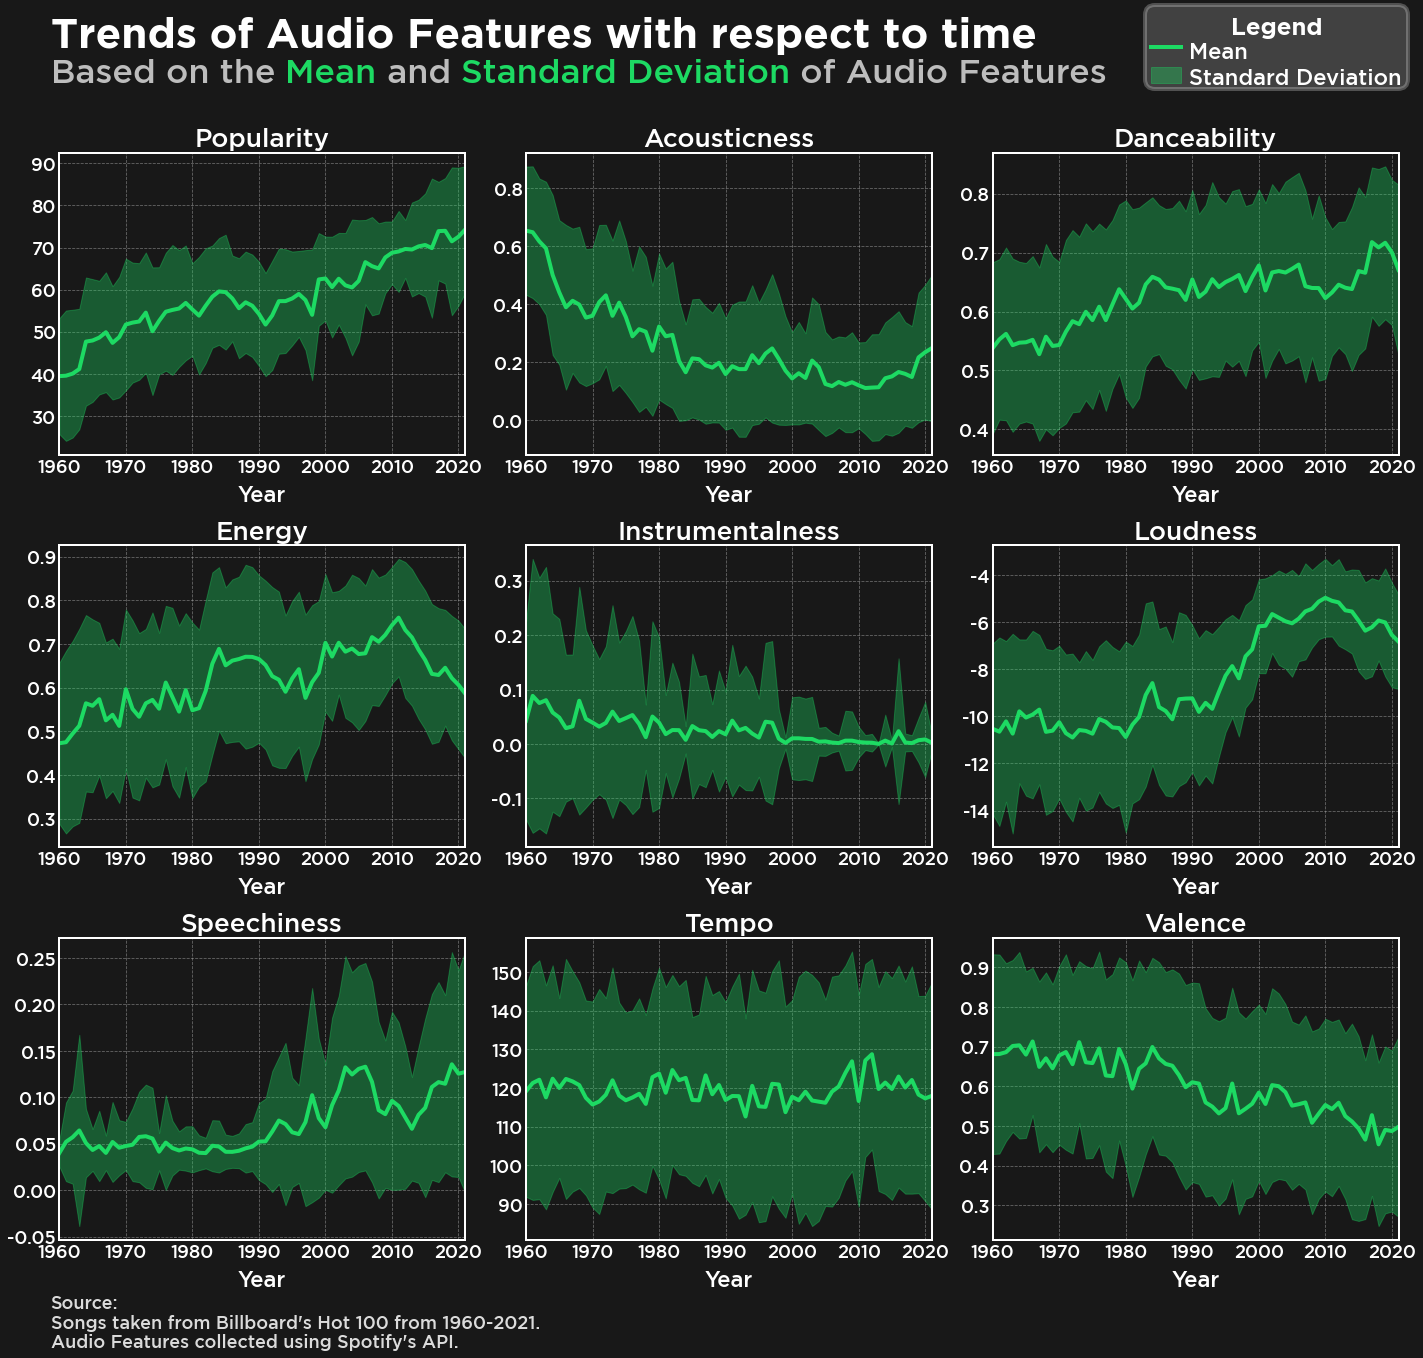

In [ ]:
# Setting the color and linewidth of the spines/borders
mpl.rc('axes',edgecolor='white')
mpl.rc('axes',linewidth='2')

# Creating figure and axes for the visualization using subplots
fig,axs = plt.subplots(3,3,figsize=(24,20))

# Adding background color
fig.set_facecolor('#181818')
# Adjusting the spacing between the subplots
plt.subplots_adjust(hspace=0.3,wspace=0.15)
# Flattening the axs for easier iteration
axs = axs.ravel()

# Enumerating on each of the features
for idx,feature in enumerate(featColumns):
    
    # Adding background color and gridlines for each subplot
    axs[idx].patch.set_facecolor('#181818')
    axs[idx].set_axisbelow(True)
    axs[idx].grid(color='#bdbdbd',which='major',linestyle='--',alpha=0.5)

    yearFeat = df.groupby('Year').agg({feature:['mean','std']}).reset_index()
    yearFeat.columns = ['Year','mean','std']
    
    # Showing the trend of the feature by plotting a the mean rank for every year 
    axs[idx].plot(yearFeat['Year'],yearFeat['mean'],'-',color=spotifyGreen,lw=4,label='Mean')

    # Showing the standard deviation of the trend of the feature by shading 1 standard deviation above & below the mean 
    axs[idx].fill_between(yearFeat['Year'],
                          yearFeat['mean'] - yearFeat['std'],
                          yearFeat['mean'] + yearFeat['std'],
                          color=spotifyGreen, alpha=.35,label='Standard Deviation')

    # Setting the limits for x and y axes 
    axs[idx].set_xlim([1960,2021])
    
    # Setting the genre as title for every subplot
    axs[idx].set_title(feature, fontsize=26, fontproperties=gothamMed.prop, color='w')
    # Setting the x label as year for every subplot
    axs[idx].set_xlabel('Year', fontsize=22, labelpad=10,fontproperties=gothamMed.prop, color='w')
    # Customizing the x and y ticklabels
    for ticklabel in axs[idx].get_yticklabels():
        ticklabel.set_fontproperties(gothamMed.prop)
        ticklabel.set_fontsize(18)
    for ticklabel in axs[idx].get_xticklabels():
        ticklabel.set_fontproperties(gothamMed.prop)
        ticklabel.set_fontsize(18)
    axs[idx].tick_params(axis='both', which='major',labelcolor='w',length=0,color='#2b2b2b')

# Plotting and customizing the legend
legend = axs[idx].legend(ncol=1,bbox_to_anchor=(0.7,4.1),loc='upper center',framealpha=0.25,
                         handleheight=2,handlelength=3)
legend.set_title('Legend')
legend.get_title().set_color("w")
legend.get_title().set_fontproperties(gothamBold.prop)
legend.get_title().set_va('center')
legend.get_title().set_fontsize(24)
legend.get_frame().set_linewidth(4)
legend.get_frame().set_edgecolor('w')
legend.get_frame().set_facecolor('#bdbdbd')
legend.get_frame().set_boxstyle('Round', pad=0.2, rounding_size=1)
for text in legend.get_texts():
    text.set_color("w")
    text.set_fontproperties(gothamMed.prop)
    text.set_ma('center')
    text.set_va('center')
    text.set_fontsize(22)

# Adding the source for the visualization in a text box
fig.text(0.12,0.05,
         s='Source:\nSongs taken from Billboard\'s Hot 100 from 1960-2021.\n'+
           'Audio Features collected using Spotify\'s API.',
         fontsize=18,c='w',ha='left',alpha=0.85,fontproperties=gothamMed.prop)

# Adding the title for the visualization using the fig_text method from highlight_text package
fig_text(s=  '<Trends of Audio Features with respect to time>\n'+
              'Based on the '+'<Mean> '+'and'+' <Standard Deviation> '+'of Audio Features',
         x=.12, y=0.95,
         ha='left',va='center',textalign='left',
         fontsize = 34, fontproperties = gothamMed.prop,
         color = '#bdbdbd',            
         highlight_textprops = [{'fontsize':42,'fontproperties':gothamBold.prop,'color':'w'},
                                {'color':spotifyGreen},
                                {'color':spotifyGreen}])

plt.show()

__Inferences:__
- The latest songs are more popular compared to the older billboard hot-100 songs.
- There is a decrease in acousticness from 1960 - 2021.
- The latest songs have higher danceability, energy and loudness compared to the past.
- There is a slight decrease in valence in 2000s compared to the 1900s i.e., songs with negative overtones are more in the latest billboard charts.

## Genre Trends

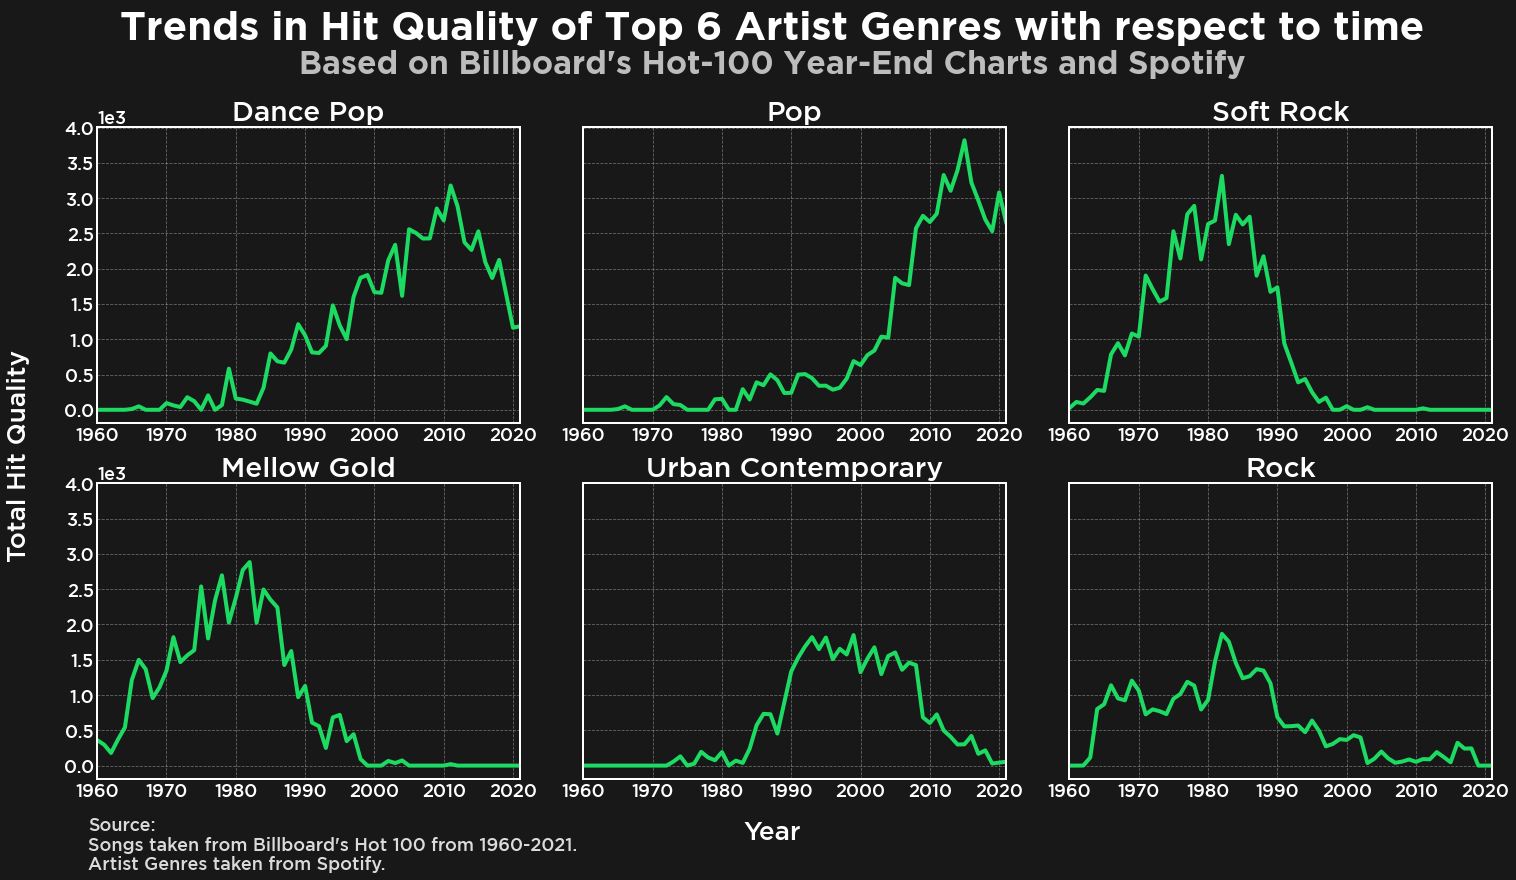

In [ ]:
# Setting the color and linewidth of the spines/borders
mpl.rc('axes',edgecolor='white')
mpl.rc('axes',linewidth='2')

# Creating subplots and adjusting them
fig,axs = plt.subplots(2,3,figsize=(25,12),sharey=True)
plt.subplots_adjust(wspace=0.15)
fig.set_facecolor('#181818')
axs = axs.ravel()

# Getting the top 6 genres based on quality
top6Genres = top15GenresQual[0:6]['Genre'].values

# Looping through each axes
for idx,ax in enumerate(axs):

    # Caclulating the hit quality of genre in each year
    dfGenre = df[df['Genre: '+top6Genres[idx].lower()]==1]
    dfYearGenre = pd.DataFrame()
    dfYearGenre['Year'] = [year for year in range(1960,2022)]
    tempGenre = dfGenre.groupby('Year')['Rank'].apply(list).apply(quality)
    dfYearGenre = dfYearGenre.merge(tempGenre,left_on='Year',right_index=True,how='left')
    dfYearGenre.columns = ['Year','Hit Quality']
    dfYearGenre.fillna(0,inplace=True)

    # Setting axis background color and grids
    ax.set_facecolor('#181818')
    ax.set_axisbelow(True)
    ax.grid(color='#bdbdbd',which='major',linestyle='--',alpha=0.5)
    # Plotting the genre trend
    ax.plot(dfYearGenre['Year'],dfYearGenre['Hit Quality'],'-',color=spotifyGreen,lw=4)
    ax.set_xticks(np.arange(1960,2021,10))
    ax.set_xlim(1960,2021)
    # Setting the genre as title for every subplot
    ax.set_title(top6Genres[idx].title(), fontsize=28, fontproperties=gothamMed.prop, color='w')
    # Customizing the x and y ticklabels
    for ticklabel in ax.get_yticklabels():
        ticklabel.set_fontproperties(gothamMed.prop)
        ticklabel.set_fontsize(18)
    for ticklabel in ax.get_xticklabels():
        ticklabel.set_fontproperties(gothamMed.prop)
        ticklabel.set_fontsize(18)
    ax.tick_params(axis='both', which='major',labelcolor='w',length=0,color='#2b2b2b')
    ax.ticklabel_format(axis='y',style='sci',scilimits=(3,3))
    ax.yaxis.get_offset_text().set_fontproperties(gothamMed.prop)   
    ax.yaxis.get_offset_text().set_fontsize(18)

# Setting the x and y labels    
fig.supxlabel('Year',y=0.05, fontsize=26, fontproperties=gothamMed.prop, color='w')
fig.supylabel('Total Hit Quality',x=0.075, fontsize=26, fontproperties=gothamMed.prop, color='w')

# Adding the source
fig.text(0.12,0.02,
         s='Source:\nSongs taken from Billboard\'s Hot 100 from 1960-2021.\n'+
           'Artist Genres taken from Spotify.',
         fontsize=18,c='w',ha='left',alpha=0.85,fontproperties=gothamMed.prop)


# Adding the title for the visualization using the fig_text method from highlight_text package
fig_text(s=  'Trends in Hit Quality of Top 6 Artist Genres with respect to time\n'+
              '<Based on Billboard\'s Hot-100 Year-End Charts and Spotify>',
         x=.5, y=0.975,
         ha='center',va='center',textalign='center',
         fontsize = 40, fontproperties = gothamBold.prop,
         color = 'w',
         highlight_textprops = [{'fontsize':32,'fontproperties':gothamBold.prop,'color':'#bdbdbd'}])


__Inferences:__
- There is an increase in trend of Pop and Dance Pop genres from the 1980s.
- Soft Rock and Mellow Gold genres are no longer popular as they were in the 1900s.
- Urban Contemporary genre gained the trend in 1980s but decreased in the 2010s.

## Artist Trends

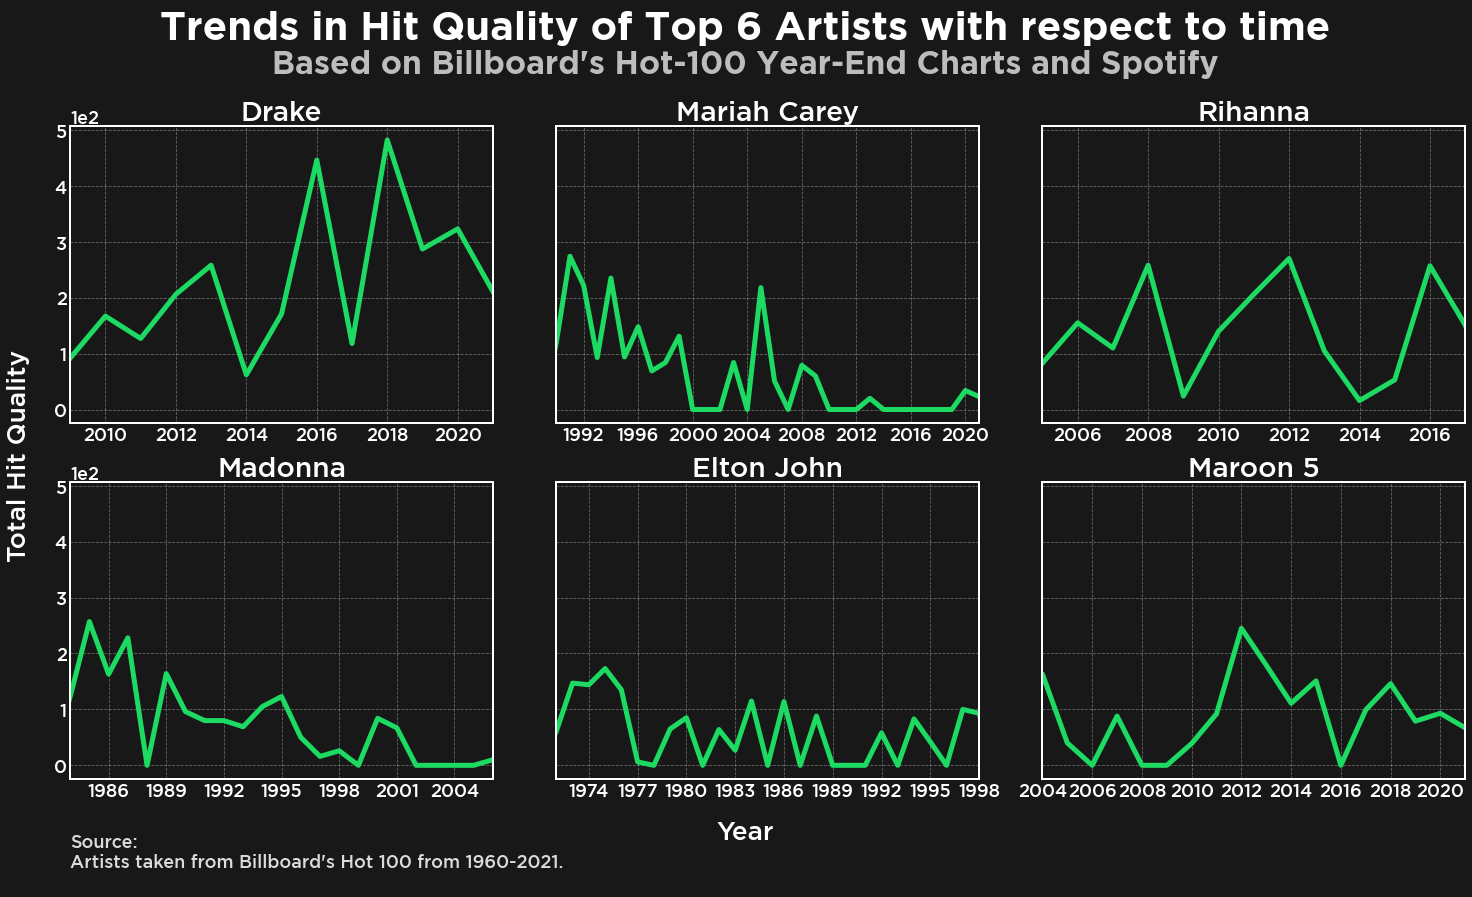

In [ ]:
# Setting the color and linewidth of the spines/borders
mpl.rc('axes',edgecolor='white')
mpl.rc('axes',linewidth='2')

# Creating subplots and adjusting them
fig,axs = plt.subplots(2,3,figsize=(25,12),sharey=True)
plt.subplots_adjust(wspace=0.15)
fig.set_facecolor('#181818')
axs = axs.ravel()

# Getting the top 6 genres based on quality
top6Artists = top15ArtistsQual[0:6]['Artist'].values

# Looping through each axes
for idx,ax in enumerate(axs):
    
    # Caclulating the hit quality of artist in each year
    dfArtist = df[df['Artist: '+top6Artists[idx]]==1]
    dfYearArtist = pd.DataFrame()
    dfYearArtist['Year'] = [year for year in range(1960,2022)]
    tempArtist = dfArtist.groupby('Year')['Rank'].apply(list).apply(quality)
    dfYearArtist = dfYearArtist.merge(tempArtist,left_on='Year',right_index=True,how='left')
    dfYearArtist.columns = ['Year','Hit Quality']
    dfYearArtist.fillna(0,inplace=True)

    # Setting axis background color and grids
    ax.set_facecolor('#181818')
    ax.set_axisbelow(True)
    ax.grid(color='#bdbdbd',which='major',linestyle='--',alpha=0.5)

    # Plotting the artist trend
    ax.plot(dfYearArtist['Year'],dfYearArtist['Hit Quality'],'-',color=spotifyGreen,lw=5)
    minYear = min(dfYearArtist[dfYearArtist['Hit Quality']>0]['Year'])
    maxYear = max(dfYearArtist[dfYearArtist['Hit Quality']>0]['Year'])
    ax.set_xticks(np.arange(minYear,maxYear,(maxYear-minYear)/20))
    ax.set_xlim([minYear,maxYear])
    
    # Setting the Artist as title for every subplot
    ax.set_title(top6Artists[idx].title(), fontsize=28, fontproperties=gothamMed.prop, color='w')

    # Customizing the x and y ticklabels
    for ticklabel in ax.get_yticklabels():
        ticklabel.set_fontproperties(gothamMed.prop)
        ticklabel.set_fontsize(18)
    for ticklabel in ax.get_xticklabels():
        ticklabel.set_fontproperties(gothamMed.prop)
        ticklabel.set_fontsize(18)
    ax.tick_params(axis='both', which='major',labelcolor='w',length=0,color='#2b2b2b')
    ax.xaxis.set_major_locator(MaxNLocator('auto',integer=True))
    ax.ticklabel_format(axis='y',style='sci',scilimits=(2,2))
    ax.yaxis.get_offset_text().set_fontproperties(gothamMed.prop)   
    ax.yaxis.get_offset_text().set_fontsize(18)
    
# Setting the x and y labels    
fig.supxlabel('Year',y=0.05, fontsize=26, fontproperties=gothamMed.prop, color='w')
fig.supylabel('Total Hit Quality',x=0.09, fontsize=26, fontproperties=gothamMed.prop, color='w')

# Adding the source
fig.text(0.125,0.0,
         s='Source:\nArtists taken from Billboard\'s Hot 100 from 1960-2021.\n',
         fontsize=18,c='w',ha='left',alpha=0.85,fontproperties=gothamMed.prop)

# Adding the title for the visualization using the fig_text method from highlight_text package
fig_text(s=  'Trends in Hit Quality of Top 6 Artists with respect to time\n'+
              '<Based on Billboard\'s Hot-100 Year-End Charts and Spotify>',
         x=.5, y=0.975,
         ha='center',va='center',textalign='center',
         fontsize = 40, fontproperties = gothamBold.prop,
         color = 'w',
         highlight_textprops = [{'fontsize':32,'fontproperties':gothamBold.prop,'color':'#bdbdbd'}])
plt.show()

__Inferences:__
- Drake has been appearing on the billboards since 2006 and has been producing hits of highest qulaity since then.
- Madonna and Elton John produced the best hits in the 1900s.


## Audio Profiles of Top 6 Artists

Audio Profiles are calculated using the Mean Percentile Rank of the Audio Features. <br>
A percentile rank indicates the percentage of scores in the frequency distribution that are less than that score.<br>
For example, a mean percentile rank of 19 for Acousticness for the artist indicates that 19% of the songs in our database fall below the mean acousticness of the songs.

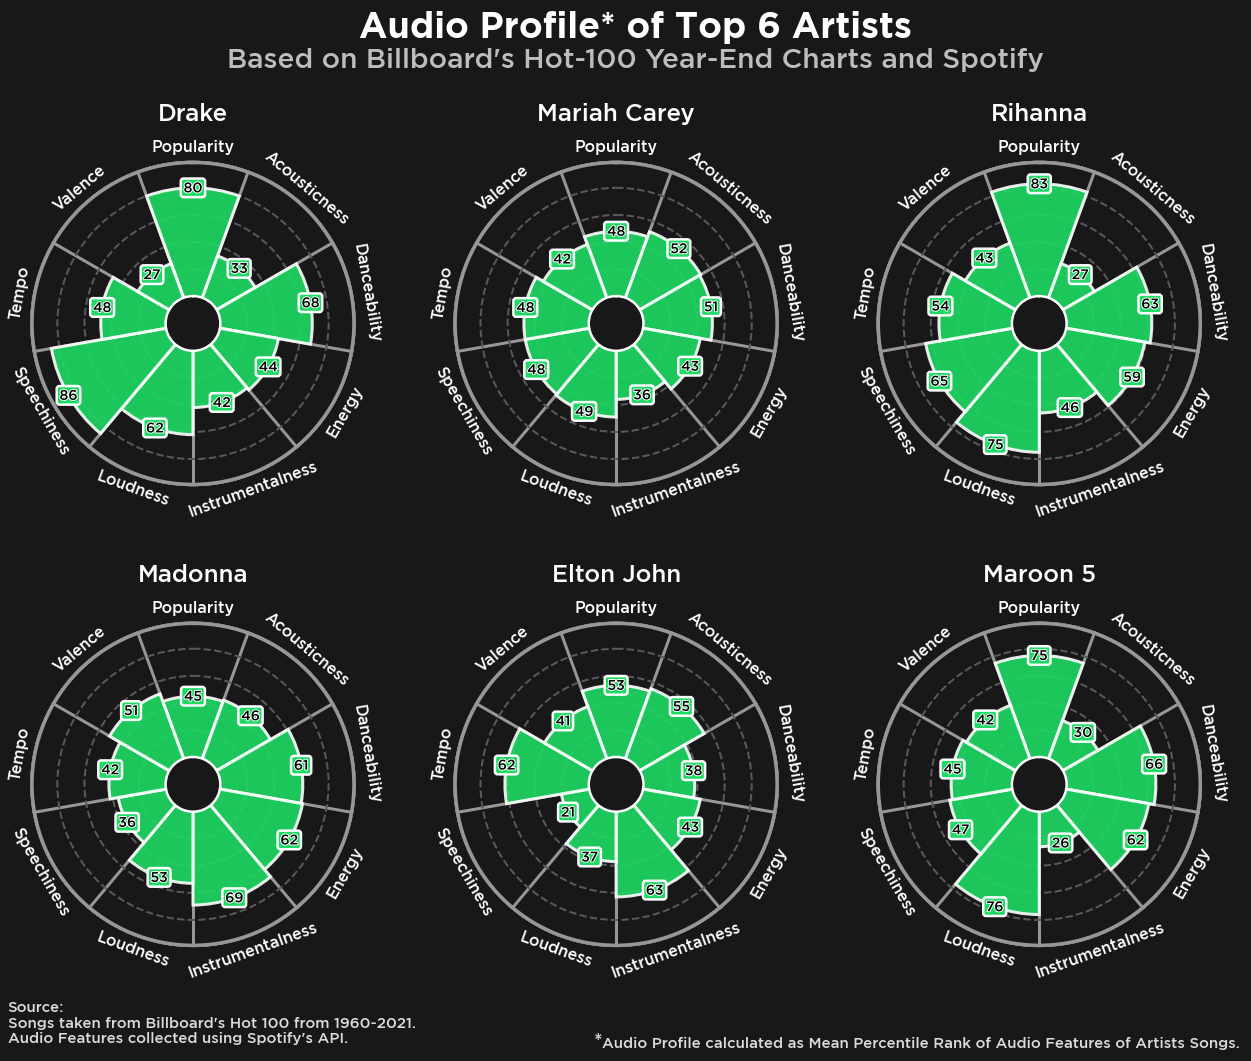

In [ ]:
# Setting the color and linewidth of the spines/borders
mpl.rc('axes',edgecolor='white')
mpl.rc('axes',linewidth='2')

# Creating subplots as polar plots and adjusting them
fig,axs = plt.subplots(2,3,figsize=(21,15),subplot_kw=dict(projection='polar'))
plt.subplots_adjust(wspace=0.3,hspace=0.3)
fig.set_facecolor('#181818')
axs = axs.ravel()

# List of features for the pizza chart
featColumns = ['Popularity','Acousticness','Danceability','Energy','Instrumentalness','Loudness','Speechiness','Tempo','Valence']

# Font colors and slice colors for Pizza chart
slice_colors = [spotifyGreen]*9
text_colors = ['k']*9

# instantiating PyPizza class
baker = PyPizza(
                    params=featColumns,             
                    background_color="#181818",     
                    straight_line_color="#979797",  
                    straight_line_lw=3,             
                    straight_line_ls='-',
                    last_circle_color="#979797",    
                    last_circle_lw=7,               
                    last_circle_ls='-',
                    other_circle_lw=2,              
                    other_circle_color='#595959',
                    other_circle_ls='--',
                    inner_circle_size=20            
                )

# Path effects object for getting the outline/stroke for text
pe1 = path_effect_stroke(linewidth=2, foreground="w")

# Looping through each axes
for idx,ax in enumerate(axs):
    # Getting data for each artist
    artistData = df[df['Artist: '+top6Artists[idx]]==1]
    artistData.reset_index(drop=True,inplace=True)
    artistData = artistData[featColumns]
    # Setting artist as title
    ax.set_title(top6Artists[idx].title(), pad=40,fontsize=24, fontproperties=gothamMed.prop, color='w')
    # Calculating mean percentile ranks for each feature
    values = []
    for idx in range(len(artistData)):
        songFeats = list(artistData.loc[idx])
        valuesSong = []
        for x in range(len(featColumns)):
            valuesSong.append(math.floor(scipy.stats.percentileofscore(df[featColumns[x]],songFeats[x])))
        values.append(valuesSong)

    values = np.round(np.mean(values, axis=0)).astype(int)
    # Plotting the Pizza chart
    baker.make_pizza(
                        values,                          
                        figsize=(6, 8),
                        ax=ax,
                        color_blank_space=['#181818']*9, 
                        slice_colors=slice_colors,       
                        value_bck_colors=slice_colors,   
                        param_location=110,
                        blank_alpha=1,                 
                        kwargs_slices=dict(edgecolor="w", zorder=2, linewidth=3,alpha=.9,linestyle='-'),                               
                        kwargs_params=dict(color="w", fontsize=16, fontweight='bold',
                                           va="center",fontproperties=gothamMed.prop),
                        kwargs_values=dict(color="k", fontsize=14,va='center',path_effects=pe1,
                                           zorder=3,fontproperties=gothamMed.prop,
                                           bbox=dict(edgecolor="w",boxstyle="round,pad=0.2", lw=2.5))                              
                      )
# Setting the title  
fig_text(s=  'Audio Profile* of Top 6 Artists\n'+
             '<Based on Billboard\'s Hot-100 Year-End Charts and Spotify>\n',
         x=.525, y=0.975,
         ha='center',va='center',textalign='center',
         fontsize = 36, fontproperties = gothamBold.prop,
         color = 'w',
         highlight_textprops = [{'fontsize':28,'fontproperties':gothamMed.prop,'color':'#bdbdbd'}])
# Text Annotations
fig_text(s=  '<*>Audio Profile calculated as Mean Percentile Rank of Audio Features of Artists Songs.',
         x=.925, y=0.06,alpha=0.85,
         ha='right',textalign='right',
         fontsize = 15, fontproperties = gothamMed.prop,
         color = 'w',            
         highlight_textprops = [{'fontsize':20,'color':'w'}])

fig.text(0.11,0.05,
         s='Source:\nSongs taken from Billboard\'s Hot 100 from 1960-2021.\n'+
           'Audio Features collected using Spotify\'s API.',
         fontsize=15,c='w',ha='left',alpha=0.85,fontproperties=gothamMed.prop)

plt.show()

## Top 5 Artists of Top 6 Genres

6it [00:06,  1.07s/it]


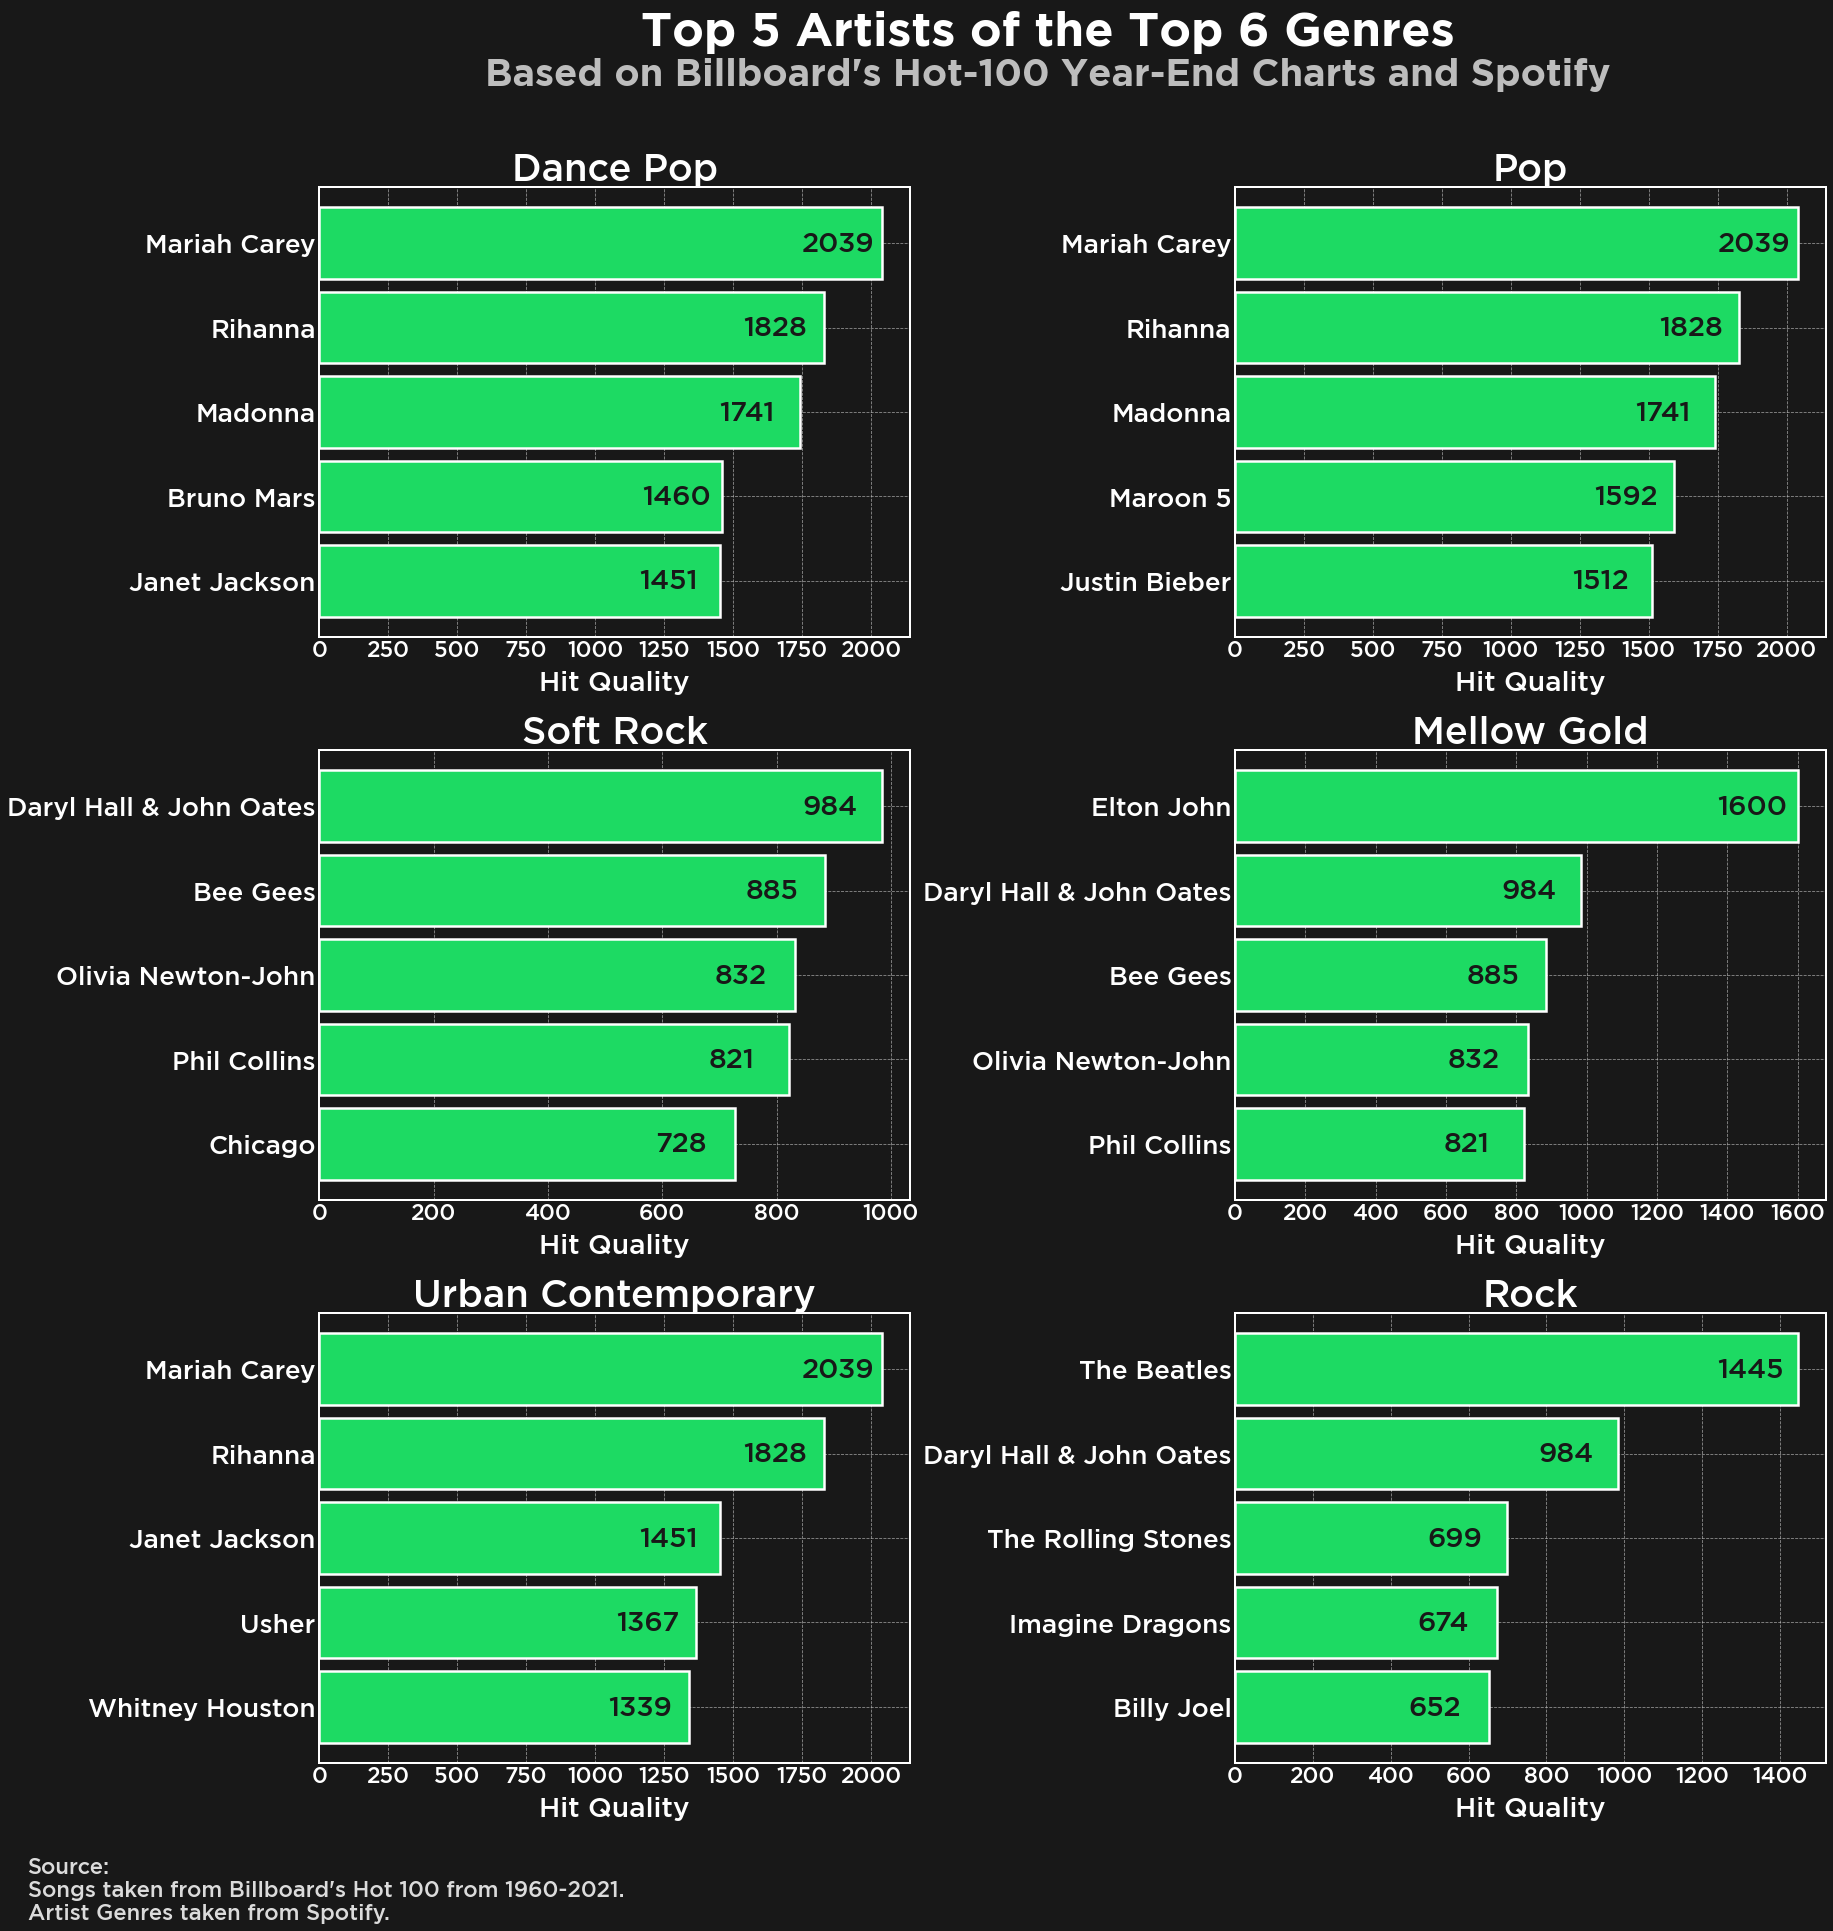

In [ ]:
# Setting the color and linewidth of the spines/borders
mpl.rc('axes',edgecolor='white')
mpl.rc('axes',linewidth='2')

# Creating subplots and adjusting them
fig,axs = plt.subplots(3,2,figsize=(27,29))
plt.subplots_adjust(wspace=0.55,hspace=0.25)
fig.set_facecolor('#181818')
axs = axs.ravel()

# Looping through each acis 
for idx,ax in tqdm(enumerate(axs)):

    dfGenre = df[df['Genre: '+top6Genres[idx].lower()]==1]
    genreArtists = dfGenre.columns[dfGenre.columns.str.contains('Artist: ')].values.tolist()

    # Calcualting all artists quality for each genre 
    artistName = []
    artistRanks = []
    for artist in genreArtists:
        artistName.append(artist)
        artistRanks.append(dfGenre[dfGenre[artist]==1]['Rank'].values.tolist())

    dfGenreArtistRanks = pd.DataFrame()
    dfGenreArtistRanks['Artist'] = artistName
    dfGenreArtistRanks['Ranks'] = artistRanks

    dfGenreArtistRanks['Hit Quality'] = dfGenreArtistRanks['Ranks'].apply(quality)

    # Getting top 5 artists of each genre
    top5GenreArtists = dfGenreArtistRanks.sort_values('Hit Quality',ascending=False).head(5)

    top5GenreArtists['Artist'] = top5GenreArtists['Artist'].str.replace('Artist: ','')
    
    # Setting axis background color and grid
    ax.patch.set_facecolor('#181818')
    ax.set_axisbelow(True)
    ax.grid(color='#bdbdbd',which='major',linestyle='--',alpha=0.75)
    # Inverting the y-axis
    ax.invert_yaxis()
    
    # Plotting the horizontal bars for each Artist
    bars = ax.barh(top5GenreArtists['Artist'],top5GenreArtists['Hit Quality'],height=0.85,
                   color=spotifyGreen,
                   edgecolor='w',ls='-',
                   linewidth=2.5)

    # Labeling each of the bars
    ax.bar_label(bars,label_type='edge',padding=-80,fontsize=28,color='#181818',fontproperties=gothamMed.prop,)
    # Setting the Artist as title for every subplot
    ax.set_title(top6Genres[idx].title(), fontsize=38, fontproperties=gothamMed.prop, color='w')
    # Customizing the x and y ticklabels
    for ticklabel in ax.get_yticklabels():
        ticklabel.set_fontproperties(gothamMed.prop)
        ticklabel.set_fontsize(26)
    for ticklabel in ax.get_xticklabels():
        ticklabel.set_fontproperties(gothamMed.prop)
        ticklabel.set_fontsize(22)
    ax.tick_params(axis='both', which='major',labelcolor='w',length=0,color='#2b2b2b')
    ax.set_xlabel('Hit Quality', fontsize=28, labelpad=10,fontproperties=gothamMed.prop, color='w')

# Adding text annotation for source
fig.text(-0.025,0.05,
         s='Source:\nSongs taken from Billboard\'s Hot 100 from 1960-2021.\n'+
           'Artist Genres taken from Spotify.',
         fontsize=22,c='w',ha='left',alpha=0.85,fontproperties=gothamMed.prop)    
# Setting the title    
fig_text(s=  'Top 5 Artists of the Top 6 Genres\n'+
              '<Based on Billboard\'s Hot-100 Year-End Charts and Spotify>',
         x=.5, y=0.945,
         ha='center',va='center',textalign='center',
         fontsize = 48, fontproperties = gothamBold.prop,
         color = 'w',
         highlight_textprops = [{'fontsize':38,'fontproperties':gothamBold.prop,'color':'#bdbdbd'}])
plt.show()

## Helper Functions for more exploration

Function to plot Genre trend with respect to time

In [ ]:
def plotGenre(genre):
    dfGenre = df[df['Genre: '+genre.lower()]==1]
    dfYearGenre = pd.DataFrame()
    dfYearGenre['Year'] = [year for year in range(1960,2022)]
    tempGenre = dfGenre.groupby('Year')['Rank'].apply(list).apply(quality)
    dfYearGenre = dfYearGenre.merge(tempGenre,left_on='Year',right_index=True,how='left')
    dfYearGenre.columns = ['Year','Hit Quality']
    dfYearGenre.fillna(0,inplace=True)

    # Setting the color and linewidth of the spines/borders
    mpl.rc('axes',edgecolor='white')
    mpl.rc('axes',linewidth='2')

    fig,ax = plt.subplots(figsize=(8,6))
    # Adding background color
    fig.set_facecolor('#181818')
    ax.set_facecolor('#181818')
    ax.set_axisbelow(True)
    ax.grid(color='#bdbdbd',which='major',linestyle='--',alpha=0.5)

    ax.plot(dfYearGenre['Year'],dfYearGenre['Hit Quality'],'-',color=spotifyGreen,lw=4)
    # Setting the limits for x and y axes 
    ax.set_xlim([min(dfYearGenre['Year']),2021])

    # Setting the genre as title for every subplot
    ax.set_title('Trend of '+genre.title()+' songs\nwith respect to time', fontsize=26, fontproperties=gothamMed.prop, color='w')
    # Setting the x label as year for every subplot
    ax.set_xlabel('Year', fontsize=22, labelpad=10,fontproperties=gothamMed.prop, color='w')
    ax.set_ylabel('Hit Quality', fontsize=22, labelpad=10,fontproperties=gothamMed.prop, color='w')
    # Customizing the x and y ticklabels
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    for ticklabel in ax.get_yticklabels():
        ticklabel.set_fontproperties(gothamMed.prop)
        ticklabel.set_fontsize(18)
    for ticklabel in ax.get_xticklabels():
        ticklabel.set_fontproperties(gothamMed.prop)
        ticklabel.set_fontsize(18)
    ax.tick_params(axis='both', which='major',labelcolor='w',length=0,color='#2b2b2b')

    plt.show()

Function to plot Artist's trend with respect to time

In [ ]:
def plotArtist(Artist):
    dfArtist = df[df['Artist: '+Artist]==1]
    dfYearArtist = pd.DataFrame()
    dfYearArtist['Year'] = [year for year in range(1960,2022)]
    tempArtist = dfArtist.groupby('Year')['Rank'].apply(list).apply(quality)
    dfYearArtist = dfYearArtist.merge(tempArtist,left_on='Year',right_index=True,how='left')
    dfYearArtist.columns = ['Year','Hit Quality']
    dfYearArtist['Year'] = dfYearArtist['Year'].astype(int) 
    dfYearArtist.fillna(0,inplace=True)
        
    # Setting the color and linewidth of the spines/borders
    mpl.rc('axes',edgecolor='white')
    mpl.rc('axes',linewidth='2')

    fig,ax = plt.subplots(figsize=(7,6))
    # Adding background color
    fig.set_facecolor('#181818')
    ax.set_facecolor('#181818')
    ax.set_axisbelow(True)
    ax.grid(color='#bdbdbd',which='major',linestyle='--',alpha=0.5)

    ax.plot(dfYearArtist['Year'],dfYearArtist['Hit Quality'],'-',color=spotifyGreen,lw=4)
    # Setting the limits for x and y axes 
    minYear = min(dfYearArtist[dfYearArtist['Hit Quality']>0]['Year'])
    ax.set_xlim([minYear,2021])
    ax.set_xticks(np.arange(minYear,2021,(2021-minYear)/10))

    
    # Setting the Artist as title for every subplot
    ax.set_title('Trend of '+Artist+'\'s songs\nwith respect to time', fontsize=26, fontproperties=gothamMed.prop, color='w')
    # Setting the x label as year for every subplot
    ax.set_xlabel('Year', fontsize=22, labelpad=10,fontproperties=gothamMed.prop, color='w')
    ax.set_ylabel('Hit Quality', fontsize=22, labelpad=10,fontproperties=gothamMed.prop, color='w')
    ax.xaxis.set_major_locator(MaxNLocator('auto',integer=True))
    
    # Customizing the x and y ticklabels
    for ticklabel in ax.get_yticklabels():
        ticklabel.set_fontproperties(gothamMed.prop)
        ticklabel.set_fontsize(14)
    for ticklabel in ax.get_xticklabels():
        ticklabel.set_fontproperties(gothamMed.prop)
        ticklabel.set_fontsize(14)
    ax.tick_params(axis='both', which='major',labelcolor='w',length=0,color='#2b2b2b')

    plt.show()

Function to get the percentile rank of features of a song

In [ ]:
def getSongValues(songName):
    featColumns = ['Popularity','Acousticness','Danceability','Energy','Instrumentalness','Loudness','Speechiness','Tempo','Valence']
    songProfile = df[df['Song Name'].str.contains(songName)]
    songProfile.reset_index(inplace=True,drop=True)

    songFeats = songProfile.filter(featColumns)
    songFeats = list(songFeats.loc[0])

    values = []
    for x in range(len(featColumns)):
        values.append(math.floor(scipy.stats.percentileofscore(df[featColumns[x]],songFeats[x])))
        
    return values

Function to get the mean percentile rank of features for an artist

In [ ]:
def getArtistValues(artist):
    featColumns = ['Popularity','Acousticness','Danceability','Energy','Instrumentalness','Loudness','Speechiness','Tempo','Valence']
    artistData = df[df['Artist: '+artist]==1][featColumns]
    artistData.reset_index(drop=True,inplace=True)

    values = []
    for idx in range(len(artistData)):
        songFeats = list(artistData.loc[idx])
        valuesSong = []
        for x in range(len(featColumns)):
            valuesSong.append(math.floor(scipy.stats.percentileofscore(df[featColumns[x]],songFeats[x])))
        values.append(valuesSong)

    return np.round(np.mean(values, axis=0)).astype(int)

Function to get the mean percentile rank of features for a genre

In [ ]:
def getGenreValues(genre):
    featColumns = ['Popularity','Acousticness','Danceability','Energy','Instrumentalness','Loudness','Speechiness','Tempo','Valence']
    genreData = df[df['Genre: '+genre.lower()]==1][featColumns]
    genreData.reset_index(drop=True,inplace=True)

    values = []
    for idx in range(len(genreData)):
        songFeats = list(genreData.loc[idx])
        valuesSong = []
        for x in range(len(featColumns)):
            valuesSong.append(math.floor(scipy.stats.percentileofscore(df[featColumns[x]],songFeats[x])))
        values.append(valuesSong)

    return np.round(np.mean(values, axis=0)).astype(int)

Function to plot Pizza chart given the percentile ranks

In [ ]:
def plotPizza(values):
    featColumns = ['Popularity','Acousticness','Danceability','Energy','Instrumentalness','Loudness','Speechiness','Tempo','Valence']
    slice_colors = [spotifyGreen]*9
    text_colors = ['k']*9

    # instantiate PyPizza class
    baker = PyPizza(
                        params=featColumns,             
                        background_color="w",     
                        straight_line_color="#979797",  
                        straight_line_lw=3,             
                        straight_line_ls='-',
                        last_circle_color="#979797",    
                        last_circle_lw=7,               
                        last_circle_ls='-',
                        other_circle_lw=2,              
                        other_circle_color='#bdbdbd',
                        other_circle_ls='--',
                        inner_circle_size=20            
                    )

    pe1 = path_effect_stroke(linewidth=2, foreground="w")

    # plot pizza
    fig, ax = baker.make_pizza(
                                values,                          
                                figsize=(6, 8),                  
                                color_blank_space=['w']*9, 
                                slice_colors=slice_colors,       
                                value_bck_colors=slice_colors,   
                                param_location=113,
                                blank_alpha=1,                 
                                kwargs_slices=dict(edgecolor="k", zorder=2, linewidth=3,alpha=.9,linestyle='-'),                               
                                kwargs_params=dict(color="k", fontsize=18, fontweight='bold',path_effects=pe1,
                                                   va="center",fontproperties=gothamMed.prop),
                                kwargs_values=dict(color="k", fontsize=16,path_effects=pe1,va='center',
                                                   zorder=3,fontproperties=gothamMed.prop,
                                                   bbox=dict(edgecolor="k",boxstyle="round,pad=0.2", lw=2.5))                              
                              )
    
    ax.patch.set_facecolor('None')
    fig.set_alpha = 0.0
    fig.patch.set_visible(False)

#     ax_image = add_image(img, fig, left=0.34, bottom=0.425, width=0.35, height=0.155) 
    plt.show()

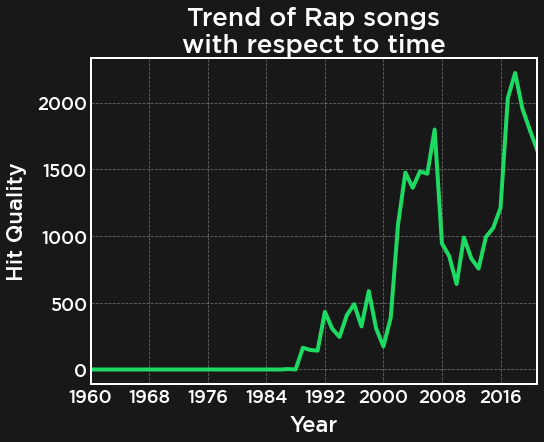

In [ ]:
plotGenre('rap')

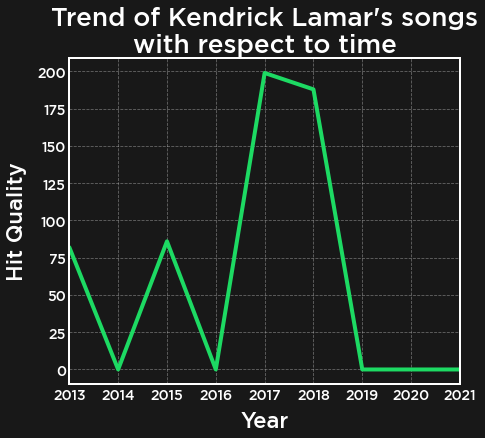

In [ ]:
plotArtist('Kendrick Lamar')

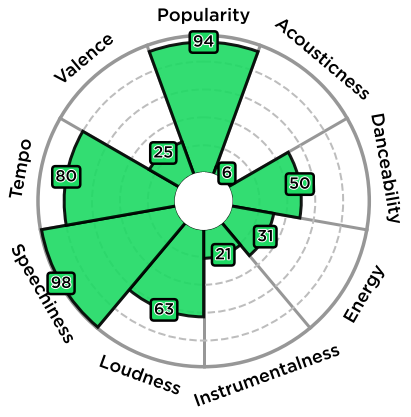

In [ ]:
plotPizza(getSongValues('DNA'))

# Natural Language Processing on Lyrics

Getting the DataFrame with Song, Artist and Lyrics from main dataframe

In [ ]:
df = df[['Song','Artist','Lyrics']]

In [ ]:
# loading and adding pipeline for NLP``
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

In [ ]:
# example for nlp
doc = nlp('Hello I am not happy')
sentiment = doc._.blob.polarity

In [ ]:
# sentiment ranges from -1 to 1, 0 being neutral, -1 unhappy, 1 happy
sentiment

-0.4

In [ ]:
# creating NLP column
df['Lyrics_nlp'] = np.nan

In [ ]:
# adding sentiment analysis values in the data
for idx, lyrics in enumerate(df['Lyrics']):
    doc = nlp(lyrics)
    df['Lyrics_nlp'].iloc[idx] = doc._.blob.polarity

/var/folders/5p/q6yw2d6s54b12pxt0c13tgz40000gn/T/ipykernel_4884/3174260226.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lyrics_nlp'].iloc[idx] = doc._.blob.polarity


In [ ]:
df

Song  \
0             Theme from A Summer Place   
1                      He'll Have to Go   
2                         Cathy's Clown   
3                          Running Bear   
4                            Teen Angel   
...                                 ...   
5617              Single Saturday Night   
5618           Things a Man Oughta Know   
5619                          Tombstone   
5620  Drinkin' Beer. Talkin' God. Amen.   
5621                         Todo de Ti   

                                         Artist  \
0                                   Percy Faith   
1                                    Jim Reeves   
2                           The Everly Brothers   
3                                Johnny Preston   
4                                  Mark Dinning   
...                                         ...   
5617                              Cole Swindell   
5618                              Lainey Wilson   
5619                                   Rod Wave   
5620  Chase Rice featuring Florida Georgia Line   
5621                             Rauw Alejandro   

                                                 Lyrics  Lyrics_nlp  
0     There's a summer place\nWhere it may rain or s...    0.394444  
1     Put your sweet lips a little closer to the pho...    0.071991  
2     Don't want your love anymore\nDon't want your ...    0.291667  
3     On the bank of the river stood Running Bear, y...    0.171389  
4     Teen angel, teen angel, teen angel, ooh\nThat ...    0.185051  
...                                                 ...         ...  
5617  I was out taking shots\nThrowing down at the s...    0.086135  
5618  I can hook a trailer on a two-inch hitch\nI ca...   -0.010905  
5619  When this shit over, it's over\nI don't know w...   -0.060702  
5620  Firewood crackle in the fall air\nRed dirt pla...   -0.207990  
5621  One, two\nOne, two, three\nEl viento soba tu c...   -0.017857  

[5622 rows x 4 columns]

In [ ]:
# top 10 most negative sentiment songs
df.sort_values(by='Lyrics_nlp')[:10]

Song                        Artist  \
2519                 Nasty                 Janet Jackson   
4110  Let's Get It Started           The Black Eyed Peas   
5607              Yonaguni                     Bad Bunny   
900        Bad Moon Rising  Creedence Clearwater Revival   
3082  Everything About You                  Ugly Kid Joe   
3602          Cruel Summer                   Ace of Base   
2345          Cruel Summer                    Bananarama   
3173              Bad Boys                  Inner Circle   
5043  You Know You Like It      DJ Snake and AlunaGeorge   
1602            Evil Woman      Electric Light Orchestra   

                                                 Lyrics  Lyrics_nlp  
2519  Gimme a beat!\nSittin' in the movie show\nThin...   -0.773759  
4110  Party, party\nParty, party\nParty, party\nPart...   -0.750000  
5607  Yeah-yeah-yeah-yeah\nYeah-yeah-yeah-yeah-yeah-...   -0.700000  
900   I see the bad moon a-risin'\nI see trouble on ...   -0.675000  
3082  "Are you the guys on the beach that hate every...   -0.616977  
3602  Hot summer streets and the pavements are burni...   -0.566622  
2345  Hot summer streets and the pavements are burni...   -0.566622  
3173  Bad boys, whatcha want\nWatcha want, whatcha g...   -0.560677  
5043  Some people want me to be heads or tails\nI sa...   -0.558796  
1602  You made a fool of me\nBut them broken dreams ...   -0.538830

In [ ]:
# viewing lyrics of 10th most negative song
print(df.iloc[1602, -2])

You made a fool of me
But them broken dreams have got to end
Hey woman, you got the blues
Yes you ain't got no one else to use
There's an open road that leads nowhere
So just make some miles between here and there
There's a hole in my head where the rain comes in
You took my body and played to win
Ha ha woman it's a crying shame
But you ain't got nobody else to blame
Evil woman, evil woman
Evil woman, evil woman
Rolled in from another town
Hit some gold too hot to settle down
But a fool and his money soon go separate ways
And you found that fool lyin' in a daze
Ha ha woman, what you gonna do?
You destroyed all the virtues that the Lord gave you
It's so good that you're feeling pain
Yes you better get your face on board the very next train
Evil woman, evil woman
Evil woman, evil woman
Evil woman, evil woman
Evil woman, evil woman
Evil woman how you done me wrong
But now you're tryin' to wail a different song
Ha ha funny how you broke me up
You made the wine now you drink the cup
I came 

In [ ]:
# top 10 most positive sentiment songs
df.sort_values(by='Lyrics_nlp')[-10:].iloc[::-1]

Song  \
46                                  Finger Poppin' Time   
1503                               You Are So Beautiful   
1201                                   Beautiful Sunday   
995                                   Spirit in the Sky   
728                                     Up, Up and Away   
1252  I'd Like to Teach the World to Sing (In Perfec...   
4178                                        Best of You   
3017                                 Shiny Happy People   
4887                                       Hall of Fame   
2104                                     867-5309/Jenny   

                              Artist  \
46    Hank Ballard & The Midnighters   
1503                      Joe Cocker   
1201                    Daniel Boone   
995                 Norman Greenbaum   
728                The 5th Dimension   
1252            The Hillside Singers   
4178                    Foo Fighters   
3017                          R.E.M.   
4887  The Script featuring will.i.am   
2104                    Tommy Tutone   

                                                 Lyrics  Lyrics_nlp  
46    Hey now, hey now, hey now, hey now\nIt's finge...    0.850000  
1503  You are so beautiful\nTo me\nYou are so beauti...    0.850000  
1201  Sunday morning, up with the lark\nI think I'll...    0.823529  
995   When I die and they lay me to rest\nGonna go t...    0.807407  
728   Would you like to ride in my beautiful balloon...    0.805000  
1252  I'd like to build the world a home\nAnd furnis...    0.800000  
4178  I've got another confession to make\nI'm your ...    0.764229  
3017  Shiny happy people laughing\nMeet me in the cr...    0.751613  
4887  Yeah, you could be the greatest, you can be th...    0.750000  
2104  Hey\nJenny Jenny who can I turn to?\nYou give ...    0.733333

In [ ]:
# viewing lyrics of song with 9th most positive sentiment
print(df.iloc[4887, -2])

Yeah, you could be the greatest, you can be the best
You can be the King Kong banging on your chest
You could beat the world, you could beat the war
You could talk to God, go banging on his door
You can throw your hands up, you can beat the clock (yeah)
You can move a mountain, you can break rocks
You could be a master, don't wait for luck
Dedicate yourself and you gon' find yourself
Standing in the hall of fame (yeah)
And the world's gonna know your name (yeah)
'Cause you burn with the brightest flame (yeah)
And the world's gonna know your name (yeah)
And you'll be on the walls of the hall of fame
You can go the distance, you can run the mile
You can walk straight through hell with a smile
You could be a hero, you could get the gold
Breaking all the records they thought never could be broke
Yeah, do it for your people, do it for your pride
How you ever gonna know if you never even try?
Do it for your country, do it for your name
'Cause there's gonna be a day when you're
Standing in th

In [ ]:
# top 10 artists with most negative sentiment songs
df.groupby('Artist').mean().sort_values(by='Lyrics_nlp')[:10]

Lyrics_nlp
Artist                                           
Bad Bunny                               -0.700000
DJ Snake and AlunaGeorge                -0.558796
Beck                                    -0.451010
Carly Rae Jepsen                        -0.392208
Kajagoogoo                              -0.391503
Chamillionaire featuring Krayzie Bone   -0.337361
Wet Willie                              -0.325000
Niall Horan                             -0.324481
Lisa Loeb                               -0.303724
Flipp Dinero                            -0.282980

In [ ]:
# top 10 artists with most positive sentiment songs
df.groupby('Artist').mean().sort_values(by='Lyrics_nlp')[-10:].iloc[::-1]

Lyrics_nlp
Artist                                                 
Hank Ballard & The Midnighters                 0.850000
Daniel Boone                                   0.823529
Norman Greenbaum                               0.807407
The Hillside Singers                           0.800000
Foo Fighters                                   0.764229
The Script featuring will.i.am                 0.750000
Tommy Tutone                                   0.733333
Justin Timberlake featuring Chris Stapleton    0.666667
Far East Movement featuring Ryan Tedder        0.641753
Steve Holy                                     0.637500

# Recommendation System

The song data from the Spotify API has various attributes and metrics related to the song. Although we have data for a lot songs, our data is low dimentional if we don't account for the artist name data. As a result, if we want to find the similarity between two songs we won't have a lot of data to actually make sense of the similarity measure. We need to find higher dimentional embeddings of this data that will hopefully make a sparse representation of the data that will tell us about the rows when different transformations are made to the features.

We like to think of the problem like this. Imagine you have data on the professions that people have had. If a person has had many professions like a doctor then a lawyer and then a construction worker then there's a high probability of him not being a good lawyer. If we compare this to a man who has been a lawyer throughout his life and the other columns in the professions data are empty then, chances are, he's probably a great lawyer. We might add a column that has this information of "Good_lawyer" in the data. This might be useful for modelling.

These are the kind of things that we want to learn in the higher dimensional embeddings. Although we won't be able pin point what all the dimenesions mean, we will surely have a better understanding of the data from this sparse higher dimensional embedding.



####Understanding sparse overcomplete autoencoders 

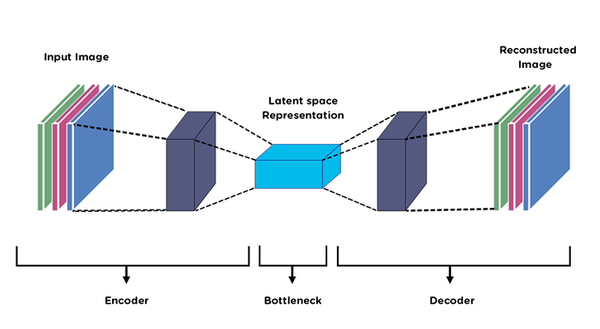

We are familiar with auto encoders that have a bottle neck in the middle which prevents the neural network from learning a trivial representation of the data.That is, if we don't have this condition then $x = f(x)$ will just learn $f(x) = 1 * x$.
This makes the model learn a lower dimensional representation of the data.

Now this can be called an undercomplete autoencoder. The loss function is the mean squared error between $x$ and $x'$ which is the reconstuction of the data. 

But what if we want a higher dimensional representation? 
With the same architecture we will just have trivial solution which means the encoding layers will just have ones as the values. 

Come in sparse auto encoders. 

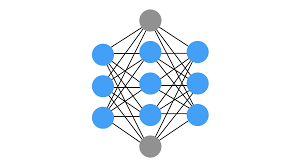

#### Sparse overcomplete autoenders

We can have the dimensions of the embedding layer as more than dimensions of the input. But, we encounter a problem when the model just learns a trivial solution to the problem. We want the model to learn a latent space where the values are mostly close to zero and only non zero sometimes when the information in there to be represented is important. 

This means the embedding layer will be mostly zero barring the important dimensions. 

We can achieve this in the following way. 


We can add a sparsity measure to the loss function. This can be Kullback–Leibler divergence or just $L1$ loss. 
Now as we minimise this new loss function the $L1$ regularization will put a penalty on the values being too high and push them to zero, which will promote sparsity. 

$L = L(x,x') + \lambda \sum_{i} ∣∣ a(h_{i}) ∣∣ $
<br>
where,<br>
$L=$ Loss function<br>
$x'=$  $x$ prime, that is, the reconstructed $x$ <br>
$\lambda=$ Regularization hyperparameter <br>
$a(h) =$ Activation function applied on the node

We will use this to embed our data and hopefully learn a latent space which will acount for interactions between the features and make different combinations of these interactions along with varying kernel functions. If we had to do the same by hand it will be really hard but with a good autoencoder it happens efficiently.


Once we have this sparse representation we can use it to find the similarities in our data and recommend songs. 

In [ ]:
final_songs_df = pd.read_csv(r'D:\Analytics\Univ\Data\Billboards with Audio Features + Genres,Artists OHE + Lyrics.csv',low_memory=False)

In [ ]:
## Lets have a look at the data
final_songs_df

Rank                               Song  \
0        1          Theme from A Summer Place   
1        2                   He'll Have to Go   
2        3                      Cathy's Clown   
3        4                       Running Bear   
4        5                         Teen Angel   
...    ...                                ...   
5617    95              Single Saturday Night   
5618    96           Things a Man Oughta Know   
5619    98                          Tombstone   
5620    99  Drinkin' Beer. Talkin' God. Amen.   
5621   100                         Todo de Ti   

                                         Artist  Year  \
0                                   Percy Faith  1960   
1                                    Jim Reeves  1960   
2                           The Everly Brothers  1960   
3                                Johnny Preston  1960   
4                                  Mark Dinning  1960   
...                                         ...   ...   
5617                              Cole Swindell  2021   
5618                              Lainey Wilson  2021   
5619                                   Rod Wave  2021   
5620  Chase Rice featuring Florida Georgia Line  2021   
5621                             Rauw Alejandro  2021   

                                       URI  \
0     spotify:track:6zwvB879PJSpTyFcg2wwnL   
1     spotify:track:7DH5dXVuQaqcKf9oTy9oUN   
2     spotify:track:27bw4i8LnECzVlbMZ4kFHw   
3     spotify:track:1mE8QtaSFxEQnr3SgxmIRf   
4     spotify:track:6kWR0zt2wWQL3Sjg5ojy9M   
...                                    ...   
5617  spotify:track:1irAliF0T8sLIOPJp6n7rU   
5618  spotify:track:5QS8PNEWbqTEZyQ6e9ZbJf   
5619  spotify:track:3zc8VZEpM1onYV4FWGdFvm   
5620  spotify:track:1b8TpvCFqmJTd2xz9xE9s1   
5621  spotify:track:4fSIb4hdOQ151TILNsSEaF   

                                              Song Name  \
0                       The Theme from "A Summer Place"   
1                                      He'll Have to Go   
2                         Cathy's Clown - 2007 Remaster   
3                                          Running Bear   
4                                            Teen Angel   
...                                                 ...   
5617                              Single Saturday Night   
5618                           Things A Man Oughta Know   
5619                                          Tombstone   
5620  Drinkin' Beer. Talkin' God. Amen. (feat. Flori...   
5621                                         Todo De Ti   

                             Album Name Album Release Date  \
0               16 Most Requested Songs         1989-06-13   
1              The Essential Jim Reeves         1997-02-14   
2       A Date with The Everly Brothers            1960-10   
3                                  ROCK         1960-12-03   
4     Pop Megahits Of The 1950's Vol. 1               2005   
...                                 ...                ...   
5617              Single Saturday Night         2020-05-22   
5618           Sayin' What I'm Thinkin'         2021-02-19   
5619                            SoulFly         2021-03-26   
5620                          The Album         2021-05-28   
5621                         Todo De Ti         2021-05-20   

                          Artist Names  \
0          Percy Faith & His Orchestra   
1                           Jim Reeves   
2                  The Everly Brothers   
3                       Johnny Preston   
4                         Mark Dinning   
...                                ...   
5617                     Cole Swindell   
5618                     Lainey Wilson   
5619                          Rod Wave   
5620  Chase Rice, Florida Georgia Line   
5621                    Rauw Alejandro   

                                       Artist(s) Genres  ...  Artist: Zhané  \
0     lounge, adult standards, man's orchestra, easy...  ...              0   
1                      adult standards, nashville sound  ...  

In [ ]:
#Adding the id column to protect against reindexing

final_songs_df['Song_id'] = pd.Series(final_songs_df.index)

In [ ]:
## Defining preprocess class that will preprocess the data for the autoencoder to aid efficient training. 
class preprocess_data():
  ## Initializinng variables
  def __init__(self, df):
    self.df = df
    self.norm_enc = 0
    self.std_enc = 0
    self.ohe_enc = 0
    self.rank_col = self.df.Rank

  def get_df_AE(self):
    ## This the function we will use to preprocess the data for the autoencoder.
    ##adding release date
    
    self.df['Album Release Date'] = pd.to_datetime(self.df['Album Release Date'])
    ## One hot encoding
    
    object_columns = self.df.select_dtypes('object').columns
    clean_song_df = self.df.drop(object_columns, axis = 1)
    clean_song_df['album_release_year'] = pd.DatetimeIndex(clean_song_df['Album Release Date']).year
    clean_song_df['album_release_month'] = pd.DatetimeIndex(clean_song_df['Album Release Date']).month
    clean_song_df = clean_song_df.drop('Album Release Date', axis = 1)
    enc = OneHotEncoder()
    self.ohe_enc = enc
    enc.fit(clean_song_df[['album_release_year','album_release_month', 'Year']])
    ohe_df  = pd.DataFrame(enc.transform(clean_song_df[['album_release_year','album_release_month','Year']]).toarray(), columns = enc.get_feature_names_out())
    clean_song_df  = clean_song_df.join(ohe_df)
    clean_song_df = clean_song_df.drop(['album_release_year','album_release_month', 'Year'], axis = 1)
    ohe_cols = [c for c in clean_song_df.columns  if (c.lower()[:7] == 'artist:') or (c.lower()[:6] == 'genre:') or (c.lower()[:4] == 'year') or (c.lower()[:5] == 'album') ]
    ohe_df = clean_song_df[ohe_cols]
    
    
    norm_std_cols = [c for c in clean_song_df.columns  if ((c.lower()[:7] != 'artist:') and (c.lower()[:6] != 'genre:') and (c.lower()[:4] != 'year') and (c.lower()[:5] != 'album')) ]
    #norm_std_cols.remove('Song_id')
    #norm_std_cols.remove('Rank')
    norm_std_cols.remove('Name Fuzz Ratio')
    norm_std_cols.remove('Artist Fuzz Ratio')
    norm_std_df = clean_song_df[norm_std_cols]

    ## standardizing

    std_scaler = StandardScaler()
    std_scaler.fit(norm_std_df)
    std_df  = pd.DataFrame(std_scaler.transform(norm_std_df), columns = norm_std_df.columns)
    self.std_enc = std_scaler

    ## Normalizing
    scaler = MinMaxScaler()
    scaler.fit(std_df)
    norm_std_df = pd.DataFrame(scaler.transform(std_df), columns = norm_std_df.columns)
    self.norm_enc = scaler
    cleaned_ohe_norstd_df = norm_std_df.join(ohe_df)
    self.df = cleaned_ohe_norstd_df


    return self.df, self.norm_enc, self.std_enc , self.ohe_enc

  def get_df_pred(self):
    ## Here we are preparing our data for prediction
    ## The steps are similar with small changes.
    rank_col = self.df.Rank
    try:
      self.df = self.df.drop('Song_id', axis = 1)
    except:
      pass
    self.df['Album Release Date'] = pd.to_datetime(self.df['Album Release Date'])
    object_columns = self.df.select_dtypes('object').columns
    clean_song_df = self.df.drop(object_columns, axis = 1)
    clean_song_df['album_release_year'] = pd.DatetimeIndex(clean_song_df['Album Release Date']).year
    clean_song_df['album_release_month'] = pd.DatetimeIndex(clean_song_df['Album Release Date']).month
    clean_song_df = clean_song_df.drop('Album Release Date', axis = 1)
    enc = OneHotEncoder()
    self.ohe_enc = enc
    enc.fit(clean_song_df[['album_release_year','album_release_month', 'Year']])
    ohe_df  = pd.DataFrame(enc.transform(clean_song_df[['album_release_year','album_release_month','Year']]).toarray(), columns = enc.get_feature_names_out())
    clean_song_df  = clean_song_df.join(ohe_df)
    clean_song_df = clean_song_df.drop(['album_release_year','album_release_month', 'Year'], axis = 1)
    ohe_cols = [c for c in clean_song_df.columns  if (c.lower()[:7] == 'artist:') or (c.lower()[:6] == 'genre:') or (c.lower()[:4] == 'year') or (c.lower()[:5] == 'album') ]
    ohe_df = clean_song_df[ohe_cols]
    norm_std_cols = [c for c in clean_song_df.columns  if ((c.lower()[:7] != 'artist:') and (c.lower()[:6] != 'genre:') and (c.lower()[:4] != 'year') and (c.lower()[:5] != 'album')) ]
    #norm_std_cols.remove('Song_id')
    #norm_std_cols.remove('Rank')
    norm_std_cols.remove('Name Fuzz Ratio')
    norm_std_cols.remove('Artist Fuzz Ratio')
    norm_std_df = clean_song_df[norm_std_cols]

    std_scaler = StandardScaler()
    std_scaler.fit(norm_std_df)
    std_df  = pd.DataFrame(std_scaler.transform(norm_std_df), columns = norm_std_df.columns)
    self.std_enc = std_scaler


    scaler = MinMaxScaler()
    scaler.fit(std_df)
    norm_std_df = pd.DataFrame(scaler.transform(std_df), columns = norm_std_df.columns)
    self.norm_enc = scaler
    cleaned_ohe_norstd_df = norm_std_df.join(ohe_df)
    prediction_df = cleaned_ohe_norstd_df.copy()
    prediction_df.Rank = self.rank_col
    self.df = prediction_df


    return self.df, self.norm_enc, self.std_enc , self.ohe_enc



In [ ]:
## Preprocessing for Autoencoder
df_AE, norm_enc_ae , std_enc_ae , ohe_enc_ae = preprocess_data(final_songs_df).get_df_AE()

In [ ]:
df_AE

Rank  Popularity  Acousticness  Danceability    Energy  \
0     0.000000    0.591398      0.596360      0.329960  0.310734   
1     0.010101    0.548387      0.917254      0.560729  0.166923   
2     0.020202    0.559140      0.552969      0.513158  0.552131   
3     0.030303    0.473118      0.782035      0.769231  0.456600   
4     0.040404    0.365591      0.944500      0.575911  0.041397   
...        ...         ...           ...           ...       ...   
5617  0.949495    0.720430      0.119056      0.630567  0.787365   
5618  0.959596    0.763441      0.517651      0.667004  0.677452   
5619  0.979798    0.741935      0.602415      0.556680  0.630200   
5620  0.989899    0.666667      0.186666      0.634615  0.672316   
5621  1.000000    0.892473      0.312803      0.789474  0.713405   

      Instrumentalness  Liveness  Loudness  Speechiness     Tempo  ...  \
0             0.944444  0.493814  0.433506     0.032602  0.801091  ...   
1             0.001481  0.097938  0.405762     0.041603  0.349206  ...   
2             0.000000  0.592784  0.618148     0.038749  0.516370  ...   
3             0.000024  0.174227  0.678022     0.052909  0.516129  ...   
4             0.000000  0.110309  0.298976     0.050274  0.436700  ...   
...                ...       ...       ...          ...       ...  ...   
5617          0.000000  0.217526  0.831641     0.051921  0.352510  ...   
5618          0.000005  0.121649  0.809785     0.034248  0.601924  ...   
5619          0.000000  0.117526  0.826029     0.178924  0.363259  ...   
5620          0.000000  0.370103  0.846619     0.032272  0.430295  ...   
5621          0.000168  0.080619  0.889539     0.055543  0.550382  ...   

      Year_2012  Year_2013  Year_2014  Year_2015  Year_2016  Year_2017  \
0           0.0        0.0        0.0        0.0        0.0        0.0   
1           0.0        0.0        0.0        0.0        0.0        0.0   
2           0.0        0.0        0.0        0.0        0.0        0.0   
3           0.0        0.0        0.0        0.0        0.0        0.0   
4           0.0        0.0        0.0        0.0        0.0        0.0   
...         ...        ...        ...        ...        ...        ...   
5617        0.0        0.0        0.0        0.0        0.0        0.0   
5618        0.0        0.0        0.0        0.0        0.0        0.0   
5619        0.0        0.0        0.0        0.0        0.0        0.0   
5620        0.0        0.0        0.0        0.0        0.0        0.0   
5621        0.0        0.0        0.0        0.0        0.0        0.0   

      Year_2018  Year_2019  Year_2020  Year_2021  
0           0.0        0.0        0.0        0.0  
1           0.0        0.0        0.0        0.0  
2           0.0        0.0        0.0        0.0  
3           0.0        0.0        0.0        0.0  
4           0.0        0.0        0.0        0.0  
...         ...        ...        ...        ...  
5617        0.0        0.0        0.0        1.0  
5618        0.0        0.0        0.0        1.0  
5619        0.0        0.0        0.0        1.0  
5620        0.0        0.0        0.0        1.0  
5621        0.0        0.0        0.0        1.0  

[5622 rows x 3303 columns]

In [ ]:
#Preprocessing for prediction
df_pred, norm_enc_pred , std_enc_pred , ohe_enc_pred = preprocess_data(final_songs_df).get_df_pred()

In [ ]:
df_pred

Rank  Popularity  Acousticness  Danceability    Energy  \
0        1    0.591398      0.596360      0.329960  0.310734   
1        2    0.548387      0.917254      0.560729  0.166923   
2        3    0.559140      0.552969      0.513158  0.552131   
3        4    0.473118      0.782035      0.769231  0.456600   
4        5    0.365591      0.944500      0.575911  0.041397   
...    ...         ...           ...           ...       ...   
5617    95    0.720430      0.119056      0.630567  0.787365   
5618    96    0.763441      0.517651      0.667004  0.677452   
5619    98    0.741935      0.602415      0.556680  0.630200   
5620    99    0.666667      0.186666      0.634615  0.672316   
5621   100    0.892473      0.312803      0.789474  0.713405   

      Instrumentalness  Liveness  Loudness  Speechiness     Tempo  ...  \
0             0.944444  0.493814  0.433506     0.032602  0.801091  ...   
1             0.001481  0.097938  0.405762     0.041603  0.349206  ...   
2             0.000000  0.592784  0.618148     0.038749  0.516370  ...   
3             0.000024  0.174227  0.678022     0.052909  0.516129  ...   
4             0.000000  0.110309  0.298976     0.050274  0.436700  ...   
...                ...       ...       ...          ...       ...  ...   
5617          0.000000  0.217526  0.831641     0.051921  0.352510  ...   
5618          0.000005  0.121649  0.809785     0.034248  0.601924  ...   
5619          0.000000  0.117526  0.826029     0.178924  0.363259  ...   
5620          0.000000  0.370103  0.846619     0.032272  0.430295  ...   
5621          0.000168  0.080619  0.889539     0.055543  0.550382  ...   

      Year_2012  Year_2013  Year_2014  Year_2015  Year_2016  Year_2017  \
0           0.0        0.0        0.0        0.0        0.0        0.0   
1           0.0        0.0        0.0        0.0        0.0        0.0   
2           0.0        0.0        0.0        0.0        0.0        0.0   
3           0.0        0.0        0.0        0.0        0.0        0.0   
4           0.0        0.0        0.0        0.0        0.0        0.0   
...         ...        ...        ...        ...        ...        ...   
5617        0.0        0.0        0.0        0.0        0.0        0.0   
5618        0.0        0.0        0.0        0.0        0.0        0.0   
5619        0.0        0.0        0.0        0.0        0.0        0.0   
5620        0.0        0.0        0.0        0.0        0.0        0.0   
5621        0.0        0.0        0.0        0.0        0.0        0.0   

      Year_2018  Year_2019  Year_2020  Year_2021  
0           0.0        0.0        0.0        0.0  
1           0.0        0.0        0.0        0.0  
2           0.0        0.0        0.0        0.0  
3           0.0        0.0        0.0        0.0  
4           0.0        0.0        0.0        0.0  
...         ...        ...        ...        ...  
5617        0.0        0.0        0.0        1.0  
5618        0.0        0.0        0.0        1.0  
5619        0.0        0.0        0.0        1.0  
5620        0.0        0.0        0.0        1.0  
5621        0.0        0.0        0.0        1.0  

[5622 rows x 3302 columns]

##pp_class 1

In [ ]:
from matplotlib.backend_bases import colors
class pre_process():
  def __init__(self, df):
    self.df = df

  def fix_song_id(self):
    df = self.df
    df['Song_id'] = pd.Series(df.index)
    df = df.iloc[:, [-1, *list(range(0,len(df.columns) -1)) ]]
    return df

  def drop_string_cols(self):
    df = self.df
    str_cols = df.select_dtypes(include='O').columns
    df = df.drop(str_cols, axis = 1)
    return df

  def Year_dummies(self):
    df = self.df
    df = pd.concat([df, pd.get_dummies(df.Year)], axis =1)
    df = df.drop('Year', axis=1)
    return df


  def find_cols_to_norm(self):
    df = self.df
    cols = []
    for col in df.columns:
      if ((max(df[col]) > 1) or (min(df[col])<0)):
        cols.append(col)
    return cols

  def normalize(self, cols):
    df = self.df
    result = df.copy()
    for feature_name in cols:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result


  def drop_song_id(self):
    df = self.df
    df = df.drop('Song_id', axis =1)
    return df

  def standardise(self):
    df = self.df
    df = StandardScaler().fit_transform(df)
    return df

  def train_test_split(self, test_size = .33, random_state = 42):
    X_train, X_test = train_test_split(self.df, test_size=test_size, random_state=random_state)
    return X_train, X_test

  def pre_process_for_training(self):
    df = self.df
    self.df = self.fix_song_id()
    self.df = self.drop_string_cols()
    self.df = self.Year_dummies()
    
    cols = self.find_cols_to_norm()
    self.df = self.normalize(cols)
    self.df = self.drop_song_id()
    self.df = self.standardise()
    X_train, X_test = self.train_test_split()
    return X_train, X_test

  
  def pre_process_for_embedding(self):
    df = self.df
    self.df = self.fix_song_id()
    self.df = self.drop_string_cols()
    self.df = self.Year_dummies()
    
    cols = self.find_cols_to_norm()
    self.df = self.normalize(cols)
    self.df = self.drop_song_id()
    self.df = self.standardise()
    return self.df

  def train_test_split_pred(self,y, test_size = .33, random_state = 42, ):
    X_train,y_train, X_test, y_test = train_test_split(self.df,y, test_size=test_size, random_state=random_state)
    return X_train,y_train, X_test, y_test
  def preprocess_for_prediction_training(self, target_col = 'Rank'):
    df = self.df
    self.df = self.fix_song_id()
    self.df = self.drop_string_cols()
    self.df = self.Year_dummies()
    X = self.df.drop(target_col, axis = 1)
    y = self.df[target_col]
    self.df = X
    df = X
    cols = []
    for col in df.columns:
      if ((max(df[col]) > 1) or (min(df[col])<0)):
        cols.append(col)

    self.df = self.normalize(cols)
    self.df = self.drop_song_id()
    self.df = self.standardise()

    X_train,y_train, X_test, y_test = train_test_split(self.df, y, test_size = .33, random_state = 42 )

    return X_train,y_train, X_test, y_test
    



  


  


##Recommendation model

In [ ]:


# # This is the size of our encoded representations
# encoding_dim = 8192  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# # This is our input image
# input_song_data= keras.Input(shape=df_AE.shape[1],)
# # "encoded" is the encoded representation of the input
# encoded_1 = layers.Dense(4096, activation='relu',activity_regularizer=regularizers.l1(1e-7))(input_song_data)

# encoded_2 = layers.Dense(8192, activation='relu', activity_regularizer=regularizers.l1(1e-7))(encoded_1)

# # "decoded" is the lossy reconstruction of the input
# decoded_1 = layers.Dense(4096, activation='relu',activity_regularizer=regularizers.l1(1e-7))(encoded_2)
# decoded_2 = layers.Dense(df_AE.shape[1], activation='sigmoid')(decoded_1)


# # This model maps an input to its reconstruction
# autoencoder = keras.Model(input_song_data, decoded_2)

# encoder = keras.Model(input_song_data, encoded_2)

# # # This is our encoded (32-dimensional) input
# # encoded_input = keras.Input(shape=encoding_dim,)
# # decoder_layer_1 =autoencoder.get_layer('decode_1')  (encoded_input)
# # # Retrieve the last layer of the autoencoder model
# # decoder_layer = autoencoder.layers[-1]
# # # Create the decoder model
# # decoder = keras.Model(encoded_input, decoded_3)

In [ ]:
## Here we make class where we define our autoencoder
class autoencoder():
  def __init__(self):
    self.encoding_dim = 0
    self.input_shape = 0 
    self.encoder = 0
    self.autoencoder = 0 
    self.opt = tf.keras.optimizers.Nadam(
    learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam")
  def make_autoencoder(self, encoding_dim, input_shape,):
    
    self.encoding_dim = encoding_dim
    self.input_shape = input_shape

    
    encoding_dim = encoding_dim 

    # This is our input image
    input_song_data= keras.Input(shape=input_shape,)
    # "encoded" is the encoded representation of the input
    ## Here we added an activity regularizer which add the regularization term to outputs of this layer. This regularizzer is chosen as l1 since we want a sparse regularization. 

    encoded_1 = layers.Dense(4096, activation='relu',activity_regularizer=regularizers.l1(1e-7))(input_song_data)

    encoded_2 = layers.Dense(8192, activation='relu', activity_regularizer=regularizers.l1(1e-7))(encoded_1)

    # "decoded" is the lossy reconstruction of the input
    decoded_1 = layers.Dense(4096, activation='relu',activity_regularizer=regularizers.l1(1e-7))(encoded_2)
    decoded_2 = layers.Dense(input_shape, activation='sigmoid')(decoded_1)


    # This model maps an input to its reconstruction
    autoencoder = keras.Model(input_song_data, decoded_2)

    encoder = keras.Model(input_song_data, encoded_2)
    self.autoencoder = autoencoder
    self.encoder = encoder
    
    return autoencoder, encoder

  def compile(self):
    self.autoencoder.compile(optimizer = self.opt, loss = 'mean_squared_error')



In [ ]:
##Init Autoencoder
autoencoder, encoder = autoencoder().make_autoencoder(8192,df_AE.shape[1])



In [ ]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3303)]            0         
                                                                 
 dense_4 (Dense)             (None, 4096)              13533184  
                                                                 
 dense_5 (Dense)             (None, 8192)              33562624  
                                                                 
 dense_6 (Dense)             (None, 4096)              33558528  
                                                                 
 dense_7 (Dense)             (None, 3303)              13532391  
                                                                 
Total params: 94,186,727
Trainable params: 94,186,727
Non-trainable params: 0
_________________________________________________________________


In [ ]:
encoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3303)]            0         
                                                                 
 dense_4 (Dense)             (None, 4096)              13533184  
                                                                 
 dense_5 (Dense)             (None, 8192)              33562624  
                                                                 
Total params: 47,095,808
Trainable params: 47,095,808
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## Defining optimizer and compiling
opt = tf.keras.optimizers.Nadam(
    learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam")
autoencoder.compile(optimizer='Nadam', loss='mean_squared_error')

In [ ]:
# !tensorboard --logdir=/tmp/autoencoder

In [ ]:
#loading weights from earliar training
autoencoder.load_weights('/content/gdrive/MyDrive/DS1 project /aeweights (2).h5')

In [ ]:
X_train, X_test = train_test_split(df_AE,test_size = 0.2)

In [ ]:

# history = autoencoder.fit(X_train ,X_train,
#                 epochs=100,
#                 batch_size=64,
#                 shuffle=True,
#                 validation_data=(X_test,X_test), verbose = 2)

In [ ]:
# history.history

In [ ]:

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

In [ ]:
# autoencoder.save_weights('aeweights.h5')

In [ ]:
# encoder.save_weights('encweights.h5')

In [ ]:
# files.download('/content/aeweights.h5')

In [ ]:
## Getting the embeddings for teh whole dataset using the encoder layer of the autoencoder
embeddings = encoder.predict(df_AE)

176/176 [==============================] - 10s 54ms/step


In [ ]:
# np.savetxt('embeddings.csv', embeddings, delimiter=',')

In [ ]:
# np.save('/content/gdrive/MyDrive/DS1 project /embeddings.npy', embeddings)

In [ ]:
#calculating cosine similarity between the embeddings
cs_matrix = cosine_similarity(embeddings)

In [ ]:
cs_df = pd.DataFrame(cs_matrix)

In [ ]:
cs_df['song_id'] = cs_df.index

##Recommend using embeddings and cosine similarity

In [ ]:
## setting the spotipy to get the Image data from the spotipy api
clientID = '60f1e0a91b764b9eac6b5d652f8bb384'
clientSecret = '5f34cf94b74c43ec853706b274e7675b'
client_credentials_manager = SpotifyClientCredentials(client_id=clientID, client_secret=clientSecret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [ ]:
class recommend():
  ## This class will take as input the indexes of the preferences of the userand output recommended songs and playlists.

  def __init__(self, original_df, embeddings_all ,liked_songs_list, encoder = None):
    self.liked_songs_list = liked_songs_list
    self.original_df = original_df
    self.preference_df = 0 
    self.encoder = encoder
    self.preprocessed_df = 0
    self.embeddings_all = embeddings_all 
    self.user_pref_embeddings = 0
    self.similarity_list = 0 
    self.recom_data_sorted = 0

  def get_recom(self):
    ## Selecting rows from the original df according to the index. 
    df = self.original_df[self.original_df.index.isin(self.liked_songs_list)]
    self.preference_df = df
    return df

  def prepare_for_embedding(self, df, ohe_enc, norm_enc , std_enc):
    ## Preparing for the embedding

    df['Album Release Date'] = pd.to_datetime(df['Album Release Date'])
    object_columns = df.select_dtypes('object').columns
    clean_song_df = df.drop(object_columns, axis = 1)
    clean_song_df['album_release_year'] = pd.DatetimeIndex(clean_song_df['Album Release Date']).year
    clean_song_df['album_release_month'] = pd.DatetimeIndex(clean_song_df['Album Release Date']).month
    clean_song_df = clean_song_df.drop('Album Release Date', axis = 1)
    enc = ohe_enc
    ohe_df  = pd.DataFrame(enc.transform(clean_song_df[['album_release_year','album_release_month','Year']]).toarray(), columns = enc.get_feature_names_out())
    ohe_df.index = clean_song_df.index

    # clean_song_df  = clean_song_df.merge(ohe_df)
    clean_song_df  = pd.concat([clean_song_df, ohe_df], axis=1,ignore_index=False)


    clean_song_df = clean_song_df.drop(['album_release_year','album_release_month', 'Year'], axis = 1)
    ohe_cols = [c for c in clean_song_df.columns  if ((c.lower()[:7] == 'artist:') or (c.lower()[:6] == 'genre:') or (c.lower()[:4] == 'year') or (c.lower()[:5] == 'album')) ]
    ohe_df = clean_song_df[ohe_cols]
    # return ohe_df

    # return ohe_df
    norm_std_cols = [c for c in clean_song_df.columns  if ((c.lower()[:7] != 'artist:') and (c.lower()[:6] != 'genre:') and (c.lower()[:4] != 'year') and (c.lower()[:5] != 'album')) ]
    #norm_std_cols.remove('Song_id')
    #norm_std_cols.remove('Rank')
    norm_std_cols.remove('Name Fuzz Ratio')
    norm_std_cols.remove('Artist Fuzz Ratio')
    norm_std_df = clean_song_df[norm_std_cols]


    std_scaler = std_enc

    std_df  = pd.DataFrame(std_scaler.transform(norm_std_df), columns = norm_std_df.columns)
    std_df.index = norm_std_df.index

    scaler = norm_enc

    norm_std_df = pd.DataFrame(scaler.transform(std_df), columns = norm_std_df.columns)

    norm_std_df.index = std_df.index
    # norm_enc = scaler
    # norm_std_df.index - clean_song_df.index

    cleaned_ohe_norstd_df = pd.concat([norm_std_df, ohe_df], axis=1,ignore_index=False)
    # cleaned_ohe_norstd_df = norm_std_df.join(ohe_df)
    df = cleaned_ohe_norstd_df

    self.preprocessed_df = cleaned_ohe_norstd_df

    return cleaned_ohe_norstd_df

  def embed(self):
    # Get embedings from the encoder model
    embeddings = self.encoder.predict(self.preprocessed_df)
    self.user_pref_embeddings = embeddings 
    return embeddings

  def embed_without_enc(self):
    ## If the song is in out playlist already then we just need to fetch teh embeddings from the embeddings matrix
    liked_songs_idx = self.liked_songs_list
    embeddings_df = pd.DataFrame(self.embeddings_all)
    embeddings_df[embeddings_df.index.isin(liked_songs_idx)]
    self.user_pref_embeddings = embeddings_df.values




  def get_similarity_df(self):
    ## Calculating similarity using cosign similarity

    mean_embedding_user = np.mean(self.user_pref_embeddings, axis = 0)
    similarity_list = pd.DataFrame(cosine_similarity(X = self.embeddings_all, Y = mean_embedding_user.reshape(1,-1),dense_output=True)).sort_values(0, ascending = False)
    self.similarity_list = similarity_list
    return similarity_list

  def get_rec_songs_data(self):
    ## Getting the songs data from the original data
    recom_data_sorted = self.original_df.reindex(self.similarity_list.index)
    self.recom_data_sorted = recom_data_sorted
    return recom_data_sorted

  def get_top_10_recom(self):
    ## making the recommendations
    top_ten_data = self.recom_data_sorted.head(10)
    uri_list = top_ten_data.URI
    image_url_list = []
    for uri in uri_list:
      song = sp.track(uri)
      art = song['album']['images'][0]['url']
      image_url_list.append(art)
    top_ten_data['image_link'] = image_url_list

    return top_ten_data

  ## These are a series of functions that make the playlist according to some metrics. 

  def make_pop_playlist(self):



    pop_df = self.recom_data_sorted[self.recom_data_sorted.Popularity > .7].head(10)
    uri_list = pop_df.URI
    image_url_list = []
    for uri in uri_list:
      song = sp.track(uri)
      art = song['album']['images'][0]['url']
      image_url_list.append(art)
    pop_df['image_link'] = image_url_list

    return pop_df 



  def make_dance_playlist(self):
    dance_df = self.recom_data_sorted[self.recom_data_sorted.Danceability > .7].head(10)
    uri_list = dance_df.URI
    image_url_list = []
    for uri in uri_list:
      song = sp.track(uri)
      art = song['album']['images'][0]['url']
      image_url_list.append(art)
    dance_df['image_link'] = image_url_list

    return dance_df 

  def make_dance_playlist2(self):
    dance_df = self.recom_data_sorted.sort_values('Danceability').head(10)
    uri_list = dance_df.URI
    image_url_list = []
    for uri in uri_list:
      song = sp.track(uri)
      art = song['album']['images'][0]['url']
      image_url_list.append(art)
    dance_df['image_link'] = image_url_list

    return dance_df 

  def make_sad_playlist(self):
    sad_df = self.recom_data_sorted[self.recom_data_sorted.Valence < .35].head(10)
    uri_list = sad_df.URI
    image_url_list = []
    for uri in uri_list:
      song = sp.track(uri)
      art = song['album']['images'][0]['url']
      image_url_list.append(art)
    sad_df['image_link'] = image_url_list

    return sad_df 











In [ ]:
## testing out our recommendation system with random preferences
liked_songs_idx = [5000, 3000, 3500, 5023]
embeddings_df = pd.DataFrame(embeddings)
embeddings_df[embeddings_df.index.isin(liked_songs_idx)]

0         1     2     3     4     5     6         7     8     9     ...  \
3000   0.0  0.122069   0.0   0.0   0.0   0.0   0.0  0.000000   0.0   0.0  ...   
3500   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  0.000000   0.0   0.0  ...   
5000   0.0  0.013693   0.0   0.0   0.0   0.0   0.0  0.079576   0.0   0.0  ...   
5023   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  0.037304   0.0   0.0  ...   

      8182  8183  8184  8185  8186  8187  8188  8189  8190  8191  
3000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3500   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
5000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
5023   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[4 rows x 8192 columns]

In [ ]:
## HEre we test out the whole system with random  indexes. 
liked_songs_idx = [5000, 23, 3500, 5023]

rec = recommend(final_songs_df, embeddings, liked_songs_idx, encoder = encoder)
pref_df = rec.get_recom()
pre_emb_pref_df = rec.prepare_for_embedding(pref_df, ohe_enc_ae ,norm_enc_ae , std_enc_ae)
rec.embed()
rec.get_similarity_df()
rec.get_rec_songs_data()
rec.get_top_10_recom()
rec.make_pop_playlist()
rec.make_dance_playlist2()
# rec.make_sad_playlist()[['Rank', 'Song', 'Artist','Year', 'URI','image_link' ]]



1/1 [==============================] - 0s 160ms/step


Rank                              Song                     Artist  Year  \
388      3                     Hello, Dolly!            Louis Armstrong  1964   
1724    99            Star Wars (Main Title)  London Symphony Orchestra  1977   
3463    96              I Got Id / Long Road                  Pearl Jam  1996   
74      78                Georgia on My Mind                Ray Charles  1960   
975      1        Bridge Over Troubled Water          Simon & Garfunkel  1970   
4351    64                   Keep Holding On              Avril Lavigne  2007   
1058    90             Come Saturday Morning             The Sandpipers  1970   
593     12  (You're My) Soul and Inspiration     The Righteous Brothers  1966   
802     24           Turn Around, Look at Me                 The Vogues  1968   
475     92                        Shangri-La             Robert Maxwell  1964   

                                       URI  \
388   spotify:track:63kd4m3VFxcJjPVVtbVNAu   
1724  spotify:track:3UqSTlEwO5spY8YL3GfQGv   
3463  spotify:track:3ZzJkuppQw26ZciijHwK3W   
74    spotify:track:47mA6f44zxLtdATOoY7GjN   
975   spotify:track:6l8EbYRtQMgKOyc1gcDHF9   
4351  spotify:track:4UPcXTh26ilb7owtuyHqNI   
1058  spotify:track:6CktzfYm1SNLwFiyV9XwJY   
593   spotify:track:5ZHOiRqKOzgFMfMAu8cwzp   
802   spotify:track:6w8Pnj2aUSJysc0b5FSJyr   
475   spotify:track:4CIUnCovHwKniGIANzXgt2   

                                           Song Name  \
388                                    Hello, Dolly!   
1724   Star Wars Main Title and the Arrival at Naboo   
3463                                        I Got Id   
74    Georgia on My Mind - Original Master Recording   
975                       Bridge Over Troubled Water   
4351                                 Keep Holding On   
1058                           Come Saturday Morning   
593                 (You're My) Soul And Inspiration   
802                          Turn Around, Look at Me   
475                                       Shangri-La   

                                             Album Name Album Release Date  \
388                          Hello, Dolly! (Remastered)         1964-10-25   
1724  Star Wars: The Phantom Menace (Original Motion...         1999-05-04   
3463                                        Merkin Ball         1995-12-05   
74       Georgia on My Mind (Original Master Recording)         1960-09-01   
975                          Bridge Over Troubled Water         1970-01-26   
4351             The Best Damn Thing (Expanded Edition)         2007-04-17   
1058                              Come Saturday Morning         1970-08-31   
593   The Very Best Of The Righteous Brothers - Unch...         1990-01-01   
802                             Turn Around, Look At Me         1968-01-01   
475                                          Shangri-La         2014-11-12   

                                  Artist Names  \
388                            Louis Armstrong   
1724  John Williams, London Symphony Orchestra   
3463                                 Pearl Jam   
74                                 Ray Charles   
975                          Simon & Garfunkel   
4351                             Avril Lavigne   
1058                            The Sandpipers   
593                     The Righteous Brothers   
802                                 The Vogues   
475                             Robert Maxwell   

                                       Artist(s) Genres  ...  \
388   adult standards, harlem renaissance, dixieland...  ...   
1724  soundtrack, classical, orchestral soundtrack, ...  ...   
3463     grunge, rock, alternative rock, permanent wave  ...   
74    classic soul, adult standards, jazz blues, voc...  ...   
975   classic rock, melancholia, rock, folk, mellow ...  ...   
4351  pop, canadian pop, post-teen pop, dance pop, c...  ...   
1058  bubblegum pop, adult standards, easy listening...  ...   
593   bubblegum pop, adult standards, brill building...  ...   
802 

In [ ]:
rec = recommend(final_songs_df,embeddings, liked_songs_idx)
rec.embed_without_enc()
rec.get_similarity_df()
rec.get_rec_songs_data()
rec.get_top_10_recom()

Rank                  Song               Artist  Year  \
4431    57      Miss Independent                Ne-Yo  2008   
4733    13    Sexy and I Know It                LMFAO  2012   
3729    28  That's the Way It Is          Celine Dion  2000   
305     19           Mockingbird  Inez & Charlie Foxx  1963   
224     36         Cotton Fields       The Highwaymen  1962   
3087    79    Everything Changes       Kathy Troccoli  1992   
4800    89            You da One              Rihanna  2012   
2876    50          No More Lies            Michel'le  1990   
4740    21   Where Have You Been              Rihanna  2012   
4517    59      Miss Independent                Ne-Yo  2009   

                                       URI             Song Name  \
4431  spotify:track:34ceTg8ChN5HjrqiIYCn9Q      Miss Independent   
4733  spotify:track:0obBFrPYkSoBJbvHfUIhkv    Sexy And I Know It   
3729  spotify:track:5s4catxeZsaWFnOrvrXZHf  That's the Way It Is   
305   spotify:track:0s1e2Pplqp0ExGFUdQ3mCr           Mockingbird   
224   spotify:track:4u00xAxjE159vAnxfMNgP4         Cotton Fields   
3087  spotify:track:7rJXvz9zXQr9YYdYzeXe7U    Everything Changes   
4800  spotify:track:3Yt9lRtS5V4nbJnwcgFgvC            You Da One   
2876  spotify:track:1Oz5bcZyzhiaEa3F06EiPY          No More Lies   
4740  spotify:track:5WQQIDU3HRaMyPkob8mpFb   Where Have You Been   
4517  spotify:track:34ceTg8ChN5HjrqiIYCn9Q      Miss Independent   

                                       Album Name Album Release Date  \
4431  Year Of The Gentleman (Bonus Track Edition)         2008-01-01   
4733     Sorry For Party Rocking (Deluxe Version)         2011-01-01   
3729                 The Very Best of Celine Dion         1999-01-01   
305                         Best Of The Sue Years         2011-01-01   
224                      The Folk Hits Collection         2007-01-01   
3087                                Greatest Hits         2003-01-01   
4800                               Talk That Talk         2011-11-19   
2876                                    Michel'le         1989-01-01   
4740                               Talk That Talk         2011-11-18   
4517  Year Of The Gentleman (Bonus Track Edition)         2008-01-01   

             Artist Names                                   Artist(s) Genres  \
4431                Ne-Yo                 dance pop, urban contemporary, pop   
4733                LMFAO                                 dance pop, pop rap   
3729          Céline Dion                                       canadian pop   
305   Inez & Charlie Foxx                                                NaN   
224        The Highwaymen                                                NaN   
3087       Kathy Troccoli                                                NaN   
4800              Rihanna  dance pop, urban contemporary, pop, barbadian pop   
2876            Michel'le  r&b, contemporary r&b, urban contemporary, qui...   
4740              Rihanna  dance pop, urban contemporary, pop, barbadian pop   
4517                Ne-Yo                 dance pop, urban contemporary, pop   

      ...  Artist: beabadoobee  Artist: benny blanco  Artist: blackbear  \
4431  ...                    0                     0                  0   
4733  ...                    0                     0                  0   
3729  ...                    0                     0                  0   
305   ...                    0                     0                  0   
224   ...                    0                     0                  0   
3087  ...                    0                     0                  0   
4800  ...                    0                     0                  0   
2876  ...                    0                     0                  0   
4740  ...                    0                     0                  0   
4517  ...                    0                     0                  0   

      Artist: blink-182  Artist: fun.  Artist: iLoveMemphis  \


#Predicting Rank for different 5 year periods.

#### Model for 2000-2005

In [ ]:
## Choosing the data pertaining to the period. 
decade_2000 = " ".join([f'Year_200{i} == 1 |' for i in range(0,6)])[:-1]
decade_10s_df = df_pred.query(decade_2000)


In [ ]:
X = decade_10s_df.drop('Rank', axis = 1)
y = decade_10s_df.Rank
# data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
##prediction model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)




In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

As we can the linear model is not able to predict the ranks properly. 

In [ ]:
linear_reg = LinearRegression().fit(X_train, y_train)
prediction_train=linear_reg.predict(X_train)
lin_train_mse = mean_squared_error(y_train, prediction_train)
print('Train MSE: ',lin_train_mse,'\n')
prediction_test=linear_reg.predict(X_test)
lin_test_mse = mean_squared_error(y_test, prediction_test)
print('Test MSE: ',lin_test_mse,'\n')

Train MSE:  109.84801557863501 

Test MSE:  1.0489325130078189e+27 



In [ ]:
xgb_mod = xgboost.XGBRegressor(n_estimators=100, max_depth = 3, eta=0.1, subsample=0.7, colsample_bytree=0.8, gamma = 0.1
                               )
xgb_mod.fit(X_train,y_train)

[13:48:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.8, eta=0.1, gamma=0.1, subsample=0.7)

In [ ]:
prediction=xgb_mod.predict(X_train)
prediction_train=xgb_mod.predict(X_train)
xgb_train_mse = mean_squared_error(y_train, prediction_train)
print('Train MSE: ',xgb_train_mse,'\n')
prediction_test=xgb_mod.predict(X_test)
xgb_test_mse = mean_squared_error(y_test, prediction_test)
print('Test MSE: ',xgb_test_mse,'\n')

Train MSE:  152.9427881382502 

Test MSE:  758.2888343245942 



In [ ]:

## Looking at a few predictions
for i in range(0, 20):
  print(y_test.values[i], prediction_test[i])

36 37.224392
93 70.12291
61 69.7212
100 39.13629
35 24.16416
50 61.10664
77 49.383224
62 76.602165
86 60.01327
3 37.959312
11 31.639097
50 54.95867
77 40.852467
6 36.556923
55 48.412178
75 53.690125
96 62.72952
39 68.04045
90 79.10491
94 65.24792


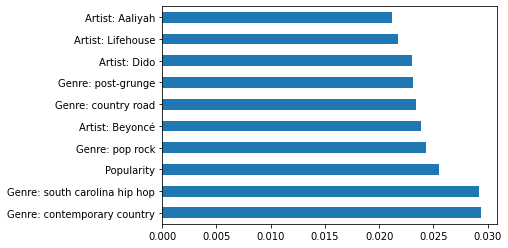

In [ ]:
## Feature importance based on the xgboost model. 
feat_importances = pd.Series(xgb_mod.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

Just by the simple feature importance we see that genre comtemporary country is the most important feature along with features like artist = beyonce and popularity 

In [ ]:
perm_importance = permutation_importance(xgb_mod, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

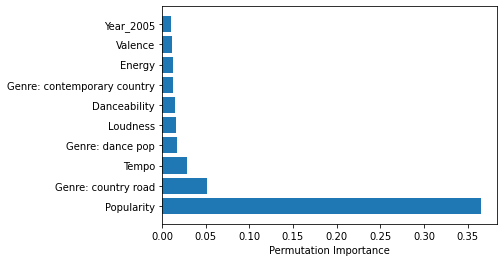

In [ ]:
sorted_idx = perm_importance.importances_mean.argsort()[::-1][:10]
plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

When we use permutation importance things become a bit clearer. The popularity columns plays a big role as you would expect. Along with if genre is country or not. 

Now we see how each feature changes the output using shap values. 

In [ ]:
explainerXGB = shap.TreeExplainer(xgb_mod)
shap_values_XGB_test = explainerXGB.shap_values(X_test)
shap_values_XGB_train = explainerXGB.shap_values(X_train)
df_shap_XGB_test = pd.DataFrame(shap_values_XGB_test, columns=X_test.columns.values)
df_shap_XGB_train = pd.DataFrame(shap_values_XGB_train, columns=X_train.columns.values)


In [ ]:
# j will be the record we explain
j = 0
# initialize js for SHAP
shap.initjs()

shap.force_plot(explainerXGB.expected_value, shap_values_XGB_test[j], X_test.iloc[[j]])

Here we can see that features that make the prediction of this sample lower are popularity and some genres columns.

These columns can be interprested as being popular during this period.

At the same time valence pushes the predicted rank up along with tempo.

These are splits for the decision trees

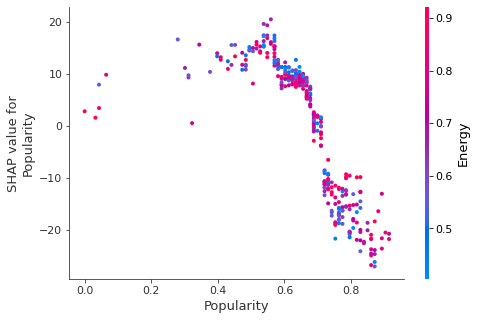

In [ ]:
shap.dependence_plot("Popularity", shap_values_XGB_train, X_train)

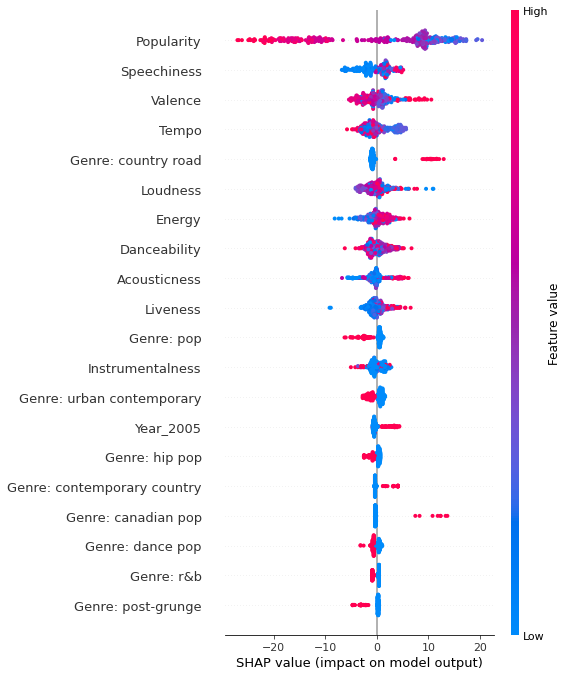

In [ ]:
shap.summary_plot(shap_values_XGB_train, X_train)

Here we can see that feature that has the most impact on the model output is Popularity. The higher the Popularity the lower the rank. 

We see the opposite for the feature Speechiness. The lower the Speechiness, the lower the rank. 
Similar results are observed for Loudness. Additionally, high energy will increase the rank. 

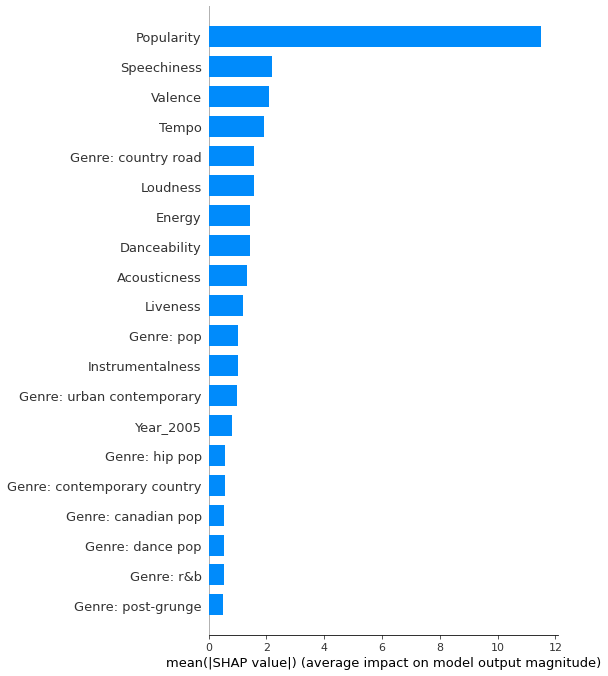

In [ ]:
shap.summary_plot(shap_values_XGB_train, X_train, plot_type="bar")

####Model for 2006-2010

In [ ]:
decade_2000 = " ".join([f'Year_{i} == 1 |' for i in range(2006,2011)])[:-1]
decade_10s_df = df_pred.query(decade_2000)


In [ ]:
X = decade_10s_df.drop('Rank', axis = 1)
y = decade_10s_df.Rank
# data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
##prediction model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

In [ ]:
linear_reg = LinearRegression().fit(X_train, y_train)
prediction_train=linear_reg.predict(X_train)
lin_train_mse = mean_squared_error(y_train, prediction_train)
print('Train MSE: ',lin_train_mse,'\n')
prediction_test=linear_reg.predict(X_test)
lin_test_mse = mean_squared_error(y_test, prediction_test)
print('Test MSE: ',lin_test_mse,'\n')

Train MSE:  152.54948089816045 

Test MSE:  1.3673067574882376e+28 



In [ ]:
xgb_mod = xgboost.XGBRegressor(n_estimators=100, max_depth = 3, eta=0.1, subsample=0.7, colsample_bytree=0.8, gamma = 0.1
                               )
xgb_mod.fit(X_train,y_train)

[14:07:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.8, eta=0.1, gamma=0.1, subsample=0.7)

In [ ]:
prediction=xgb_mod.predict(X_train)
prediction_train=xgb_mod.predict(X_train)
xgb_train_mse = mean_squared_error(y_train, prediction_train)
print('Train MSE: ',xgb_train_mse,'\n')
prediction_test=xgb_mod.predict(X_test)
xgb_test_mse = mean_squared_error(y_test, prediction_test)
print('Test MSE: ',xgb_test_mse,'\n')

Train MSE:  151.1757676067966 

Test MSE:  807.6715539514738 



In [ ]:
## Looking at a few predictions
for i in range(0, 20):
  print(y_test.values[i], prediction_test[i])

68 54.10537
89 17.287247
2 30.298008
38 69.44713
97 65.8326
82 66.81533
54 60.916443
59 48.77959
33 45.642265
81 60.635876
78 82.09768
8 13.766686
37 43.826817
4 63.365932
81 39.19341
92 66.50982
12 61.49664
89 77.94904
27 8.316496
71 75.80379


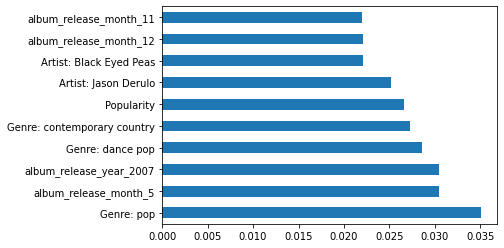

In [ ]:
feat_importances = pd.Series(xgb_mod.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

We can see that the Genre pop is the most important feature. Also if the album was released in the fifth month seems to be an important feature.

In [ ]:
perm_importance = permutation_importance(xgb_mod, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

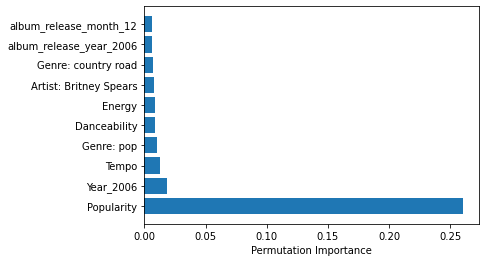

In [ ]:
sorted_idx = perm_importance.importances_mean.argsort()[::-1][:10]
plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

As you would expect the popularity of the song has an effect on the predicted rank. we can also see that the tempo and genre is important for the prediction.
Also if the artist's name is Britney Spears then it has an impact on the ranking.

In [ ]:
# test_pred = xgb_mod.predict(X)
# errors = test_pred - y
# sorted_errors = np.argsort(abs(errors))
# worse_5 = sorted_errors[-5:]
# best_5 = sorted_errors[:5]



# explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, class_names=['Rank'],feature_names=X.columns, verbose=True, mode='regression')

# # i = worse_5.values[0]
# i = 4
# print('Error =', errors.values[i])
# exp = explainer.explain_instance(X_train.values[i], xgb_mod.predict,num_features=3303)
# exp.show_in_notebook(show_table=True)

In [ ]:
explainerXGB = shap.TreeExplainer(xgb_mod)
shap_values_XGB_test = explainerXGB.shap_values(X_test)
shap_values_XGB_train = explainerXGB.shap_values(X_train)
df_shap_XGB_test = pd.DataFrame(shap_values_XGB_test, columns=X_test.columns.values)
df_shap_XGB_train = pd.DataFrame(shap_values_XGB_train, columns=X_train.columns.values)


In [ ]:
# j will be the record we explain
j = 0
# initialize js for SHAP
shap.initjs()

shap.force_plot(explainerXGB.expected_value, shap_values_XGB_test[j], X_test.iloc[[j]])

For this time period we can see that the Genre:POP pushed the predicted rank down if its 1.

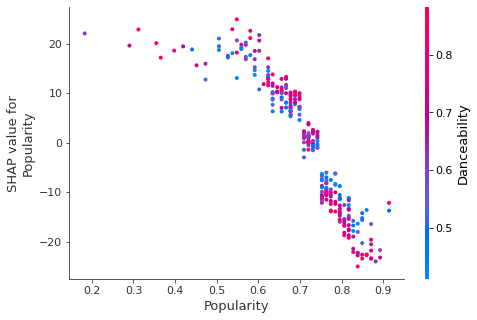

In [ ]:
shap.dependence_plot("Popularity", shap_values_XGB_train, X_train)

Here we can see that the shape value of popularity goes to -20 as we reach popularity = 1. 
This means that higher the popularity the lower the rank as we saw in the last time period. 

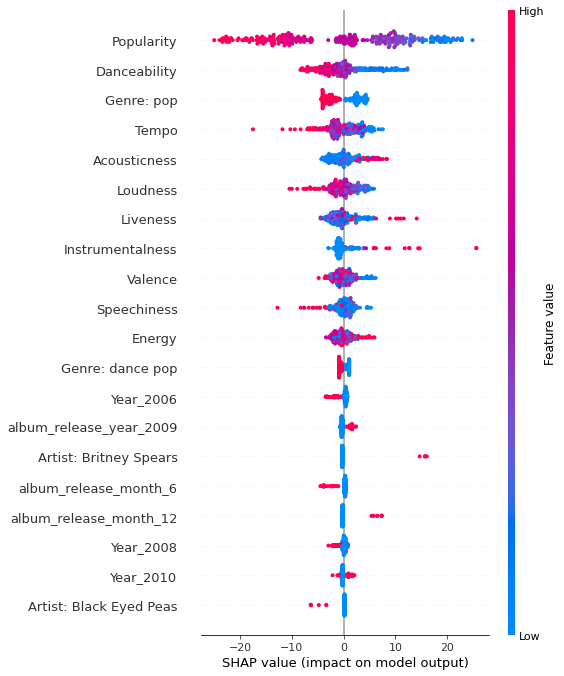

In [ ]:
shap.summary_plot(shap_values_XGB_train, X_train)

We see a similar pattern here but the dancibility seems to have a big impact on the shap values. If the song is more danceable then the predicted rank will be lower, that is, closer to 1. 

Similarly, if the tempo is high then the predicted rank will be lower.

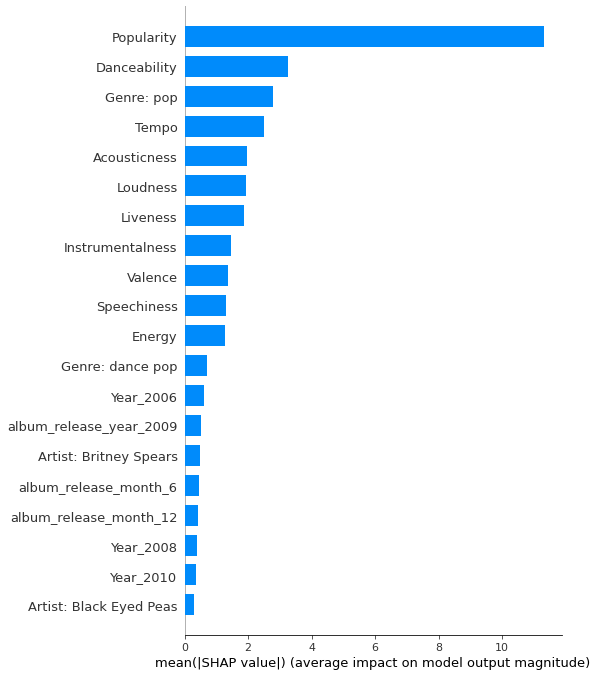

In [ ]:
shap.summary_plot(shap_values_XGB_train, X_train, plot_type="bar")

####Model for 2010-2015

In [ ]:
decade_2000 = " ".join([f'Year_{i} == 1 |' for i in range(2010,2016)])[:-1]
decade_10s_df = df_pred.query(decade_2000)


In [ ]:
X = decade_10s_df.drop('Rank', axis = 1)
y = decade_10s_df.Rank
# data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
##prediction model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

In [ ]:
linear_reg = LinearRegression().fit(X_train, y_train)
prediction_train=linear_reg.predict(X_train)
lin_train_mse = mean_squared_error(y_train, prediction_train)
print('Train MSE: ',lin_train_mse,'\n')
prediction_test=linear_reg.predict(X_test)
lin_test_mse = mean_squared_error(y_test, prediction_test)
print('Test MSE: ',lin_test_mse,'\n')

Train MSE:  160.47651728877315 

Test MSE:  7.759861565798965e+28 



In [ ]:
xgb_mod = xgboost.XGBRegressor(n_estimators=1000, max_depth = 40, eta=0.1, subsample=0.7, colsample_bytree=0.8, gamma = 2
                               )
xgb_mod.fit(X_train,y_train)

[14:19:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.8, eta=0.1, gamma=2, max_depth=40,
             n_estimators=1000, subsample=0.7)

In [ ]:
prediction=xgb_mod.predict(X_train)
prediction_train=xgb_mod.predict(X_train)
xgb_train_mse = mean_squared_error(y_train, prediction_train)
print('Train MSE: ',xgb_train_mse,'\n')
prediction_test=xgb_mod.predict(X_test)
xgb_test_mse = mean_squared_error(y_test, prediction_test)
print('Test MSE: ',xgb_test_mse,'\n')

Train MSE:  0.17477583189397125 

Test MSE:  827.7222545691745 



In [ ]:
## Looking at a few predictions
for i in range(0, 20):
  print(y_test.values[i], prediction_test[i])

62 19.223263
51 51.099155
14 68.98901
20 54.650803
2 35.77254
69 39.918285
100 57.90231
58 12.470884
48 50.785244
69 27.160975
19 6.791912
84 59.479877
99 60.326183
7 54.81807
49 53.353592
72 48.744457
4 37.8465
89 70.00869
37 44.57282
62 59.596367


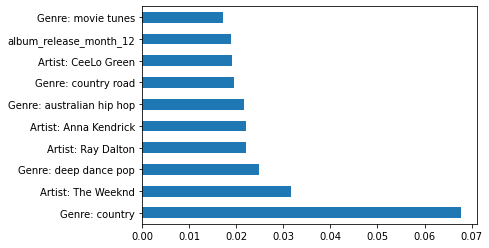

In [ ]:
feat_importances = pd.Series(xgb_mod.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

Fir this time period Country columns seem to be the the most important feature along some artist and other genre columns

In [ ]:
perm_importance = permutation_importance(xgb_mod, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

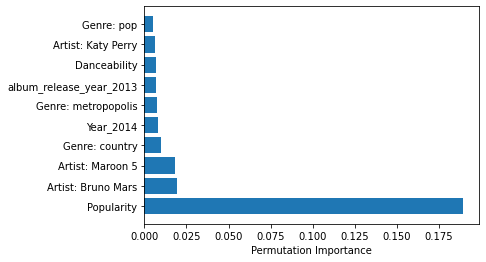

In [ ]:
sorted_idx = perm_importance.importances_mean.argsort()[::-1][:10]
plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In the permutation importance plot we can see that the popularity has the most impact on the rank followed by some popular artists in the era. 

In [ ]:
# test_pred = xgb_mod.predict(X)
# errors = test_pred - y
# sorted_errors = np.argsort(abs(errors))
# worse_5 = sorted_errors[-5:]
# best_5 = sorted_errors[:5]



# explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, class_names=['Rank'],feature_names=X.columns, verbose=True, mode='regression')

# # i = worse_5.values[0]
# i = 4
# print('Error =', errors.values[i])
# exp = explainer.explain_instance(X_train.values[i], xgb_mod.predict,num_features=3303)
# exp.show_in_notebook(show_table=True)

In [ ]:
explainerXGB = shap.TreeExplainer(xgb_mod)
shap_values_XGB_test = explainerXGB.shap_values(X_test)
shap_values_XGB_train = explainerXGB.shap_values(X_train, check_additivity=False)
df_shap_XGB_test = pd.DataFrame(shap_values_XGB_test, columns=X_test.columns.values)
df_shap_XGB_train = pd.DataFrame(shap_values_XGB_train, columns=X_train.columns.values)


In [ ]:
# j will be the record we explain
j = 0
# initialize js for SHAP
shap.initjs()

shap.force_plot(explainerXGB.expected_value, shap_values_XGB_test[j], X_test.iloc[[j]])

We can see the values of the split in the decision tree. For examples whether the genre is rock pushed the prediction down. 

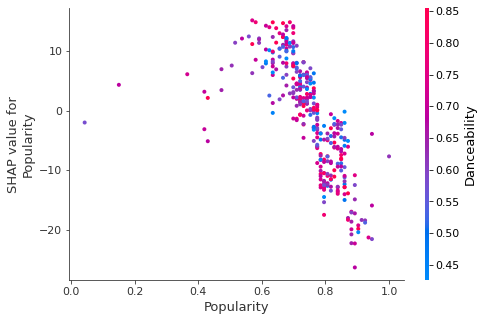

In [ ]:
shap.dependence_plot("Popularity", shap_values_XGB_train, X_train)

Similar plot here to the other time periods. As the popularity increases it has a negative impact on the predicted rank.

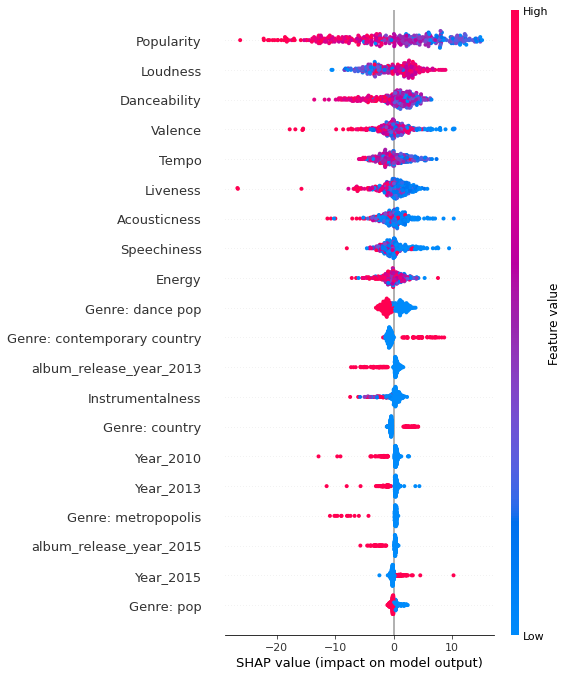

In [ ]:
shap.summary_plot(shap_values_XGB_train, X_train)

Here we see something interesting with Loudness and Dancibility having inverse impact on the outputs.

As the Loudness increases, it increases the predicted rank. But, as the Dancibility increases, it decreases the predicted rank.

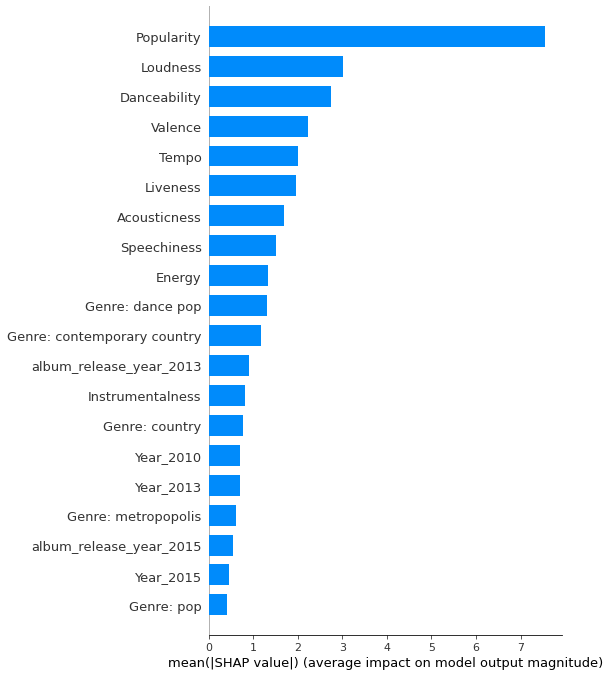

In [ ]:
shap.summary_plot(shap_values_XGB_train, X_train, plot_type="bar")

####Model for 2016-2021

In [ ]:
decade_2000 = " ".join([f'Year_{i} == 1 |' for i in range(2016,2022)])[:-1]
decade_10s_df = df_pred.query(decade_2000)


In [ ]:
X = decade_10s_df.drop('Rank', axis = 1)
y = decade_10s_df.Rank
# data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
##prediction model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)




In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

In [ ]:
linear_reg = LinearRegression().fit(X_train, y_train)
prediction_train=linear_reg.predict(X_train)
lin_train_mse = mean_squared_error(y_train, prediction_train)
print('Train MSE: ',lin_train_mse,'\n')
prediction_test=linear_reg.predict(X_test)
lin_test_mse = mean_squared_error(y_test, prediction_test)
print('Test MSE: ',lin_test_mse,'\n')

Train MSE:  256.1842259598829 

Test MSE:  2.4132297484075988e+29 



In [ ]:
xgb_mod = xgboost.XGBRegressor(n_estimators=1000, max_depth = 40, eta=0.1, subsample=0.7, colsample_bytree=0.8, gamma = 2
                               )
xgb_mod.fit(X_train,y_train)

[14:37:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.8, eta=0.1, gamma=2, max_depth=40,
             n_estimators=1000, subsample=0.7)

In [ ]:
prediction=xgb_mod.predict(X_train)
prediction_train=xgb_mod.predict(X_train)
xgb_train_mse = mean_squared_error(y_train, prediction_train)
print('Train MSE: ',xgb_train_mse,'\n')
prediction_test=xgb_mod.predict(X_test)
xgb_test_mse = mean_squared_error(y_test, prediction_test)
print('Test MSE: ',xgb_test_mse,'\n')

Train MSE:  0.17395861886335948 

Test MSE:  729.5636668394524 



In [ ]:
## Looking at a few predictions
for i in range(0, 20):
  print(y_test.values[i], prediction_test[i])

100 61.038586
81 67.534004
91 37.340866
96 73.872986
63 63.362537
87 57.79106
24 27.510538
57 62.663956
93 56.26888
73 35.76909
7 56.722534
35 24.289541
55 61.953747
84 57.106655
70 60.562813
71 31.920715
37 37.40814
12 57.557373
84 70.64633
63 57.92367


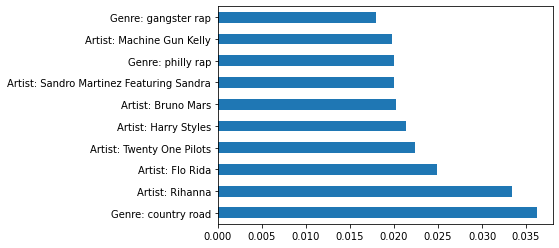

In [ ]:
feat_importances = pd.Series(xgb_mod.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [ ]:
perm_importance = permutation_importance(xgb_mod, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

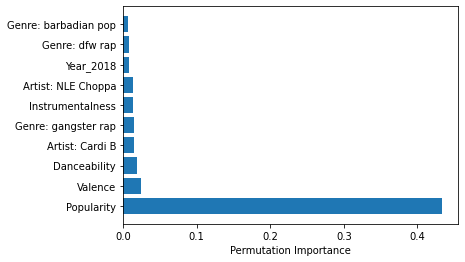

In [ ]:
sorted_idx = perm_importance.importances_mean.argsort()[::-1][:10]
plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

For this time period the valence seems to be the an important feature in the model. along with if the artist was cardi B.

In [ ]:
# test_pred = xgb_mod.predict(X)
# errors = test_pred - y
# sorted_errors = np.argsort(abs(errors))
# worse_5 = sorted_errors[-5:]
# best_5 = sorted_errors[:5]



# explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, class_names=['Rank'],feature_names=X.columns, verbose=True, mode='regression')

# # i = worse_5.values[0]
# i = 4
# print('Error =', errors.values[i])
# exp = explainer.explain_instance(X_train.values[i], xgb_mod.predict,num_features=3303)
# exp.show_in_notebook(show_table=True)

In [ ]:
explainerXGB = shap.TreeExplainer(xgb_mod)
shap_values_XGB_test = explainerXGB.shap_values(X_test,check_additivity=False)
shap_values_XGB_train = explainerXGB.shap_values(X_train,check_additivity=False)
df_shap_XGB_test = pd.DataFrame(shap_values_XGB_test, columns=X_test.columns.values)
df_shap_XGB_train = pd.DataFrame(shap_values_XGB_train, columns=X_train.columns.values)


In [ ]:
# j will be the record we explain
j = 0
# initialize js for SHAP
shap.initjs()

shap.force_plot(explainerXGB.expected_value, shap_values_XGB_test[j], X_test.iloc[[j]])

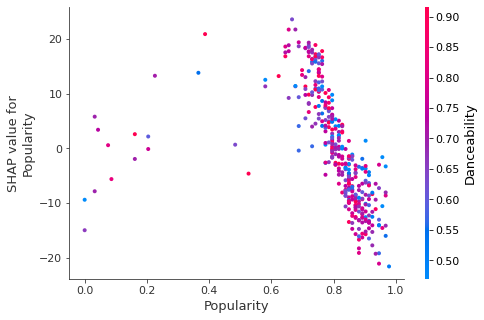

In [ ]:
shap.dependence_plot("Popularity", shap_values_XGB_train, X_train)

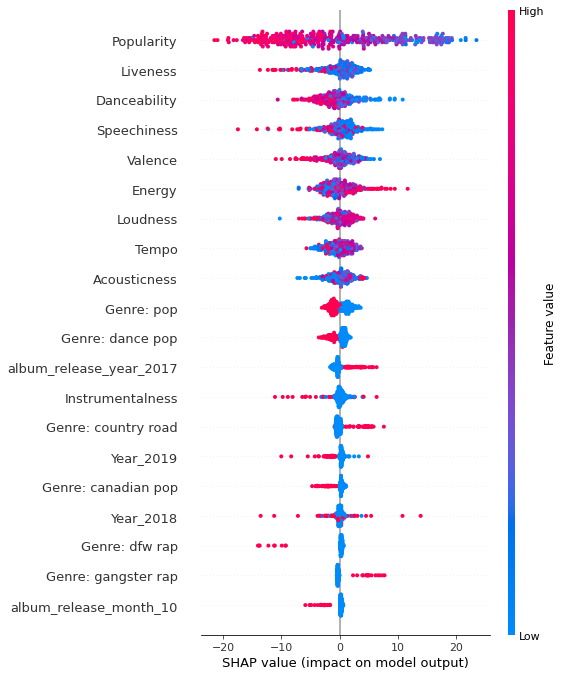

In [ ]:
shap.summary_plot(shap_values_XGB_train, X_train)

Here have a similar plot to the other time periods. But we see liveness being an important factor. This could mean that there were some songs that were live and were rated low in the time period.
Having high speechiness also translated to having a high shap value.
Having the genre as pop seems to have a clear impact on the output. If genre pop = 1 then it pushes the predicted rank down. 

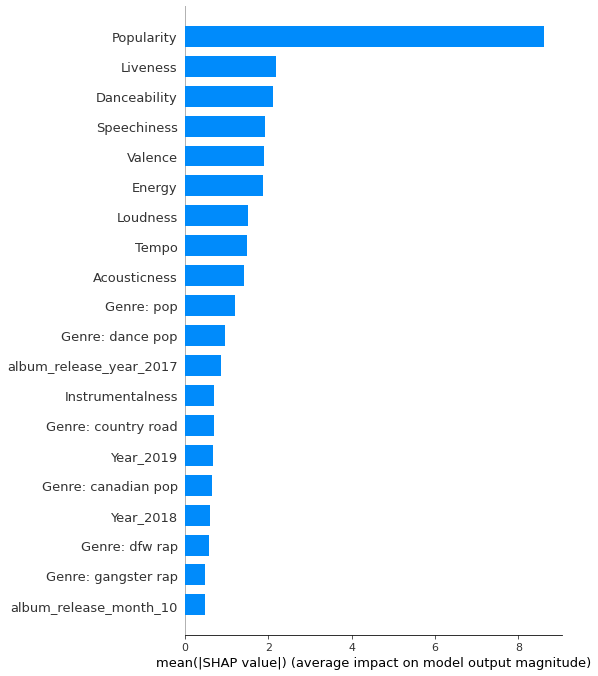

In [ ]:
shap.summary_plot(shap_values_XGB_train, X_train, plot_type="bar")

# References

* https://www.kaggle.com/code/yohanb/explaining-xgb-model-with-lime <br> 
* https://stackoverflow.com/questions/730764/how-to-properly-ignore- <br> 
* https://www.dominodatalab.com/blog/shap-lime-python-libraries-part-2-using-shap-lime <br>
* https://xgboost.readthedocs.io/en/stable/parameter.html <br>
* https://mljar.com/blog/feature-importance-xgboost/ <br> 
* https://medium.com/data-design/xgboost-hi-im-gamma-what-can-i-do-for-you-and-the-tuning-of-regularization-a42ea17e6ab6 <br> 
* https://machinelearningmastery.com/how-to-save-a-numpy-array-to-file-for-machine-learning/ <br>
* https://web.stanford.edu/class/cs294a/sparseAutoencoder.pdf <br>